In [2]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon, ttest_rel, ttest_ind
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ColorConverter


PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

In [4]:
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_full_merged_scores.xlsx')
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC.xlsx')
df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped2.xlsx')
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_trace_cells.xlsx')
df.columns

Index(['Unnamed: 0', 'signature', 'depth', 'name', 'date', 'tetrode',
       'unit_id', 'session_id', 'obj_pos', 'object_location', 'score',
       'field_id', 'field_count', 'obj_wass_0', 'obj_wass_90', 'obj_wass_180',
       'obj_wass_270', 'obj_wass_NO', 'obj_q_0', 'obj_q_90', 'obj_q_180',
       'obj_q_270', 'obj_q_NO', 'obj_vec_0', 'obj_vec_90', 'obj_vec_180',
       'obj_vec_270', 'obj_vec_NO', 'bin_area', 'total_rate',
       'field_peak_rate', 'spike_count', 'field_coverage', 'field_area',
       'field_rate', 'cumulative_coverage', 'cumulative_area',
       'cumulative_rate', 'arena_size', 'cylinder', 'ratemap_dims', 'spacing',
       'hexagonal', 'sample_size', 'downsample_factor', 'Session', 'Tetrode',
       'Cell ID', 'spike_width', 'spike_count.1', 'firing_rate',
       'Avg. Spikes/Burst', 'bursting', 'iso_dist', 'L_ratio', 'ISI_min',
       'ISI_max', 'ISI_mean', 'ISI_median', 'ISI_cv', 'ISI_std', 'sparsity',
       'selectivity', 'information', 'coherence', 'speed_scor

Mean: 775.8675294482331
Std: 147.8327042419687


c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


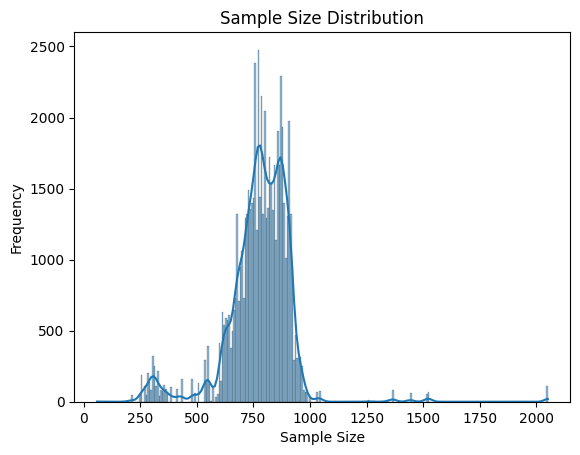

14126    (array([60.86666667]), array([69.38333333]))
14127    (array([60.86666667]), array([69.38333333]))
14128    (array([60.86666667]), array([69.38333333]))
14129    (array([60.86666667]), array([69.38333333]))
14130    (array([60.86666667]), array([69.38333333]))
                             ...                     
61591    (array([71.88333333]), array([77.96666667]))
61592    (array([71.88333333]), array([77.96666667]))
61593    (array([71.88333333]), array([77.96666667]))
61594    (array([71.88333333]), array([77.96666667]))
61595    (array([71.88333333]), array([77.96666667]))
Name: arena_size, Length: 579, dtype: object


In [7]:
sample_sizes = df['sample_size']

# print mean and std
print('Mean:', np.mean(sample_sizes))
print('Std:', np.std(sample_sizes))

# dist plot
sns.histplot(sample_sizes, kde=True)
plt.title('Sample Size Distribution')
plt.xlabel('Sample Size')
plt.ylabel('Frequency')
plt.show()

# idx of pts where sample size is > 1000
idx = np.where(sample_sizes > 1000)[0]
# print arena sizes of these pts
print(df['arena_size'][idx])

In [4]:
""" QUALITY CHECK DATA """ 
nan_idx = np.where(df['obj_q_0'].isna())[0]
not_nan_idx = np.where(~df['obj_q_0'].isna())[0]
nan_dates = (df['date'][nan_idx].unique())
nan_names = (df['name'][nan_idx].unique())

print('Number of NaN rows: ' + str(len(nan_idx)))
print('Animals with NaN rows: ' + str(nan_names))
print('Dates with NaN rows: ' + str(nan_dates))

# remove rows with NaN values
print('Removing nan rows')

df = df.iloc[not_nan_idx]

Number of NaN rows: 0
Animals with NaN rows: []
Dates with NaN rows: []
Removing nan rows


In [5]:
# iterate through each row in df and add a column for 'group' based on the 'signature' split at the firsst '_'
df['signature'] = df['signature'].astype(str)
df['group'] = df['signature'].apply(lambda x: str(x.split('_')[0]))
# if the word 'ANT' is in the signature, then the group is 'ANT', if its 'B6' then the group is 'B6' if its 'NON' then the group is 'NON'
df['group'] = df['group'].apply(lambda x: 'B6' if 'B6' in x else x)
df['group'] = df['group'].apply(lambda x: 'NON' if 'NON' in x else x)
df['group'] = df['group'].apply(lambda x: 'ANT' if 'ANT' in x else x)

In [6]:
df['group'].unique()

array(['ANT', 'B6', 'NON'], dtype=object)

In [7]:
""" FILTERING """

""" REMOVE FIELD WITH LOW COVERAGE % """
# remove rows with field_coverage < 0.1
# df = df[df['field_coverage'] >= 0.1]

""" ONLY KEEPING MAIN FIELD """
# remove rows where field_id is not 1 and score is not 'whole' or 'spike_density'
# df = df[(df['field_id'] == 1) | (df['score'] == 'whole') | (df['score'] == 'spike_density')]

""" CHOOSING ANGLE FOR EACH ROW """
# for each row, choose lowest quantile from ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
# df['obj_q'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].min(axis=1)
df['obj_q'] = df['obj_q_NO']
df['obj_a'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].idxmin(axis=1)
# convert obj_a to degrees
df['obj_a'] = df['obj_a'].apply(lambda x: int(x.split('_')[2]))
# use obj_wass with angle of min quantile
df['obj_w'] = df.apply(lambda x: x['obj_wass_' + str(x['obj_a'])], axis=1)

""" ASSESSING SIG FOR EACH ROW AT EACH ANGLE """
# obj_s_rows = ['obj_s_0', 'obj_s_90', 'obj_s_180', 'obj_s_270']
# obj_q_rows = ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
# for i in range(len(obj_s_rows)):
#     obj_q_x = obj_q_rows[i]
#     df[obj_s_rows[i]] = df[obj_q_x].apply(lambda x: 1 if x < quantile_threshold else 0)


# df2 = df[df['score'] == 'whole'].copy()
df2 = df.copy()
# group_by_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']
# df2 = df2.groupby(group_by_cell).mean().reset_index()
cts = df2[df2['spike_count'] > 30000]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Spike count upper of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(30000 , str(len(df2[df2['spike_count'] > 30000])), 
                       cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['spike_count'] < 100]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Spike count lower of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(100 , str(len(df2[df2['spike_count'] < 100])),
                          cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['information'] < 0.25]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Spatial info of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(0.25 , str(len(df2[df2['information'] < 0.25])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['selectivity'] < 5]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Selectivity of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(5 , str(len(df2[df2['selectivity'] < 5])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['iso_dist'] < 5]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Isolation distance of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(5 , str(len(df2[df2['iso_dist'] < 5])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['firing_rate'] > 20]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Firing rate of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(20 , str(len(df2[df2['firing_rate'] > 20])),
                            cts['ANT'], cts['B6'], cts['NON']))
cts = df2[df2['spike_width'] < 0.00005]['group'].value_counts()
for nm in ['B6', 'NON', 'ANT']:
    if nm not in cts:
        cts[nm] = 0
print('Spike width of {} would drop {} cells including {} ANT, {} B6 and {} NON'.format(0.00005 , str(len(df2[df2['spike_width'] < 0.00005])),
                            cts['ANT'], cts['B6'], cts['NON']))

# drop spike count column 
df2 = df2.drop(columns=['spike_count'])
# rename spike_count.1 to spike_count
df2 = df2.rename(columns={'spike_count.1': 'spike_count'})

new_df2 = []
new_df2_2 = []
new_df2_3 = []
for scr in ['whole', 'spike_density', 'field','binary']:
    df_use = df[df['score'] == scr]
    gby = df_use.groupby(['group', 'name', 'date','depth', 'unit_id','tetrode','field_id'])
    for grp in gby.groups:
        df_sample = gby.get_group(grp)
        # sort by session_id
        df_sample = df_sample.sort_values(by=['session_id'])
        df_sample2 = df_sample.copy()
        df_sample3 = df_sample.copy()
        # get previous object location
        prev_obj_loc = df_sample['object_location'].shift(1)
        # get 2nd previous object location
        prev_obj_loc2 = df_sample2['object_location'].shift(2)
        # get future object location
        future_obj_loc = df_sample['object_location'].shift(-1)
        # for
        # print(df_sample['object_location'], prev_obj_loc)
        df_sample['prev_obj_loc'] = prev_obj_loc
        df_sample2['prev_obj_loc2'] = prev_obj_loc2
        df_sample3['future_obj_loc'] = future_obj_loc
        # drop nan rows
        df_sample = df_sample.dropna(subset=['prev_obj_loc'])
        df_sample2 = df_sample2.dropna(subset=['prev_obj_loc2'])
        df_sample3 = df_sample3.dropna(subset=['future_obj_loc'])
        # assert 'session_1' not in df_sample['session_id'].values
        new_df2.append(df_sample)
        new_df2_2.append(df_sample2)
        new_df2_3.append(df_sample3)
new_df2 = pd.concat(new_df2)
new_df2_2 = pd.concat(new_df2_2)
new_df2_3 = pd.concat(new_df2_3)
# # df_unfiltered = df2.copy()
# # df_unfiltered.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_unfiltered.xlsx')

# df2 = df2[df2['spike_count'] < 30000]
# df2 = df2[df2['spike_count'] > 100]
# df2 = df2[df2['information'] > 0.25]
# df2 = df2[df2['selectivity'] > 5]
df2 = df2[df2['iso_dist'] > 5]
new_df2 = new_df2[new_df2['iso_dist'] > 5]
new_df2_2 = new_df2_2[new_df2_2['iso_dist'] > 5]
new_df2_3 = new_df2_3[new_df2_3['iso_dist'] > 5]
# df2 = df2[df2['firing_rate'] < 80]
# df2 = df2[df2['spike_width'] > 0.00005]

print('Remaining cells: ' + str(len(df2)) + ' of which ' + str(len(df2[df2['group'] == 'ANT'])) + ' ANT, ' + str(len(df2[df2['group'] == 'B6'])) + ' B6 and ' + str(len(df2[df2['group'] == 'NON'])) + ' NON')
df = df2.copy()

Spike count upper of 30000 would drop 500 cells including 175 ANT, 61 B6 and 264 NON
Spike count lower of 100 would drop 627 cells including 95 ANT, 504 B6 and 28 NON
Spatial info of 0.25 would drop 25301 cells including 16251 ANT, 2758 B6 and 6292 NON
Selectivity of 5 would drop 20157 cells including 11702 ANT, 3035 B6 and 5420 NON
Isolation distance of 5 would drop 8816 cells including 5437 ANT, 1771 B6 and 1608 NON
Firing rate of 20 would drop 21145 cells including 15741 ANT, 1190 B6 and 4214 NON
Spike width of 5e-05 would drop 684 cells including 437 ANT, 144 B6 and 103 NON
Remaining cells: 55704 of which 31928 ANT, 12417 B6 and 11359 NON


In [8]:
# df['session_id'].unique()
df.columns
df = df[df['session_id'] != 'session_8']

In [10]:
# new_df2[new_df2['session_id'] == 'session_1']['prev_obj_loc'].value_counts()

In [9]:
# save
df2.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_filtered_keep_swapped2.xlsx')

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

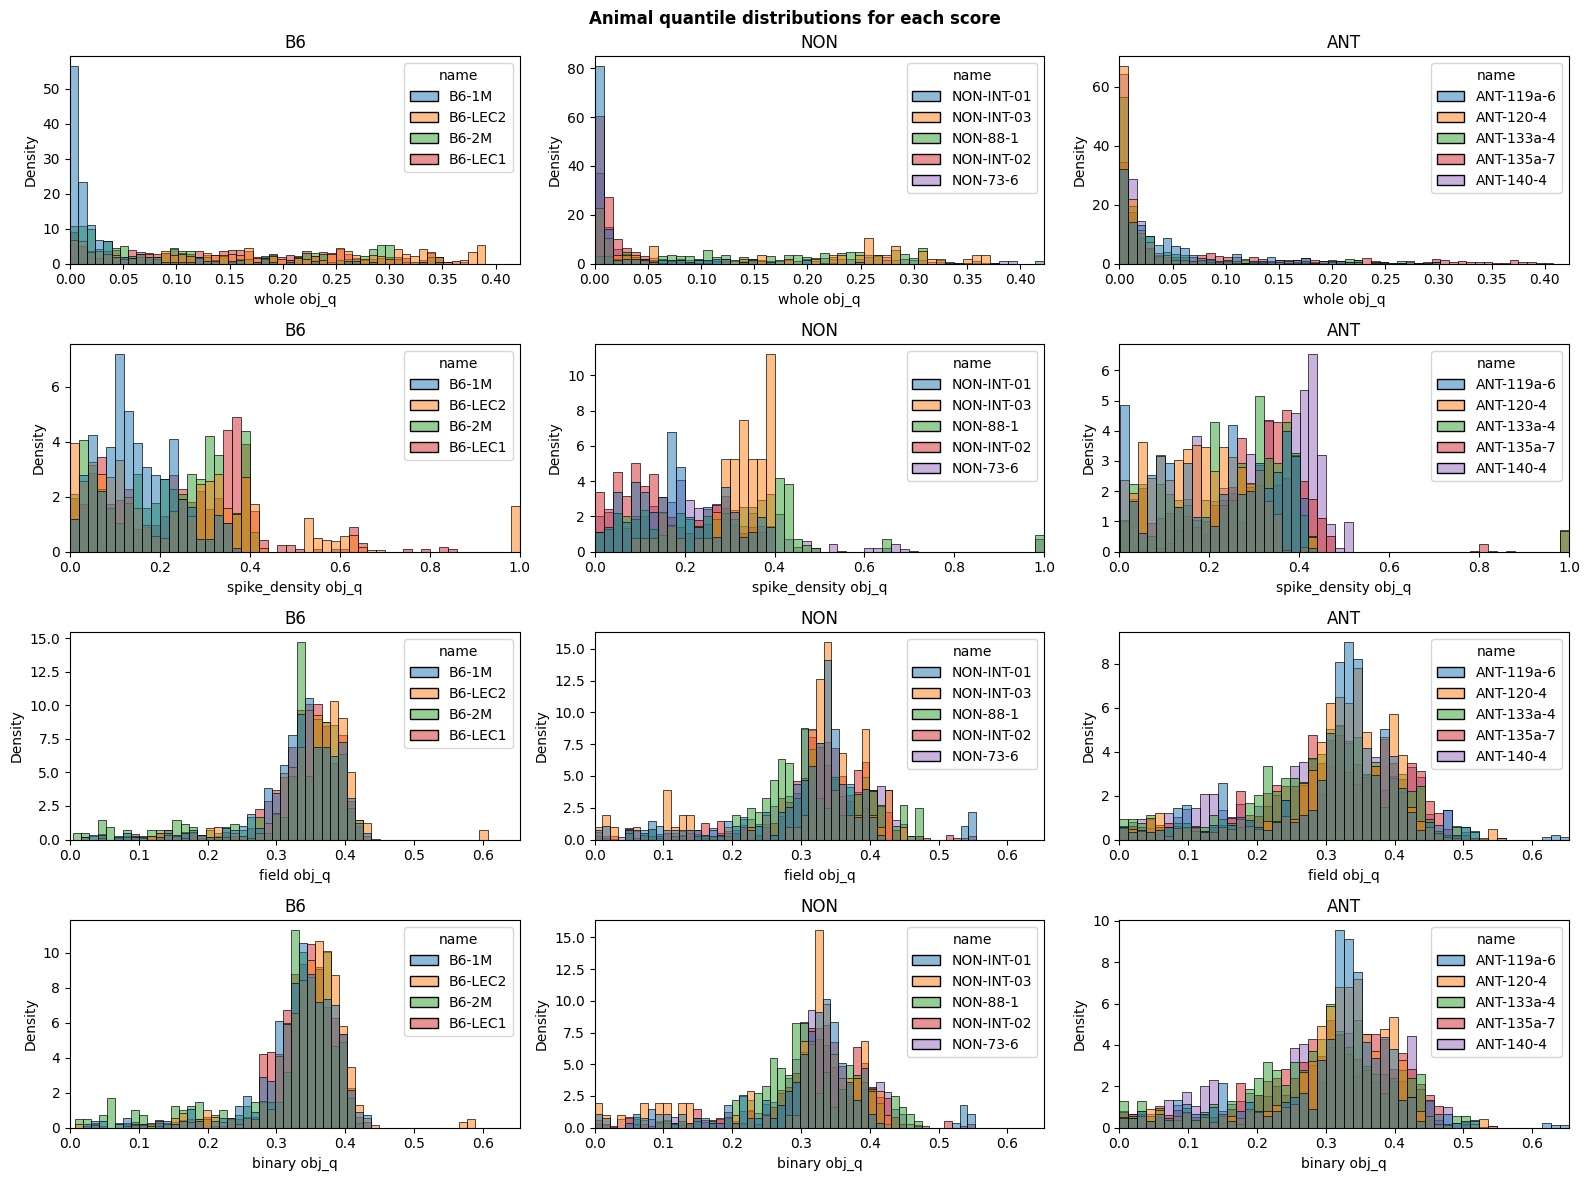

In [9]:
fig = plt.figure(figsize=(16, 12))

j = 1
for scr in ['whole','spike_density','field','binary']:
    mxs = []
    axs = []
    for i in ['B6','NON','ANT']:
        ax = fig.add_subplot(4, 3, j)

        df_to_use = df2[df2['group'] == i]
        # plt.hist(df_to_use[df_to_use['score'] == 'whole']['obj_w'], bins=100)

        # if i == 'B6':
        #     desired_order = ['B6-LEC1', 'B6-1M', 'B6-2M', 'B6-LEC2']
        #     df_to_use.loc[:, 'name'] = pd.Categorical(df_to_use['name'], categories=desired_order, ordered=True)
        # elif i == 'NON':
        #     desired_order = ['NON-INT-01', 'NON-88-1', 'NON-73-6', 'NON-INT-02', 'NON-INT-03']
        #     df_to_use.loc[:, 'name'] = pd.Categorical(df_to_use['name'], categories=desired_order, ordered=True)

            
        sns.histplot(data=df_to_use[df_to_use['score'] == scr], x='obj_q', bins=50, hue='name', kde=False, ax=ax, stat='density', common_norm=False)
        ax.set_title(i)
        ax.set_xlabel(str(scr) + ' obj_q')
        mxs.append(df_to_use[df_to_use['score'] == scr]['obj_q'].max())
        axs.append(ax)

        j += 1
    
    for ax in axs:
        ax.set_xlim(0, max(mxs))

fig.suptitle('Animal quantile distributions for each score', x=0.5, fontweight='bold')
fig.tight_layout()
plt.show()

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

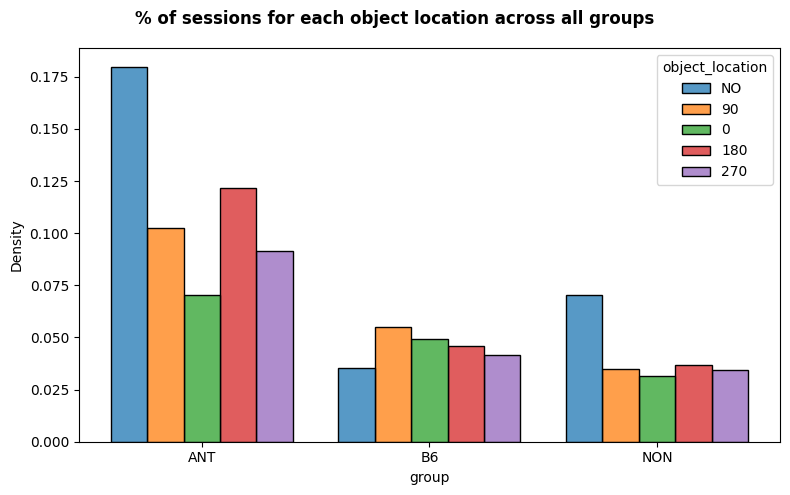

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

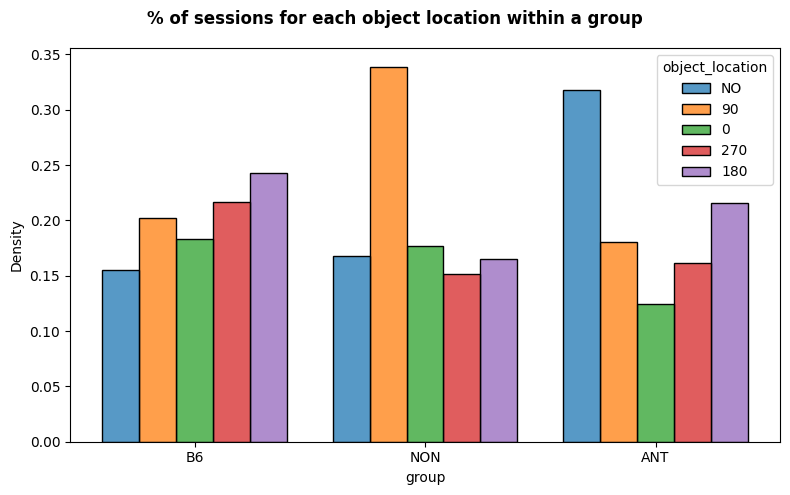

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

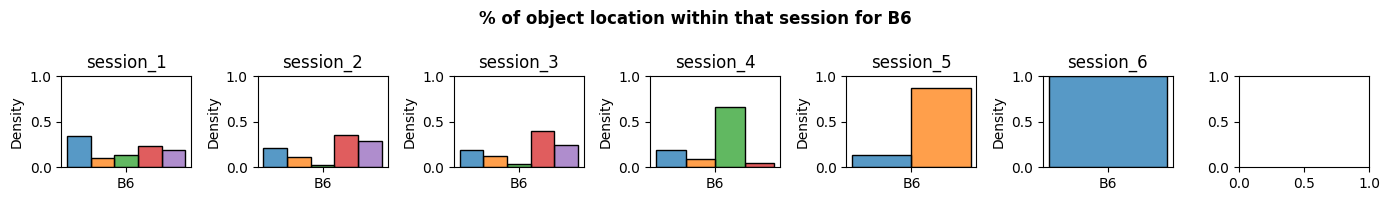

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

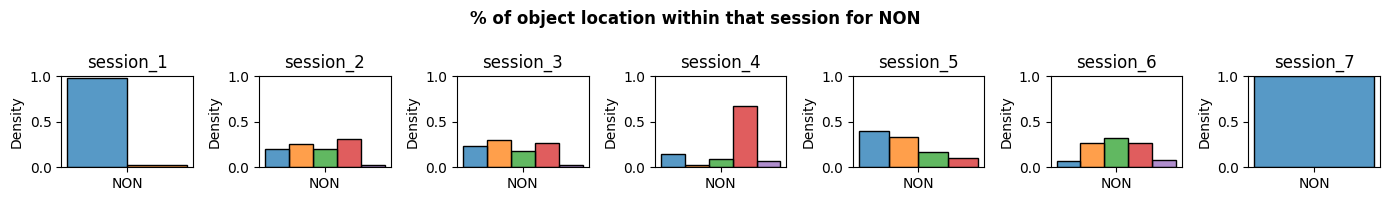

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

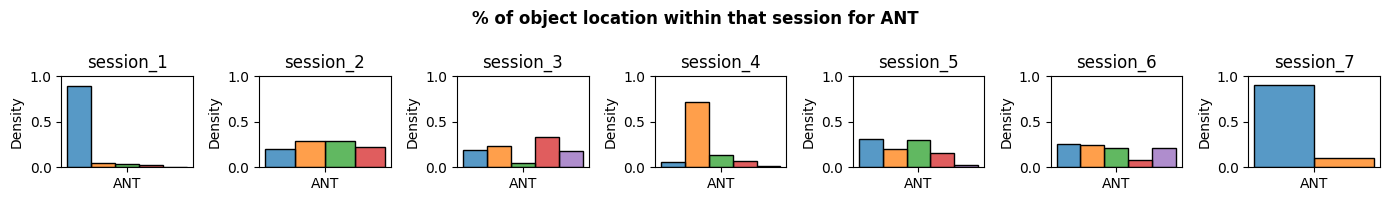

In [10]:
fig = plt.figure(figsize=(8, 5))
dfuse = df2[df2['score'] == 'whole']
obj_order = ['0', '90', '180', '270', 'NO']
grp_order = ['B6', 'NON', 'ANT']
# reorder dfuse based on object_location
dfuse.loc[:, 'object_location'] = pd.Categorical(dfuse['object_location'], categories=obj_order, ordered=True)
dfuse.loc[:, 'group'] = pd.Categorical(dfuse['group'], categories=grp_order, ordered=True)
sns.histplot(data=dfuse, x='group', multiple='dodge', shrink=0.8, stat='density', common_norm=True, hue='object_location')
ttle = '% of sessions for each object location across all groups'
fig.suptitle(ttle, x=0.5, fontweight='bold')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 5))
for grp in ['B6', 'NON', 'ANT']:
    dfuse = df2[df2['score'] == 'whole']
    dfuse = dfuse[dfuse['group'] == grp]
    obj_order = ['0', '90', '180', '270', 'NO']
    # reorder dfuse based on object_location
    dfuse.loc[:, 'object_location'] = pd.Categorical(dfuse['object_location'], categories=obj_order, ordered=True)
    sns.histplot(data=dfuse, x='group', multiple='dodge', shrink=0.8, stat='density', common_norm=True, hue='object_location')
    ttle = '% of sessions for each object location within a group'
clr_palette_store = sns.color_palette()
clr_palette_settings = sns.color_palette('Set2')
fig.suptitle(ttle, x=0.5, fontweight='bold')
fig.tight_layout()
plt.show()

for grp in ['B6', 'NON', 'ANT']:
    fig = plt.figure(figsize=(14, 2))
    for ses in ['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7']:
        ax = fig.add_subplot(1, 7, int(ses.split('_')[1]))
        if grp == 'B6' and ses == 'session_7':
            pass
        else:
            dfuse = df2[df2['score'] == 'whole']
            dfuse = dfuse[dfuse['group'] == grp]
            dfuse = dfuse[dfuse['session_id'] == ses]
            obj_order = ['0', '90', '180', '270', 'NO']
            # reorder dfuse based on object_location
            dfuse.loc[:, 'object_location'] = pd.Categorical(dfuse['object_location'], categories=obj_order, ordered=True)
            sns.histplot(data=dfuse, x='group', multiple='dodge', shrink=0.8, stat='density', common_norm=True, hue='object_location')
            ax.set_title(ses)
            # turn off legend
            try:
                ax.get_legend().remove()
            except:
                pass
            # turn off x label
            ax.set_xlabel('')
            ax.set_ylim(0, 1)
            
    ttle = '% of object location within that session for {}'.format(grp)
    fig.suptitle(ttle, x=0.5, fontweight='bold')
    fig.tight_layout()
    plt.show()



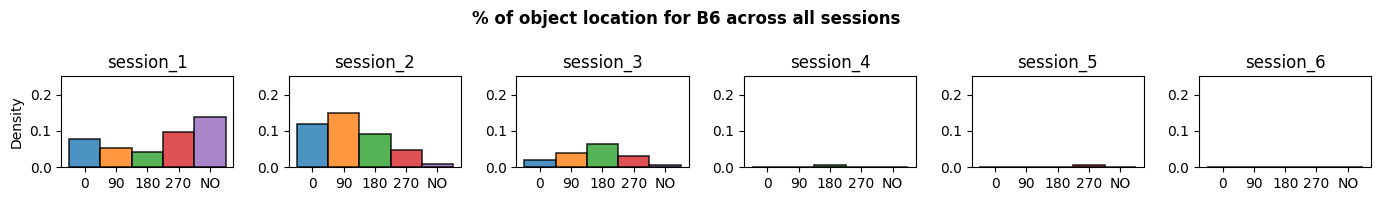

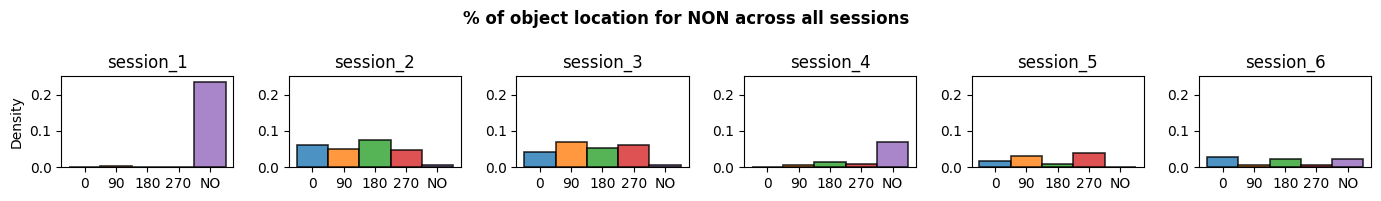

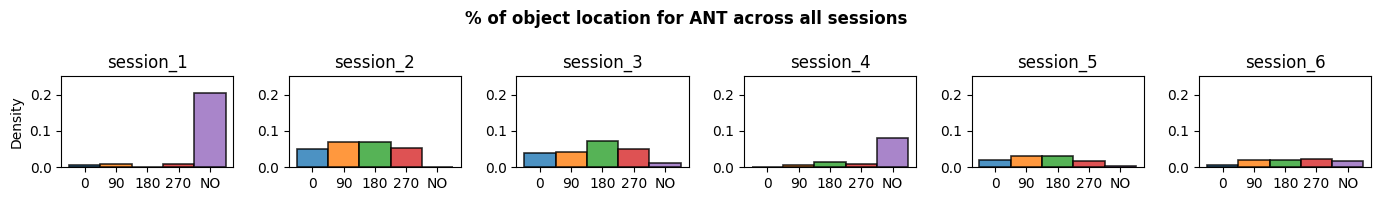

In [11]:
# Define the order of object locations
obj_order = ['0', '90', '180', '270', 'NO']

# Create a figure for the groups
for grp in ['B6', 'NON', 'ANT']:
    # Filter the DataFrame df2 for the current group
    dfuse = df2[df2['score'] == 'whole']
    dfuse = dfuse[dfuse['group'] == grp]
    total_count = len(dfuse)

    # Iterate through sessions and create subplots
    fig, axes = plt.subplots(1, len(['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6']), 
                             figsize=(14, 2))
    
    for i, ses in enumerate(['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6']):
        if grp == 'B6' and ses == 'session_7':
            continue

        # Filter the DataFrame for the current session
        df_session = dfuse[dfuse['session_id'] == ses]

        # Calculate the proportions of each object location for the current session
        obj_loc_counts = [len(df_session[df_session['object_location'] == obj_loc]) for obj_loc in obj_order]
        obj_loc_proportions = [count / total_count for count in obj_loc_counts]

        # Create a bar plot for the current session
        bcolors = clr_palette_store    
        axes[i].bar(obj_order, obj_loc_proportions, color=bcolors, edgecolor='black', linewidth=1.2, alpha=0.8, width=1)
        axes[i].set_title(ses)
        axes[i].set_xlabel('')
        axes[i].set_ylim(0, 0.25)
    # Set a common ylabel for the group
    axes[0].set_ylabel('Density')
    
    # Set the overall title for the group
    plt.suptitle(f'% of object location for {grp} across all sessions', x=0.5, fontweight='bold')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


In [12]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        if data <= 0.05:
            text = '*'
        if data <= 0.01:
            text = '**'
        if data <= 0.001:
            text = '***'
        if data <= 0.0001:
            text = '****'

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    if text != 'n. s.':
        kwargs['weight'] = 'bold'
        kwargs['fontsize'] = 25

    plt.text(*mid, text, **kwargs)

In [13]:
paths = [r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsNON_quantile_indiv_beta_binary.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsNON_quantile_indiv_beta_field.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsNON_quantile_indiv_beta_spike_density.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsNON_quantile_indiv_beta_whole.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsANT_quantile_indiv_beta_whole.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsANT_quantile_indiv_beta_binary.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsANT_quantile_indiv_beta_field.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\B6vsANT_quantile_indiv_beta_spike_density.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\NONvsANT_quantile_indiv_beta_whole.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\NONvsANT_quantile_indiv_beta_binary.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\NONvsANT_quantile_indiv_beta_field.csv",
r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_model_report\NONvsANT_quantile_indiv_beta_spike_density.csv"]

score_beta_ps = {'whole': {}, 'spike_density': {}, 'field': {}, 'binary': {}}

for pth in paths:
    fname = pth.split('\\')[-1]
    score = fname.split('_')[-1].split('.')[0]
    if 'density' in score:
        score = 'spike_density'

    comp_group = fname.split('_')[0]
    a1 = comp_group.split('vs')[0]
    a2 = comp_group.split('vs')[1]

    a12 = np.sort([a1, a2])

    cgroup = a12[0] + '_' + a12[1]
    
    # if 'field' == score:
    #     print(pth)
    data = pd.read_csv(pth)
        # print(data['Unnamed: 0'][3])
        # print(data[['Coefficient', 'Pvalue']])
    #  print(data)
    # stop()
    score_beta_ps[score][cgroup] = data['Pvalue'][1]

In [14]:
score_beta_ps

{'whole': {'B6_NON': 0.145939540447199,
  'ANT_B6': 0.002600698509452,
  'ANT_NON': 0.453035065170564},
 'spike_density': {'B6_NON': 0.312514535834697,
  'ANT_B6': 0.391140709534368,
  'ANT_NON': 0.824733901654829},
 'field': {'B6_NON': 4.00541670467983e-09,
  'ANT_B6': 4.51792181304684e-05,
  'ANT_NON': 0.0824154257882743},
 'binary': {'B6_NON': 7.110709224924441e-09,
  'ANT_B6': 6.44417255064333e-05,
  'ANT_NON': 0.0804805033781407}}

C:\Users\aaoun\AppData\Local\Temp\ipykernel_15060\2733493274.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mns_shuffle = np.array(mns_shuffle)


(3, 1000)
Metric: whole
Group: B6
Empirical: 0.0
Shuffled: -0.01044465935734187 ± 0.10392304845413261
Group: NON
Empirical: 2.2544074479065386
Shuffled: -0.32576187622249486 ± 0.3511281314646868
Group: ANT
Empirical: 0.3757345746510897
Shuffled: -0.25587524533739214 ± 0.18833224709039512
[0.0, 0.0, 0.0]
(array([ True,  True,  True]), array([0., 0., 0.]), 0.016952427508441503, 0.016666666666666666)
Text(0, 0, 'slope: -0.0202')
slope: -0.0202
Text(0, 0, 'slope: 0.0181')
slope: 0.0181
Text(0, 0, 'slope: 0.001')
slope: 0.001


C:\Users\aaoun\AppData\Local\Temp\ipykernel_15060\2733493274.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mns_shuffle = np.array(mns_shuffle)


(3, 1000)
Metric: field
Group: B6
Empirical: -1.044465935734187
Shuffled: -0.06580135395125379 ± 0.42172502889916313
Group: NON
Empirical: 1.502938298604359
Shuffled: -1.6479718444196796 ± 0.4172183516351798
Group: ANT
Empirical: -1.502938298604359
Shuffled: -1.676527672093163 ± 0.2199109980397151
[0.0, 0.0, 0.048]
(array([ True,  True,  True]), array([0.   , 0.   , 0.048]), 0.016952427508441503, 0.016666666666666666)
Text(0, 0, 'slope: -0.0077')
slope: -0.0077
Text(0, 0, 'slope: 0.004')
slope: 0.004
Text(0, 0, 'slope: -0.0056')
slope: -0.0056


C:\Users\aaoun\AppData\Local\Temp\ipykernel_15060\2733493274.py:434: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


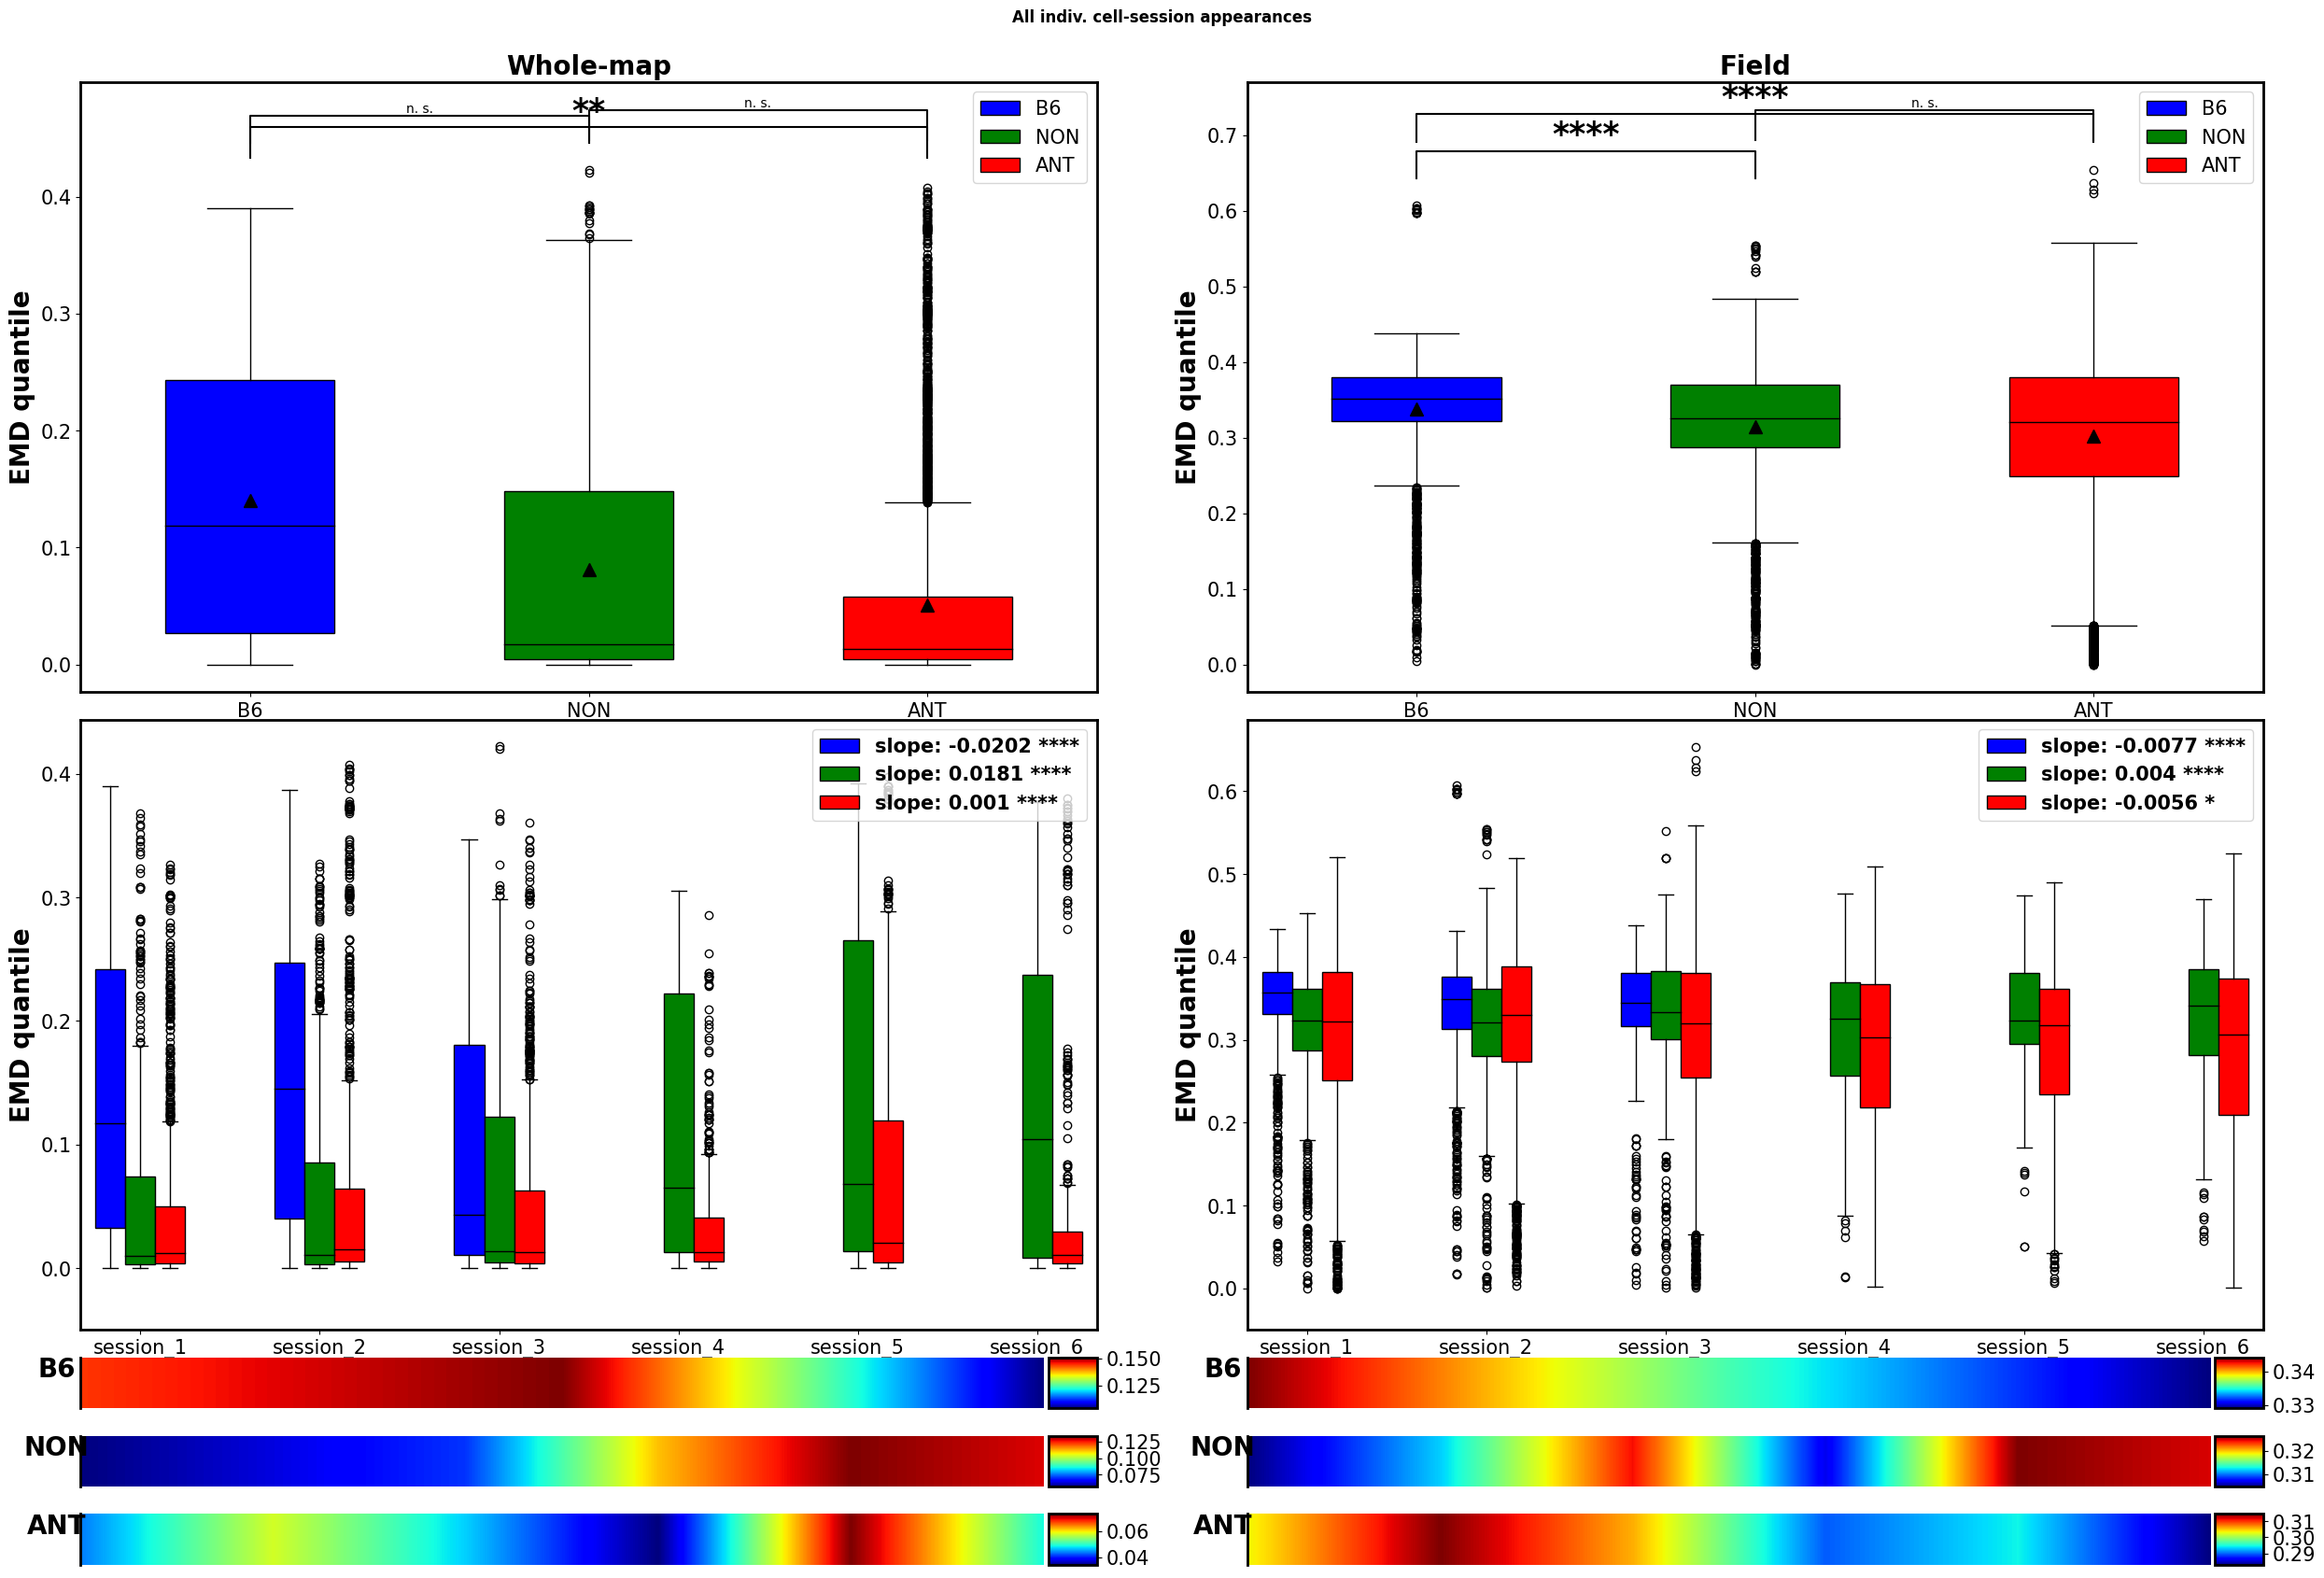

In [19]:
""" Amount of remapping per group """
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats import multitest
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate
from scipy.interpolate import griddata

df = df[df['session_id'] != 'session_7']
df = df[df['session_id'] != 'session_8']
# change session 1 = session 4
# change session 2 = session 5
# change session 3 = session 6

# df.loc[df['session_id'] == 'session_4', 'session_id'] = 'session_1'
# df.loc[df['session_id'] == 'session_5', 'session_id'] = 'session_2'
# df.loc[df['session_id'] == 'session_6', 'session_id'] = 'session_3'
df = df[~((df['session_id'].isin(['session_4', 'session_5', 'session_6', 'session_7'])) & (df['group'] == 'B6'))]

# scores_to_use = ['whole', 'field']
# , 'spike_density', 'binary']
scores_to_use = ['whole', 'field']
# 'firing_rate', 'information']
                #  'spike_density', 'binary']
                #   'centroid', 'firing_rate']
quad_arrange = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1]]
titles_to_use = ['Whole-map', 'Field']
# 'Firing Rate', 'Information']
                #  'Spike Density', 'Binary']
# , 'Centroid', 'Firing Rate']
gps = np.unique(df['session_id'])
gp_labels = ['B6', 'NON', 'ANT']
gp_colors = ['b', 'g', 'r']

# make axes and writing bold
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
# make titles bigger
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
# make axe lines bold
plt.rcParams['axes.linewidth'] = 2

np.random.seed(0)

def _single_shuffle(to_plot_shuffle, sesgp, metric, gplbl):
    vals = to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, 'group'].to_numpy()
    np.random.shuffle(vals)
    to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, 'group'] = vals

    use = to_plot_shuffle[to_plot_shuffle['session_id'] == sesgp]
    use = use[use['group'] == gplbl][metric]
    mn = np.mean(use)
    return mn

fig = plt.figure(figsize=(25, 50))
gs_main = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1, 1])  # Adjust width_ratios and height_ratios as needed


# metric = 'obj_w'
metric = 'obj_q'

for i, score in enumerate(scores_to_use):
    # scores averaged for each session
    if score != 'firing_rate' and score != 'information':
        to_plot = df[df['score'] == score]
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()
    else:
        to_plot = df[df['score'] == 'whole']
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()


    row, col = quad_arrange[i]
    gs_sub = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[row, col], height_ratios=[12,12,1,1,1], hspace=0.1)

    ax = plt.subplot(gs_sub[0])
    axf = ax
    bps = []
    lbls = []
    means = []
    sems = []
    n = []
    if score != 'firing_rate' and score != 'information':
        comps = score_beta_ps[score]
    else:
        comps = {}
    comp_maxs = []
    for k in range(3):
        c = gp_colors[k]
        if score != 'firing_rate' and score != 'information':
            mtouse = metric 
        else:
            mtouse = score
        bp = ax.boxplot(to_plot[to_plot['group'] == gp_labels[k]][mtouse], positions=[k], widths=0.5, 
                    notch=False, patch_artist=True,
                    boxprops=dict(facecolor=c, color='k'),
                    capprops=dict(color='k'),
                    whiskerprops=dict(color='k'),
                    flierprops=dict(color='k', markeredgecolor='k'),
                    medianprops=dict(color='k'),
                    showmeans=True, 
                    meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
        comp_maxs.append(np.max(to_plot[to_plot['group'] == gp_labels[k]][mtouse]))
        for k2 in range(3):
            if k2 != k:
                lbl_pair = np.sort([gp_labels[k], gp_labels[k2]])
                comp_group = lbl_pair[0] + '_' + lbl_pair[1]
                if comp_group not in comps.keys():
                    comps[comp_group] = np.nan

                    if 'B6' in comp_group and 'ANT' in comp_group:
                        if score != 'firing_rate' and score != 'information':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'ANT'])]
                        group_order = ['B6', 'ANT']  # 'B6' becomes the reference group
                    elif 'B6' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate' and score != 'information':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'NON'])]
                        group_order = ['B6', 'NON']
                    elif 'ANT' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate' and score != 'information':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['NON', 'ANT'])]
                        group_order = ['NON', 'ANT']
                    # model_data['group'] = pd.Categorical(model_data['group'], categories=group_order, ordered=True)
                    model_data.loc[:, 'group'] = pd.Categorical(model_data.loc[:, 'group'], categories=group_order, ordered=True)

        means.append(np.mean(to_plot[to_plot['group'] == gp_labels[k]][metric]))
        sems.append(np.std(to_plot[to_plot['group'] == gp_labels[k]][metric]) / np.sqrt(len(to_plot[to_plot['group'] == gp_labels[k]][metric])))
        n.append(len(to_plot[to_plot['group'] == gp_labels[k]][metric]))
                                    
        bps.append(bp['boxes'][0])
        # lbls.append(str(means[k]) + ' ± ' + str(sems[k]) + ' cm, N = ' + str(n[k]))
        lbls.append(gp_labels[k])
        #  + ': N = ' + str(n[k]))
    
    ax.set_xticklabels(gp_labels)
    ax.legend(bps, lbls, loc='upper right')
    ax.set_xlabel('Group')
    ax.set_ylabel('EMD quantile')

    # benjamini hochberg correction
    kys, vals = zip(*comps.items())
    # accepted, pvals_corrected, _, _ = multipletests(vals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    pvals_corrected = vals
    accepted = np.array([True for x in range(len(vals))])

    p_count = 0
    for comp_key, val in comps.items():
        comparison = comps[comp_key]
        if 'ANT' in comp_key and 'B6' in comp_key:
            nme = [0,2]
        elif 'ANT' in comp_key and 'NON' in comp_key:
            nme = [1,2]
        elif 'B6' in comp_key and 'NON' in comp_key:
            nme = [0,1]

        # if accepted[k]:
        barplot_annotate_brackets(nme[0],nme[1],pvals_corrected[p_count],[0,1,2], comp_maxs, maxasterix=5)
        
        p_count += 1

    # ax = fig.add_subplot(2, 2, i+1)
    ax = plt.subplot(gs_sub[1])
    ax1 = ax

    # # every row for that score
    if score != 'firing_rate' and score != 'information':
        to_plot = df[df['score'] == score]
        # to_plot = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
    else:
        to_plot = df[df['score'] == 'whole']
        # to_plot = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # metric = 'firing_rate'
        metric = score
        # to_plot = to_plot[to_plot['depth']]
    to_plot_shuffle = to_plot.copy()



    bps = []
    lbls = []
    shuffle_count = 1000
    mns = [[] for j in range(3)]
    mns_shuffle = [[[] for sc in range(shuffle_count)] for j in range(3)]
    
    group_ses_frs = {'ANT': [], 'B6': [], 'NON': []}
    for k in range(len(gps)):
        # c = gp_colors[k]
        ses_visited = []
        # ses_frs = []
        for j in range(3):
            # get group means + CI
            to_plot_now = to_plot[to_plot['group'] == gp_labels[j]]
            ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]][metric]
            # ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]]['information']
            bp = ax.boxplot(to_plot_now[to_plot_now['session_id'] == gps[k]][metric], positions=[k*3+j*.5], widths=0.5, 
                        notch=False, patch_artist=True,
                        boxprops=dict(facecolor=gp_colors[j],color='k'),
                        capprops=dict(color='k'),
                        whiskerprops=dict(color='k'),
                        flierprops=dict(color='k', markeredgecolor='k'),
                        medianprops=dict(color='k'),
                        showmeans=False, 
                        meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
            if k == 0:
                bps.append(bp['boxes'][0])   

            if len(ses_fr) > 0 and np.mean(ses_fr) == np.mean(ses_fr):       
                group_ses_frs[gp_labels[j]].append(np.mean(ses_fr))

            mn = np.mean(to_plot_now[to_plot_now['session_id'] == gps[k]][metric])
            if mn == mn:
                mns[j].append(mn)

        for j in range(3):
            for sc in range(shuffle_count):
                out = _single_shuffle(to_plot_shuffle, gps[k], metric, gp_labels[j])
                if out == out:
                    mns_shuffle[j][sc].append(out)

    # plt.setp(ax1.get_xticklabels(), visible=False)

    ax = plt.subplot(gs_sub[4])
    # bh_ant_b6 = np.hstack((bh_ant_b6, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_b6, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    ant_fr = group_ses_frs['ANT']
    ant_interp = np.linspace(0, len(ant_fr)-1, shuffle_count)
    ant_fr_smooth = np.interp(ant_interp, np.arange(len(ant_fr)), ant_fr)
    im = ax.imshow(np.expand_dims(ant_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('ANT', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] -.5))
    ax.set_yticks([])
    # ax.set_ylabel('ANT-B6', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[2])
    # bh_b6_non = np.hstack((bh_b6_non, [.5]))
    # ax.imshow(np.expand_dims(bh_b6_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    b6_fr = group_ses_frs['B6']
    b6_interp = np.linspace(0, len(b6_fr)-1, shuffle_count)
    b6_fr_smooth = np.interp(b6_interp, np.arange(len(b6_fr)), b6_fr)
    im = ax.imshow(np.expand_dims(b6_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('B6', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1]-.5))
    ax.set_yticks([])
    # ax.set_ylabel('B6-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[3])
    # # bh_ant_non = np.hstack((bh_ant_non, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    non_fr = group_ses_frs['NON']
    non_interp = np.linspace(0, len(non_fr)-1, shuffle_count)
    non_fr_smooth = np.interp(non_interp, np.arange(len(non_fr)), non_fr)
    im = ax.imshow(np.expand_dims(non_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('NON', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] - .5))
    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_yticks([])
    # ylbl = ax.set_ylabel('ANT-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    # mann kendall
    import pymannkendall as mk
    from statsmodels.stats import multitest
    lbls = []
    lbl_colors = []
    empirical = []
    slopes = []
    ps = []
    mns_shuffle = np.array(mns_shuffle)
    print(mns_shuffle.shape)
    print('Metric: ' + score)
    for j in range(3):
        # polyfit 

        # slp, c = np.polyfit(np.arange(len(mns[j])), mns[j], 1)
        # slopes.append(slp)

        memp = mk.original_test(mns[j])
        empirical.append(memp.z)
        slopes.append(memp.slope)


        shuffled = []
        for sc in range(shuffle_count):
            # if len(mns_shuffle[j,sc]) > 0:
            ses_dist = mns_shuffle[j,sc]
            # mshuffled, c = np.polyfit(np.arange(len(ses_dist)), ses_dist, 1)
            mshuffled = mk.original_test(ses_dist)
            shuffled.append(mshuffled.z)
                # result = mk.original_test(ses_dist)
                # ps.append(result.p)


        # # two sided p-value 
        pgreater = np.sum(np.array(shuffled) < empirical[j]) / len(shuffled) 
        plower = np.sum(np.array(shuffled) > empirical[j]) / len(shuffled)
        pvalue = np.min([pgreater, plower]) * 2
        ps.append(pvalue)
        print('Group: ' + gp_labels[j])
        print('Empirical: ' + str(empirical[j]))
        print('Shuffled: ' + str(np.mean(shuffled)) + ' ± ' + str(np.std(shuffled)))
        # print('p-value: ' + str(np.min([pgreater, plower]) * 2))


        # if empirical[j] > np.mean(shuffled):
        #     tag = 'greater'
        # elif empirical[j] < np.mean(shuffled):
        #     tag = 'lower'
        # lbl = 'Slope is ' + str(tag) + ' than shuffled: ' + str(np.round(memp, 2)) + ' , p = ' + str(np.round(pvalue, 3)) 
        # lbls.append(lbl)

        # lbl = gp_labels[j] + ' 
        lbl = 'slope: ' + str(np.round(memp.slope, 4)) 
        lbl_colors.append('k')
        lbls.append(lbl)

    # result = mk.original_test(ses_dist)
    print(ps)
    out = multitest.multipletests(ps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    cc = 0
    for case in out[0]:
        if case:
            lbl_colors[cc] = 'r'
            # lbls[cc] = lbls[cc] + ' & is sig after BH correction'
        # else:
            # lbls[cc] = lbls[cc] + ' & is NOT sig after BH correction'
        cc += 1
    print(out)

    ax1.legend(bps, lbls, loc='upper right')
    # color label text in legend
    idx = 0
    for text, color in zip(ax1.legend_.get_texts(), lbl_colors):
        # text.set_color(color)
        # set font weight to bold
        if color == 'r':
            text.set_weight('bold')
        pval = out[1][idx]
        if pval <= 0.05:
            astk = '*'
        if pval <= 0.01:
            astk = '**'
        if pval <= 0.001:
            astk = '***'
        if pval <= 0.0001:
            astk = '****'
        if pval > 0.05:
            astk = 'n.s'
        print(text)
        print(text.get_text())
        new_text = str(text.get_text()) + ' ' + str(astk)
        text.set_text(new_text)
        idx += 1

    # ax1.set_title(score)
    # ax.set_xlabel('Session')
    axf.set_title(titles_to_use[i])
    ax1.set_ylabel('EMD quantile')
              
    # ax1.set_xticks(np.arange(len(gps)) * 3 + 1.25/2)
    # ax1.set_xticklabels(gps)
    # ax1.set_xlim([-1.25/2, len(gps) * 3 - 1.25/2])

    ax1.set_xticks(np.arange(len(gps)) * 3 + .5)
    ax1.set_xticklabels(gps)
    ax1.set_ylim(-0.05,)
    # ax1.set_xlim([-.5/2, len(gps) * 3 - .5/2])


fig.suptitle('All indiv. cell-session appearances', fontweight='bold')
# fig.suptitle('Averaged by session', fontweight='bold')
gs_main.tight_layout(fig, rect=[0, 0, 1, 0.98])
# fig.suptitle('Averaged by session')
fig.tight_layout()
plt.show()

# savefig
# folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\Radha-Taub-Retreat"
# fig.savefig(os.path.join(folder, 'boxplots_trends.png'), dpi=1080, bbox_inches='tight')

In [52]:
score_beta_ps

{'whole': {'B6_NON': 0.145939540447199,
  'ANT_B6': 0.002600698509452,
  'ANT_NON': 0.453035065170564},
 'spike_density': {'B6_NON': 0.312514535834697,
  'ANT_B6': 0.391140709534368,
  'ANT_NON': 0.824733901654829},
 'field': {'B6_NON': 4.00541670467983e-09,
  'ANT_B6': 4.51792181304684e-05,
  'ANT_NON': 0.0824154257882743},
 'binary': {'B6_NON': 7.110709224924441e-09,
  'ANT_B6': 6.44417255064333e-05,
  'ANT_NON': 0.0804805033781407}}

In [155]:
new_df3 = df.copy()
threshold = 0.0003
wide_spiking_df = new_df3[new_df3['spike_width'] >= threshold]
narrow_spiking_df = new_df3[new_df3['spike_width'] < threshold]
unique_cell = ['group', 'name', 'depth', 'date', 'stim', 'unit_id','tetrode']
print(len(wide_spiking_df.groupby(unique_cell)), len(narrow_spiking_df.groupby(unique_cell)))

11457 13122


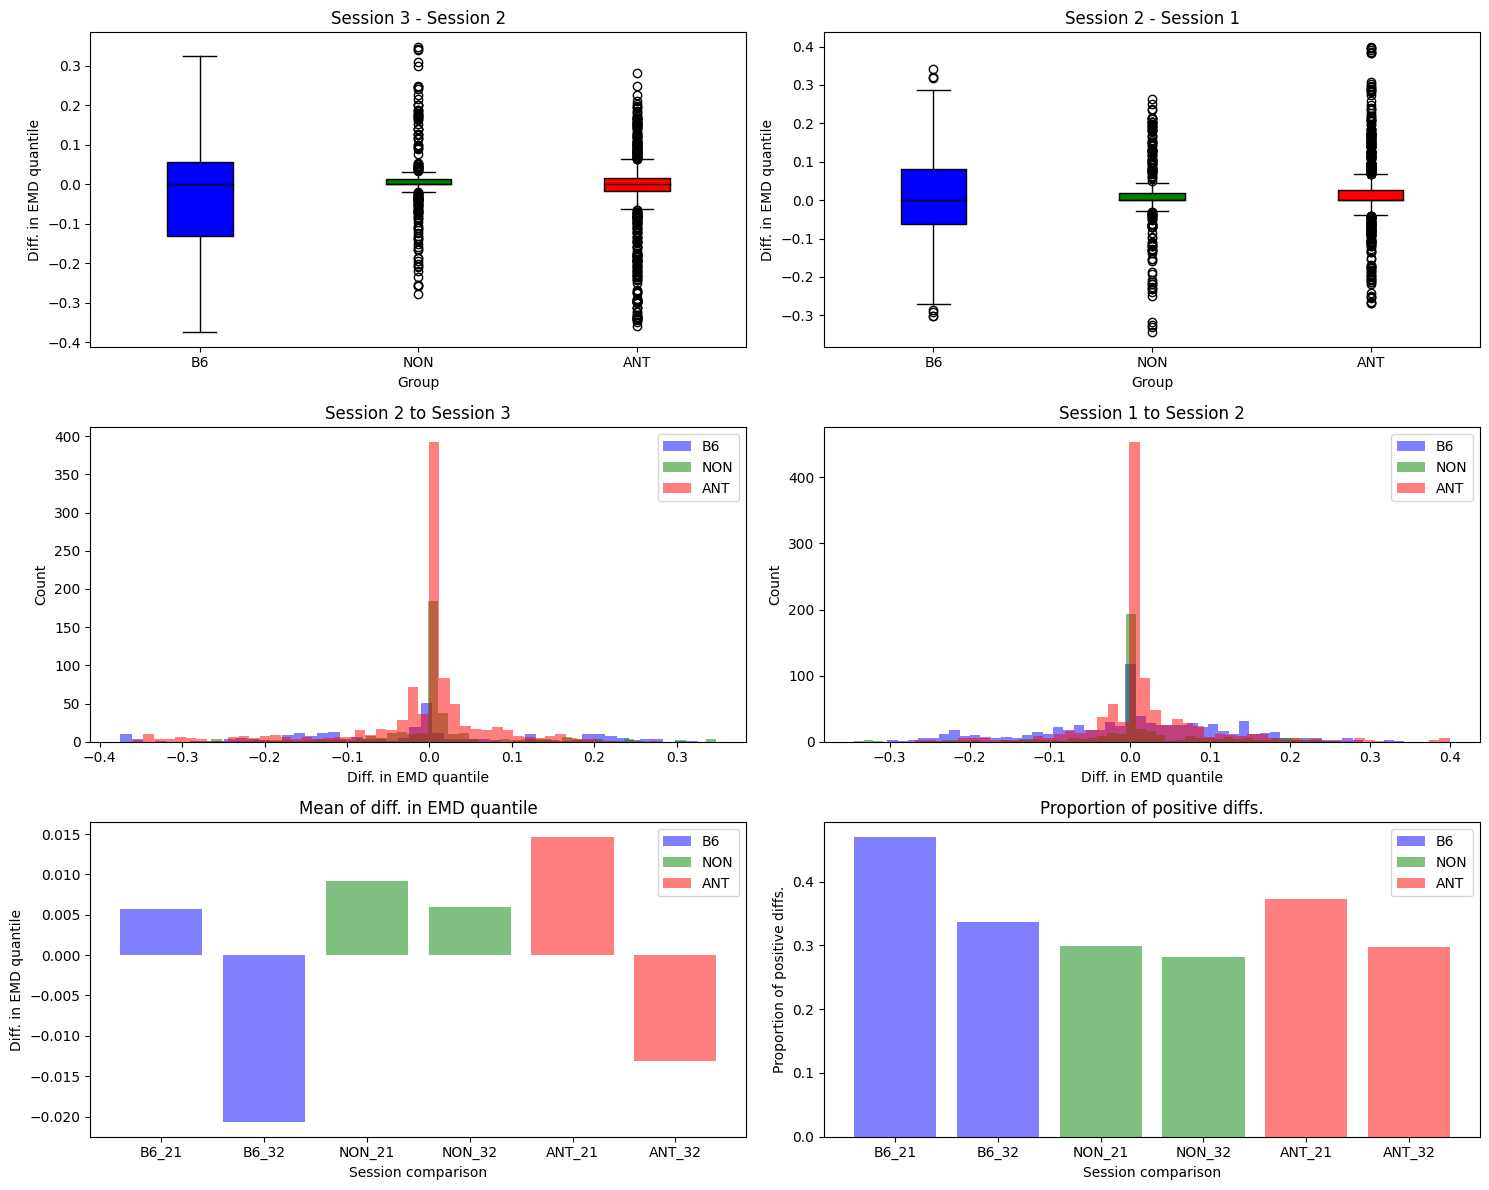

In [11]:
whole_df = new_df2[new_df2['score'] == 'whole']

# group by cell
unique_cell = ['group', 'name', 'depth', 'date', 'unit_id','tetrode','field_id']
grouped = whole_df.groupby(unique_cell)

diffs_32 = {'B6': [], 'NON': [], 'ANT': []}
diffs_21 = {'B6': [], 'NON': [], 'ANT': []}
unabs_diffs_32 = {'B6': [], 'NON': [], 'ANT': []}
unabs_diffs_21 = {'B6': [], 'NON': [], 'ANT': []}
for grp in grouped:
    grp_df = grp[1]
    if len(grp_df['session_id']) > 0:
        if 'session_3' in grp_df['session_id'].to_numpy() and 'session_2' in grp_df['session_id'].to_numpy():
            diff = grp_df[grp_df['session_id'] == 'session_3']['obj_q'].to_numpy() - grp_df[grp_df['session_id'] == 'session_2']['obj_q'].to_numpy()
            if diff < 0.01 and diff > -0.01:
                diff = [0]
            diffs_32[grp_df['group'].unique()[0]].append(diff[0])
            unabs_diffs_32[grp_df['group'].unique()[0]].append(diff[0])
        if 'session_2' in grp_df['session_id'].to_numpy() and 'session_1' in grp_df['session_id'].to_numpy():
            diff = grp_df[grp_df['session_id'] == 'session_2']['obj_q'].to_numpy() - grp_df[grp_df['session_id'] == 'session_1']['obj_q'].to_numpy()
            if diff < 0.01 and diff > -0.01:
                diff = [0]
            diffs_21[grp_df['group'].unique()[0]].append(diff[0])
            unabs_diffs_21[grp_df['group'].unique()[0]].append(diff[0])

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(3, 2, 1)
clrs = ['b', 'g', 'r']
# boxplot with colors
bplot = ax.boxplot([diffs_32['B6'], diffs_32['NON'], diffs_32['ANT']], patch_artist=True, medianprops=dict(color='k'))
for patch, color in zip(bplot['boxes'], clrs):
    patch.set_facecolor(color)

# ax.boxplot([diffs_32['B6'], diffs_32['NON'], diffs_32['ANT']], medianprops=dict(color='k'))

ax.set_xticklabels(['B6', 'NON', 'ANT'])
ax.set_ylabel('Diff. in EMD quantile')
ax.set_xlabel('Group')
ax.set_title('Session 3 - Session 2')

ax = fig.add_subplot(3, 2, 2)
clrs = ['b', 'g', 'r']
# boxplot with colors
bplot = ax.boxplot([diffs_21['B6'], diffs_21['NON'], diffs_21['ANT']], patch_artist=True, medianprops=dict(color='k'))
for patch, color in zip(bplot['boxes'], clrs):
    patch.set_facecolor(color)
ax.set_xticklabels(['B6', 'NON', 'ANT'])
ax.set_ylabel('Diff. in EMD quantile')
ax.set_xlabel('Group')
ax.set_title('Session 2 - Session 1')

ax = fig.add_subplot(3, 2, 3)
ax.hist(diffs_32['B6'], bins=50, alpha=0.5, label='B6', color='b')
ax.hist(diffs_32['NON'], bins=50, alpha=0.5, label='NON', color='g')
ax.hist(diffs_32['ANT'], bins=50, alpha=0.5, label='ANT', color='r')
ax.set_xlabel('Diff. in EMD quantile')
ax.set_ylabel('Count')
ax.legend()
ax.set_title('Session 2 to Session 3')

ax = fig.add_subplot(3, 2, 4)
ax.hist(diffs_21['B6'], bins=50, alpha=0.5, label='B6', color='b')
ax.hist(diffs_21['NON'], bins=50, alpha=0.5, label='NON', color='g')
ax.hist(diffs_21['ANT'], bins=50, alpha=0.5, label='ANT', color='r')
ax.set_xlabel('Diff. in EMD quantile')
ax.set_ylabel('Count')
ax.legend()
ax.set_title('Session 1 to Session 2')

ax = fig.add_subplot(3, 2, 5)
# pairs of session diffs for each group
ax.bar([0, 1], [np.mean(diffs_21['B6']), np.mean(diffs_32['B6'])],color='b', alpha=0.5, label='B6')
ax.bar([2,3], [np.mean(diffs_21['NON']), np.mean(diffs_32['NON'])], color='g', alpha=0.5, label='NON')
ax.bar([4,5], [np.mean(diffs_21['ANT']), np.mean(diffs_32['ANT'])], color='r', alpha=0.5, label='ANT')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['B6_21', 'B6_32', 'NON_21', 'NON_32', 'ANT_21', 'ANT_32'])

ax.set_ylabel('Diff. in EMD quantile')
ax.set_xlabel('Session comparison')
ax.legend()
ax.set_title('Mean of diff. in EMD quantile')


ax = fig.add_subplot(3, 2, 6)
# proportion of postivie vs negative diffs
ax.bar([0, 1], [np.sum(np.array(unabs_diffs_21['B6']) > 0) / len(unabs_diffs_21['B6']), np.sum(np.array(unabs_diffs_32['B6']) > 0) / len(unabs_diffs_32['B6'])],color='b', alpha=0.5, label='B6')
ax.bar([2,3], [np.sum(np.array(unabs_diffs_21['NON']) > 0) / len(unabs_diffs_21['NON']), np.sum(np.array(unabs_diffs_32['NON']) > 0) / len(unabs_diffs_32['NON'])], color='g', alpha=0.5, label='NON')
ax.bar([4,5], [np.sum(np.array(unabs_diffs_21['ANT']) > 0) / len(unabs_diffs_21['ANT']), np.sum(np.array(unabs_diffs_32['ANT']) > 0) / len(unabs_diffs_32['ANT'])], color='r', alpha=0.5, label='ANT')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['B6_21', 'B6_32', 'NON_21', 'NON_32', 'ANT_21', 'ANT_32'])

ax.set_ylabel('Proportion of positive diffs.')
ax.set_xlabel('Session comparison')
ax.legend()
ax.set_title('Proportion of positive diffs.')

fig.tight_layout()
plt.show()



In [384]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
new_accuracies = {}
# use_df = wide_spiking_df

# use_df = df2.copy()
use_df = new_df2.copy()
# use_df = new_df2_2.copy()
# use_df = new_df2_3.copy()

# use_df['session_id'] = use_df['session_id'].astype(str)
# print(len(use_df), len(df2))
# # prev (prev has no ses1 bcs we look into the past by one step)
# # ses1_df = use_df[use_df['session_id'] == 'session_2']
# # other_ses_df = use_df[use_df['session_id'] != 'session_2']
# # curr 
# ses1_df = use_df[use_df['session_id'] == 'session_1']
# other_ses_df = use_df[use_df['session_id'] != 'session_1']
# # drop object location not NO from ses1
# print(len(ses1_df))
# # prev
# # ses1_df = ses1_df[ses1_df['prev_obj_loc'] == 'NO']
# # curr
# ses1_df = ses1_df[ses1_df['object_location'] == 'NO']
# print(len(ses1_df))
# # join 
# use_df = pd.concat([ses1_df, other_ses_df]) 
# print(len(use_df), len(df2))
# # stop()

# use_df = use_df[use_df['object_location'] != 'NO']
# make sessesion_4 = session_1, session_5 = session_2, session_6 = session_3
# use_df.loc[use_df['session_id'] == 'session_4', 'session_id'] = 'session_1'
# use_df.loc[use_df['session_id'] == 'session_5', 'session_id'] = 'session_2'
# use_df.loc[use_df['session_id'] == 'session_6', 'session_id'] = 'session_3'
# use_df = use_df[use_df['session_id'].isin(['session_1', 'session_2','session_3'])]

# # make groups match in size for every score
# arr = []
seed = 42
# for scr in ['whole', 'field', 'spike_density', 'binary']:
#     use_df_sub = use_df[use_df['score'] == scr]
#     min_grp_size = np.min([len(use_df_sub[use_df_sub['group'] == 'B6']), len(use_df_sub[use_df_sub['group'] == 'NON']), len(use_df_sub[use_df_sub['group'] == 'ANT'])])
#     b6_sample = use_df_sub[use_df_sub['group'] == 'B6'].sample(n=min_grp_size, random_state=42)
#     non_sample = use_df_sub[use_df_sub['group'] == 'NON'].sample(n=min_grp_size, random_state=42)
#     ant_sample = use_df_sub[use_df_sub['group'] == 'ANT'].sample(n=min_grp_size, random_state=42)
#     sdf = pd.concat([b6_sample, non_sample, ant_sample])
#     arr.append(sdf)
# use_df = pd.concat(arr)

arr = ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270', 'obj_q_NO']
scs = ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270', 'obj_q_NO']
# , 'obj_q_NO']
for i in range(len(arr)):
    obj_q_score = arr[i]
    sc = scs[i]
    sc = sc.split('_')[-1]
    # print('USING ' + obj_q_score)
    # for ses_use in ['session_1', 'session_2', 'session_3','session_4', 'session_5', 'session_6']:
    for ses_use in ['all']:
        for gp_use in ['B6','NON','ANT']:
            if ses_use not in new_accuracies:
                new_accuracies[ses_use] = {}
            if gp_use not in new_accuracies[ses_use]:
                new_accuracies[ses_use][gp_use] = []
            # print(gp_use)
            if ses_use == 'all':
                X = use_df[(use_df['score'] == 'field') & (use_df['group'] == gp_use)][obj_q_score].to_numpy()
                y = use_df[(use_df['score'] == 'field') & (use_df['group'] == gp_use)]['prev_obj_loc'].to_numpy()
            else:
                X = use_df[(use_df['score'] == 'field') & (use_df['group'] == gp_use) & (use_df['session_id'] != ses_use)][obj_q_score].to_numpy()
                y = use_df[(use_df['score'] == 'field') & (use_df['group'] == gp_use) & (use_df['session_id'] != ses_use)]['prev_obj_loc'].to_numpy()
            # convert 'NO' to 0 and others to 1

            valid_ids = np.where(y == y)
            X = X[valid_ids]
            y = y[valid_ids]
            y = np.where(y == sc, 0, 1)
            X = X.reshape(-1, 1)
            print(len(X))
            # # print(np.unique(y, return_counts=True)[1])
            # X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
            # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            # print(len(X_train), len(X_val), len(X_test))

            # Instantiate StratifiedShuffleSplit for train-validation-test split
            stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)

            # Split the data using stratified sampling
            for train_index, temp_index in stratified_split.split(X, y):
                X_train, X_temp = X[train_index], X[temp_index]
                y_train, y_temp = y[train_index], y[temp_index]

            # Further split the validation and test sets
            stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

            for val_index, test_index in stratified_split.split(X_temp, y_temp):
                X_val, X_test = X_temp[val_index], X_temp[test_index]
                y_val, y_test = y_temp[val_index], y_temp[test_index]

            

            model = LogisticRegression()
            model.fit(X_train, y_train)
            k = 5
            cross_val_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy')
            print("Cross-Validation Scores:", cross_val_scores)
            print("Mean CV Accuracy:", cross_val_scores.mean())
            
            val_predictions = model.predict(X_val)
            val_accuracy = accuracy_score(y_val, val_predictions)
            print("Validation Accuracy:", val_accuracy)

            test_predictions = model.predict(X_test)
            test_accuracy = accuracy_score(y_test, test_predictions)
            print("Test Accuracy:", test_accuracy)

            new_accuracies[ses_use][gp_use].append(test_accuracy)


1318
Cross-Validation Scores: [0.81621622 0.81621622 0.82065217 0.82065217 0.81521739]
Mean CV Accuracy: 0.8177908343125735
Validation Accuracy: 0.8181818181818182
Test Accuracy: 0.8181818181818182
1672
Cross-Validation Scores: [0.88034188 0.88034188 0.88034188 0.88034188 0.87606838]
Mean CV Accuracy: 0.8794871794871796
Validation Accuracy: 0.8804780876494024
Test Accuracy: 0.8804780876494024
4873
Cross-Validation Scores: [0.87701318 0.87829912 0.87829912 0.87829912 0.87829912]
Mean CV Accuracy: 0.8780419316196013
Validation Accuracy: 0.8782489740082079
Test Accuracy: 0.8768809849521204
1318
Cross-Validation Scores: [0.77297297 0.77297297 0.77717391 0.77717391 0.77717391]
Mean CV Accuracy: 0.7754935370152761
Validation Accuracy: 0.7777777777777778
Test Accuracy: 0.7727272727272727
1672
Cross-Validation Scores: [0.84188034 0.84188034 0.84188034 0.84188034 0.83760684]
Mean CV Accuracy: 0.841025641025641
Validation Accuracy: 0.8406374501992032
Test Accuracy: 0.8406374501992032
4873
Cross-

In [50]:
use_df['prev_obj_loc'].value_counts()

NO     3556
90     1518
180    1386
0       882
270     824
Name: prev_obj_loc, dtype: int64

In [381]:
accuracies = new_accuracies.copy()
# accuracies2 = new_accuracies.copy()
# accuracies3 = new_accuracies.copy()

In [28]:
accuracies['all']['B6']

KeyError: 'all'

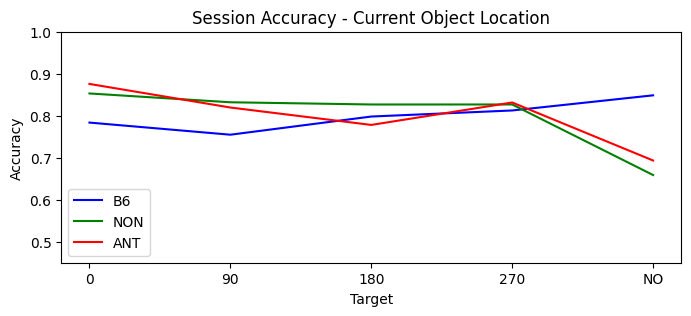

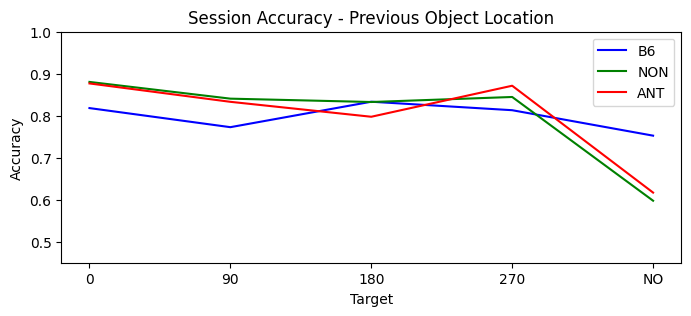

In [68]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
b6acc = new_accuracies['all']['B6']
nonacc = new_accuracies['all']['NON']
antacc = new_accuracies['all']['ANT']
angles = [0, 90, 180, 270, 'NO']
ax.plot(angles, b6acc, label='B6', color='b')
ax.plot(angles, nonacc, label='NON', color='g')
ax.plot(angles, antacc, label='ANT', color='r')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Target')
ax.set_ylim(0.45,1)
ax.set_title('Session Accuracy - Current Object Location')
ax.legend()
plt.show()

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
b6acc = accuracies['all']['B6']
nonacc = accuracies['all']['NON']
antacc = accuracies['all']['ANT']
angles = [0, 90, 180, 270, 'NO']
ax.plot(angles, b6acc, label='B6', color='b')
ax.plot(angles, nonacc, label='NON', color='g')
ax.plot(angles, antacc, label='ANT', color='r')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Target')
ax.set_ylim(0.45,1)
ax.set_title('Session Accuracy - Previous Object Location')
ax.legend()
plt.show()

In [54]:
grp_cts = {'NO': {}, '0': {}, '90': {}, '180': {}, '270': {}}
for grp in ['B6', 'NON', 'ANT']:
    grp_cts['NO'][grp] = []
    grp_cts['0'][grp] = []
    grp_cts['90'][grp] = []
    grp_cts['180'][grp] = []
    grp_cts['270'][grp] = [] 
    for ses in ['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6']:
        cts = df[(df['group'] == grp) & (df['session_id'] == ses)]['object_location'].value_counts()
        # turn to percentages
        cts = cts / np.sum(cts)
        if 'NO' in cts:
            cts_NO = cts['NO']
        else:
            cts_NO = 0
        if '180' in cts:
            cts_180 = cts['180']
        else:
            cts_180 = 0
        if '90' in cts:
            cts_90 = cts['90']
        else:
            cts_90 = 0
        if '270' in cts:
            cts_270 = cts['270']
        else:
            cts_270 = 0
        if '0' in cts:
            cts_0 = cts['0']
        else:
            cts_0 = 0

        grp_cts['NO'][grp].append(cts_NO)
        grp_cts['0'][grp].append(cts_0)
        grp_cts['90'][grp].append(cts_90)
        grp_cts['180'][grp].append(cts_180)
        grp_cts['270'][grp].append(cts_270)
        





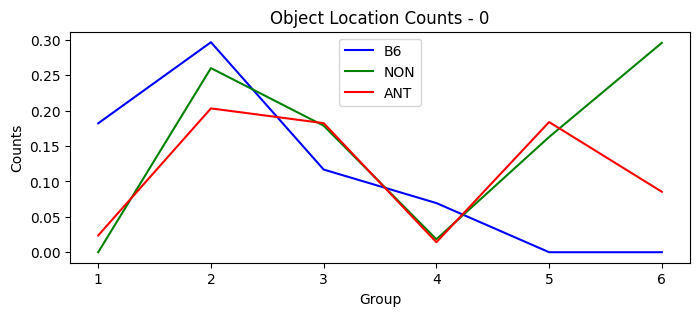

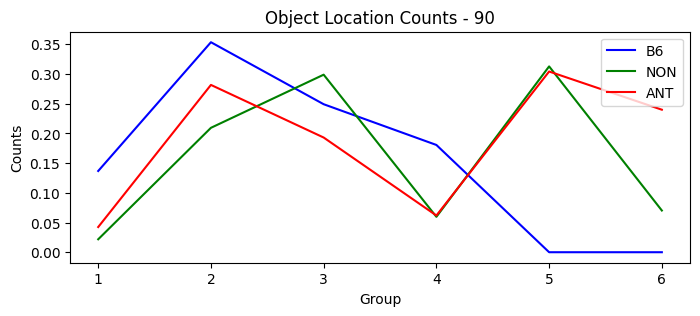

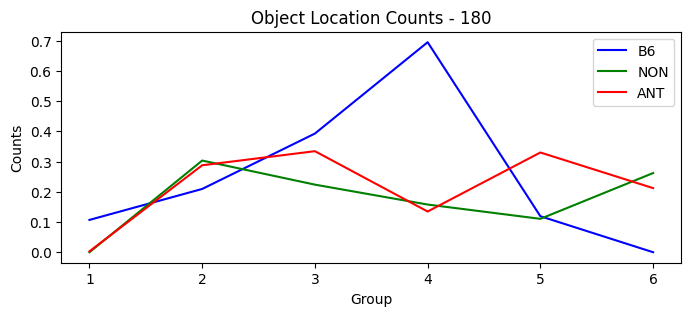

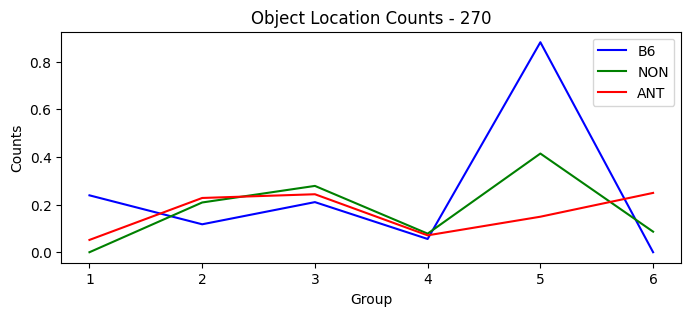

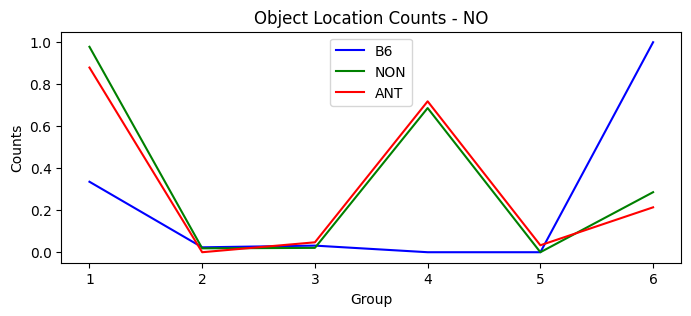

In [55]:
for ky in ['0', '90', '180', '270', 'NO']:

    fig = plt.figure(figsize=(8, 3))

    ax = fig.add_subplot(1, 1, 1)
    NO_B6 = grp_cts[ky]['B6']
    NO_NON = grp_cts[ky]['NON']
    NO_ANT = grp_cts[ky]['ANT']

    ax.plot(np.arange(1,len(NO_B6)+1), NO_B6, label='B6', color='b')
    ax.plot(np.arange(1,len(NO_NON)+1), NO_NON, label='NON', color='g')
    ax.plot(np.arange(1,len(NO_ANT)+1), NO_ANT, label='ANT', color='r')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_xlabel('Group')
    ax.set_title('Object Location Counts - ' + ky)
    ax.legend()
    plt.show()


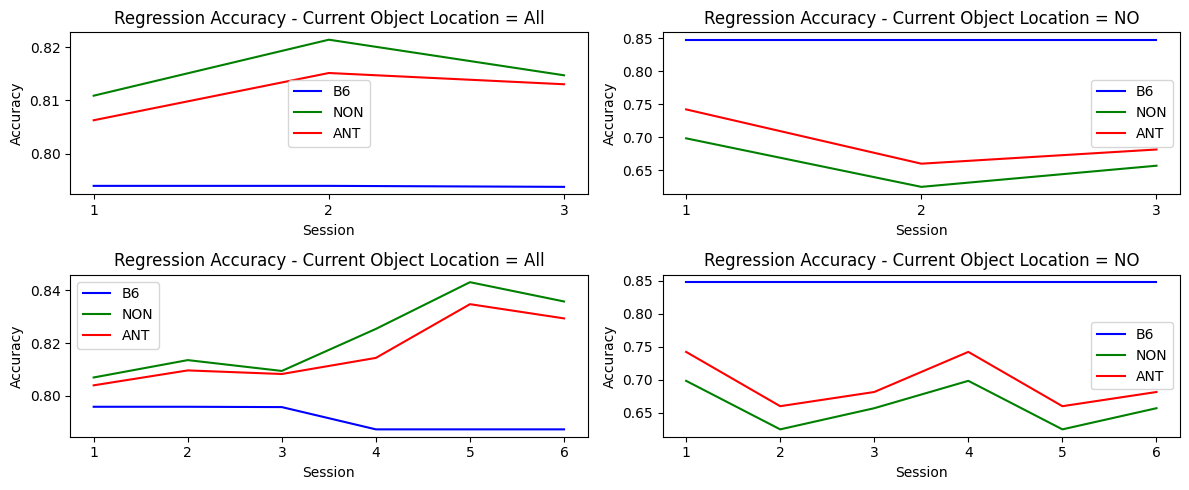

In [39]:
fig = plt.figure(figsize=(12, 5))
for i in range(2):
    if i == 1:
        angle = 'NO'
    else:
        angle = 'All'
    ax = plt.subplot(2,2,i+1)

    ses1 = new_accuracies['session_1']
    ses2 = new_accuracies['session_2']
    ses3 = new_accuracies['session_3']
    ses4 = new_accuracies['session_4']
    ses5 = new_accuracies['session_5']
    ses6 = new_accuracies['session_6']

    # combine ses1 and 4
    ses1['B6'] = np.hstack((ses1['B6'], ses4['B6']))
    ses1['NON'] = np.hstack((ses1['NON'], ses4['NON']))
    ses1['ANT'] = np.hstack((ses1['ANT'], ses4['ANT']))

    ses2['B6'] = np.hstack((ses2['B6'], ses5['B6']))
    ses2['NON'] = np.hstack((ses2['NON'], ses5['NON']))
    ses2['ANT'] = np.hstack((ses2['ANT'], ses5['ANT']))

    ses3['B6'] = np.hstack((ses3['B6'], ses6['B6']))
    ses3['NON'] = np.hstack((ses3['NON'], ses6['NON']))
    ses3['ANT'] = np.hstack((ses3['ANT'], ses6['ANT']))

    if i == 0:
        i = -1

        b6_ses_acc = [np.mean(ses1['B6'][:i]), np.mean(ses2['B6'][:i]), np.mean(ses3['B6'][:i])]
        #  np.mean(ses4['B6'][:i]), np.mean(ses5['B6'][:i]), np.mean(ses6['B6'][:i])]
        non_ses_acc = [np.mean(ses1['NON'][:i]), np.mean(ses2['NON'][:i]), np.mean(ses3['NON'][:i])]
        # np.mean(ses4['NON'][:i]), np.mean(ses5['NON'][:i]), np.mean(ses6['NON'][:i])]
        ant_ses_acc = [np.mean(ses1['ANT'][:i]), np.mean(ses2['ANT'][:i]), np.mean(ses3['ANT'][:i])]
        #  np.mean(ses4['ANT'][:i]), np.mean(ses5['ANT'][:i]), np.mean(ses6['ANT'][:i])]
    else:
        i = -1
        b6_ses_acc = [ses1['B6'][i], ses2['B6'][i], ses3['B6'][i]]
        # ses4['B6'][i], ses5['B6'][i], ses6['B6'][i]]
        non_ses_acc = [ses1['NON'][i], ses2['NON'][i], ses3['NON'][i]]
        #  ses4['NON'][i], ses5['NON'][i], ses6['NON'][i]]
        ant_ses_acc = [ses1['ANT'][i], ses2['ANT'][i], ses3['ANT'][i]]
        #  ses4['ANT'][i], ses5['ANT'][i], ses6['ANT'][i]]

    ax.plot(['1', '2','3'], b6_ses_acc, label='B6', color='b')
    ax.plot(['1', '2','3'], non_ses_acc, label='NON', color='g')
    ax.plot(['1', '2','3'], ant_ses_acc, label='ANT', color='r')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Session')

    ax.set_title('Regression Accuracy - Current Object Location = ' + str(angle))
    ax.legend()

for i in range(2):
    if i == 1:
        angle = 'NO'
    else:
        angle = 'All'
    
    ax = plt.subplot(2,2,i+3)

    ses1 = new_accuracies['session_1']
    ses2 = new_accuracies['session_2']
    ses3 = new_accuracies['session_3']
    ses4 = new_accuracies['session_4']
    ses5 = new_accuracies['session_5']
    ses6 = new_accuracies['session_6']

    if i == 0:
        i = -1

        b6_ses_acc = [np.mean(ses1['B6'][:i]), np.mean(ses2['B6'][:i]), np.mean(ses3['B6'][:i]), np.mean(ses4['B6'][:i]), np.mean(ses5['B6'][:i]), np.mean(ses6['B6'][:i])]
        non_ses_acc = [np.mean(ses1['NON'][:i]), np.mean(ses2['NON'][:i]), np.mean(ses3['NON'][:i]),np.mean(ses4['NON'][:i]), np.mean(ses5['NON'][:i]), np.mean(ses6['NON'][:i])]
        ant_ses_acc = [np.mean(ses1['ANT'][:i]), np.mean(ses2['ANT'][:i]), np.mean(ses3['ANT'][:i]),np.mean(ses4['ANT'][:i]), np.mean(ses5['ANT'][:i]), np.mean(ses6['ANT'][:i])]
    else:
        i = -1
        b6_ses_acc = [ses1['B6'][i], ses2['B6'][i], ses3['B6'][i],ses4['B6'][i], ses5['B6'][i], ses6['B6'][i]]
        non_ses_acc = [ses1['NON'][i], ses2['NON'][i], ses3['NON'][i], ses4['NON'][i], ses5['NON'][i], ses6['NON'][i]]
        ant_ses_acc = [ses1['ANT'][i], ses2['ANT'][i], ses3['ANT'][i], ses4['ANT'][i], ses5['ANT'][i], ses6['ANT'][i]]

    ax.plot(['1', '2','3','4','5','6'], b6_ses_acc, label='B6', color='b')
    ax.plot(['1', '2','3','4','5','6'], non_ses_acc, label='NON', color='g')
    ax.plot(['1', '2','3','4','5','6'], ant_ses_acc, label='ANT', color='r')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Session')

    ax.set_title('Regression Accuracy - Current Object Location = ' + str(angle))
    ax.legend()

fig.tight_layout()
plt.show()

In [72]:
(new_accuracies['all']['ANT'][:])

[0.8756906077348067,
 0.8195211786372008,
 0.7780847145488029,
 0.8314917127071824,
 0.6933701657458563]

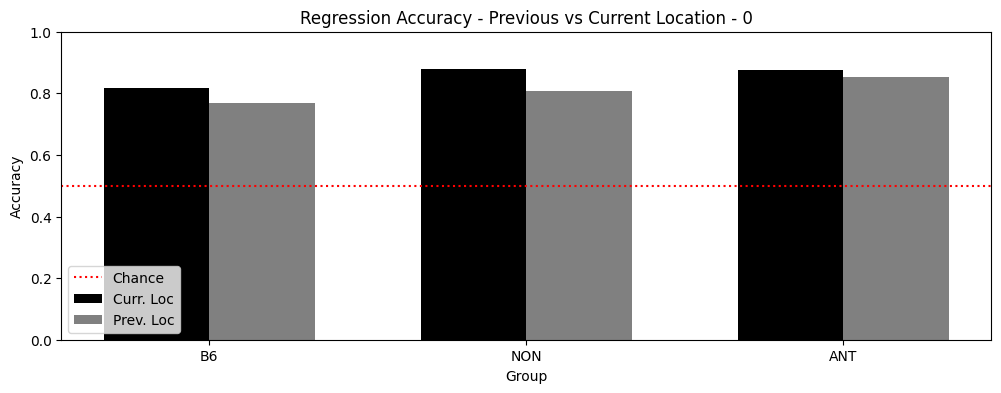

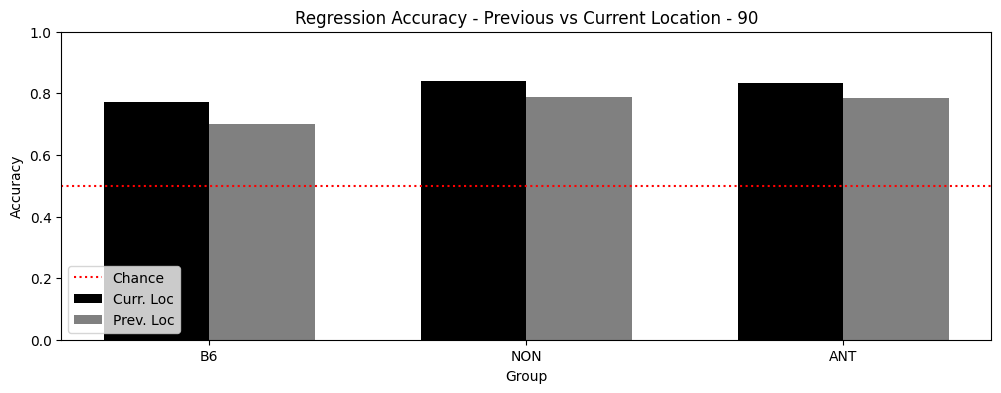

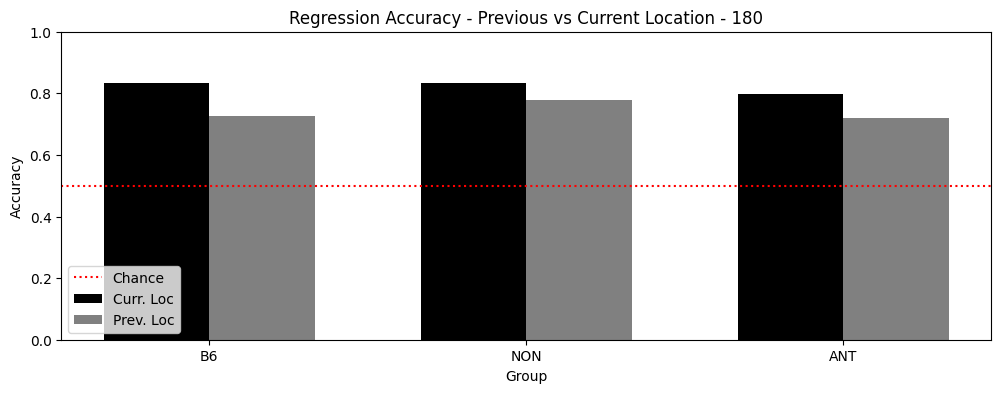

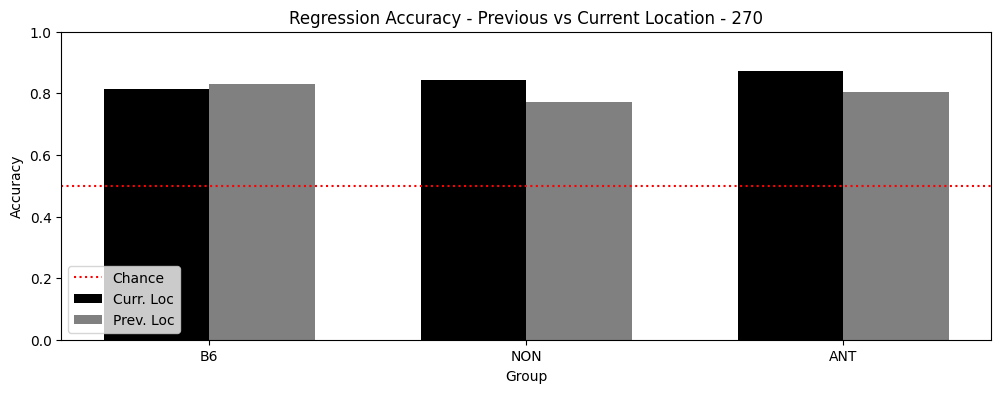

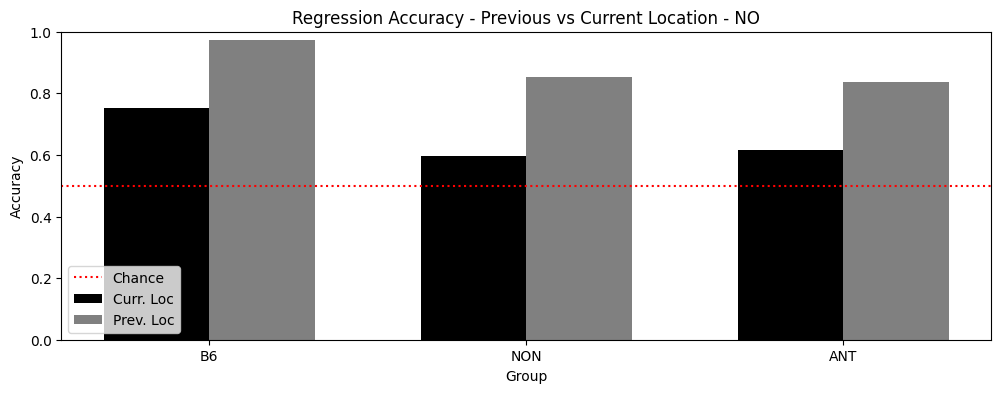

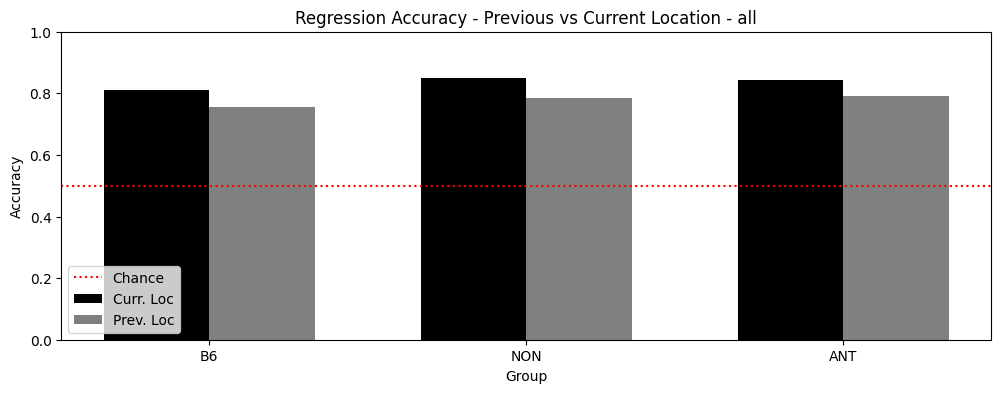

In [385]:
angs = ['0','90','180','270','NO', 'all']
for i in range(len(angs)):


    fig = plt.figure(figsize=(12, 4))

    if angs[i] != 'all':
        b6_old_NO = accuracies['all']['B6'][i]
        non_old_NO = accuracies['all']['NON'][i]
        ant_old_NO = accuracies['all']['ANT'][i]

        b6_new_NO = new_accuracies['all']['B6'][i]
        non_new_NO = new_accuracies['all']['NON'][i]
        ant_new_NO = new_accuracies['all']['ANT'][i]
    else:
        b6_old_NO = np.mean(accuracies['all']['B6'][:4])
        non_old_NO = np.mean(accuracies['all']['NON'][:4])
        ant_old_NO = np.mean(accuracies['all']['ANT'][:4])

        b6_new_NO = np.mean(new_accuracies['all']['B6'][:4])
        non_new_NO = np.mean(new_accuracies['all']['NON'][:4])
        ant_new_NO = np.mean(new_accuracies['all']['ANT'][:4])

    ax = fig.add_subplot(1, 1, 1)
    ax.axhline(0.5, color='r', linestyle=':', label='Chance')

    ax.bar([1,2.5,4], [b6_new_NO, non_new_NO, ant_new_NO], label='Curr. Loc', color='k', width=0.5)
    ax.bar([1.5,3,4.5], [b6_old_NO, non_old_NO, ant_old_NO], label='Prev. Loc', color='grey', width=0.5)

    if angs[i] == 'all':
        # plot the individual points that were used to compute the mean
        b6_old_NO_points = accuracies['all']['B6'][:4]
        non_old_NO_points = accuracies['all']['NON'][:4]
        ant_old_NO_points = accuracies['all']['ANT'][:4]

        b6_new_NO_points = new_accuracies['all']['B6'][:4]
        non_new_NO_points = new_accuracies['all']['NON'][:4]
        ant_new_NO_points = new_accuracies['all']['ANT'][:4]

        # all points go to the same x-axis position as the mean
        b6_old_NO_points_x = np.ones(len(b6_old_NO_points)) * 1
        non_old_NO_points_x = np.ones(len(non_old_NO_points)) * 2.5
        ant_old_NO_points_x = np.ones(len(ant_old_NO_points)) * 4

        b6_new_NO_points_x = np.ones(len(b6_new_NO_points)) * 1.5
        non_new_NO_points_x = np.ones(len(non_new_NO_points)) * 3
        ant_new_NO_points_x = np.ones(len(ant_new_NO_points)) * 4.5

        # # plot the points as errorbars
        # ax.errorbar(b6_old_NO_points_x, b6_old_NO_points, yerr=0.01, fmt='o', color='k', capsize=5)
        # ax.errorbar(non_old_NO_points_x, non_old_NO_points, yerr=0.01, fmt='o', color='k', capsize=5)
        # ax.errorbar(ant_old_NO_points_x, ant_old_NO_points, yerr=0.01, fmt='o', color='k', capsize=5)

        # ax.errorbar(b6_new_NO_points_x, b6_new_NO_points, yerr=0.01, fmt='o', color='grey', capsize=5)
        # ax.errorbar(non_new_NO_points_x, non_new_NO_points, yerr=0.01, fmt='o', color='grey', capsize=5)
        # ax.errorbar(ant_new_NO_points_x, ant_new_NO_points, yerr=0.01, fmt='o', color='grey', capsize=5)

    # # line connecting midpoints
    # ax.plot([1, 2.5, 4], [b6_new_NO, non_new_NO, ant_new_NO], color='k', linestyle='--')
    # ax.plot([1.5, 3, 4.5], [b6_old_NO, non_old_NO, ant_old_NO], color='grey', linestyle='--')

    ylabels = ['B6', 'NON', 'ANT']
    yticks = [1.25, 2.75, 4.25]
    ax.set_xticks(yticks)
    ax.set_xticklabels(ylabels)
    ax.set_ylim(0, 1)

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Group')
    ax.set_title('Regression Accuracy - Previous vs Current Location - ' + angs[i])
    ax.legend(loc='lower left')
    plt.show()

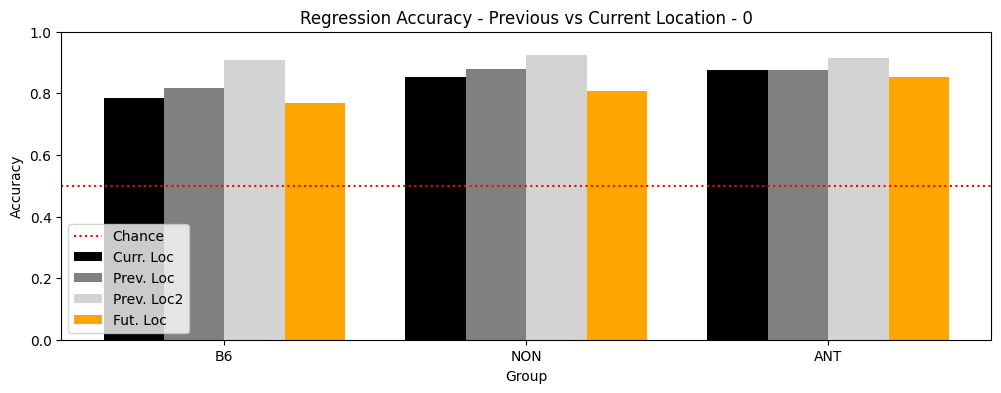

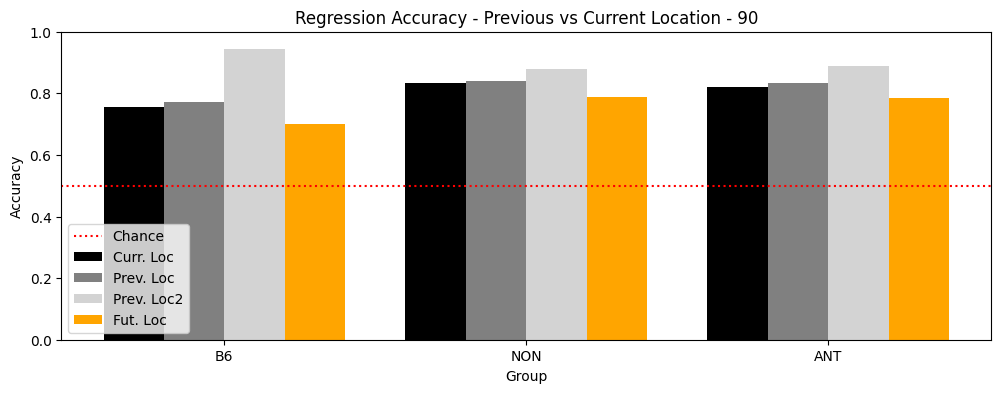

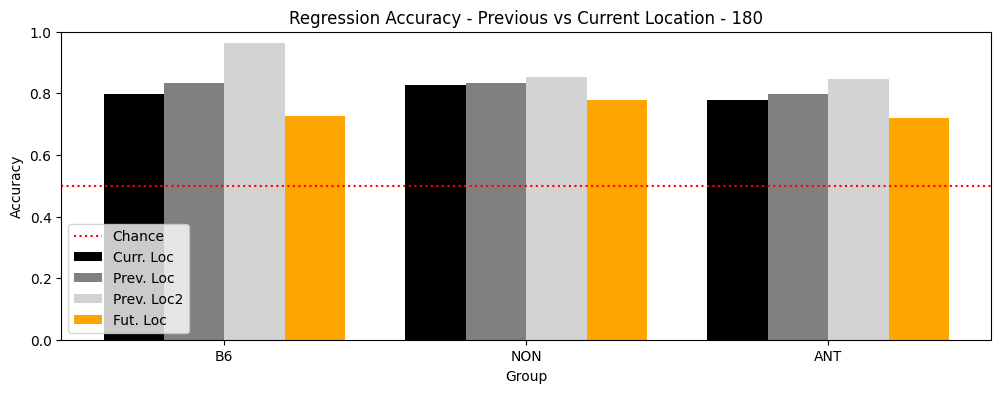

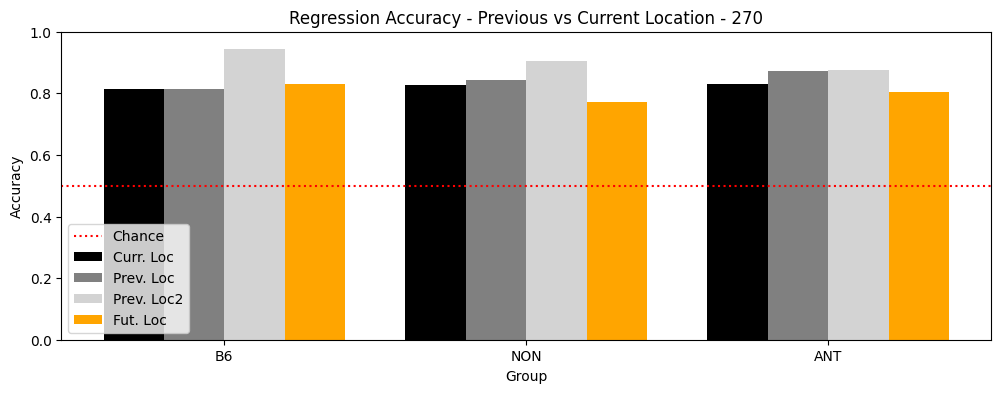

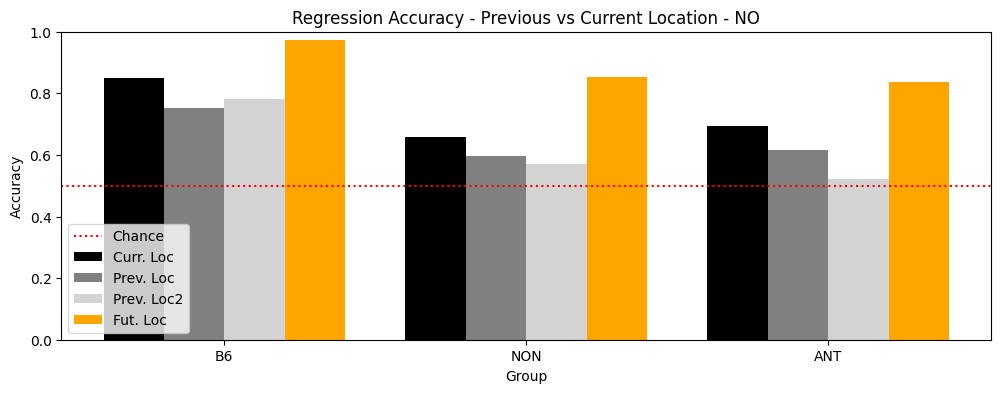

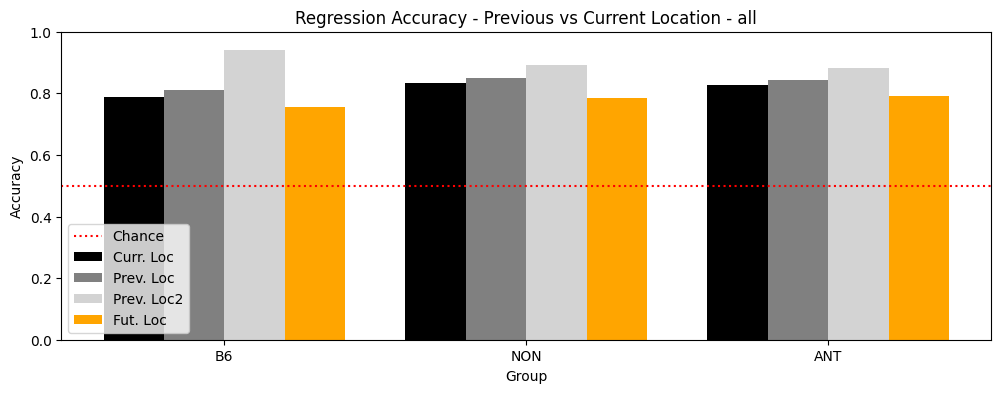

In [101]:
angs = ['0','90','180','270','NO', 'all']
for i in range(len(angs)):


    fig = plt.figure(figsize=(12, 4))

    if angs[i] != 'all':
        b6_old_NO = accuracies['all']['B6'][i]
        non_old_NO = accuracies['all']['NON'][i]
        ant_old_NO = accuracies['all']['ANT'][i]

        b6_new_NO = accuracies2['all']['B6'][i]
        non_new_NO = accuracies2['all']['NON'][i]
        ant_new_NO = accuracies2['all']['ANT'][i]

        b6_new_NO_2 = accuracies3['all']['B6'][i]
        non_new_NO_2 = accuracies3['all']['NON'][i]
        ant_new_NO_2 = accuracies3['all']['ANT'][i]

        b6_new_NO_3 = new_accuracies['all']['B6'][i]
        non_new_NO_3 = new_accuracies['all']['NON'][i]
        ant_new_NO_3 = new_accuracies['all']['ANT'][i]
    else:
        b6_old_NO = np.mean(accuracies['all']['B6'][:4])
        non_old_NO = np.mean(accuracies['all']['NON'][:4])
        ant_old_NO = np.mean(accuracies['all']['ANT'][:4])

        b6_new_NO = np.mean(accuracies2['all']['B6'][:4])
        non_new_NO = np.mean(accuracies2['all']['NON'][:4])
        ant_new_NO = np.mean(accuracies2['all']['ANT'][:4])

        b6_new_NO_2 = np.mean(accuracies3['all']['B6'][:4])
        non_new_NO_2 = np.mean(accuracies3['all']['NON'][:4])
        ant_new_NO_2 = np.mean(accuracies3['all']['ANT'][:4])

        b6_new_NO_3 = np.mean(new_accuracies['all']['B6'][:4])
        non_new_NO_3 = np.mean(new_accuracies['all']['NON'][:4])
        ant_new_NO_3 = np.mean(new_accuracies['all']['ANT'][:4])

    ax = fig.add_subplot(1, 1, 1)
    ax.axhline(0.5, color='r', linestyle=':', label='Chance')

    ax.bar([1,3.5,6], [b6_new_NO, non_new_NO, ant_new_NO], label='Curr. Loc', color='k', width=0.5)
    ax.bar([1.5,4,6.5], [b6_old_NO, non_old_NO, ant_old_NO], label='Prev. Loc', color='grey', width=0.5)
    ax.bar([2,4.5,7], [b6_new_NO_2, non_new_NO_2, ant_new_NO_2], label='Prev. Loc2', color='lightgray', width=0.5)
    ax.bar([2.5,5,7.5], [b6_new_NO_3, non_new_NO_3, ant_new_NO_3], label='Fut. Loc', color='orange', width=0.5)
 

    ylabels = ['B6', 'NON', 'ANT']
    yticks = [1.75, 4.25, 6.75]
    ax.set_xticks(yticks)
    ax.set_xticklabels(ylabels)
    ax.set_ylim(0, 1)

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Group')
    ax.set_title('Regression Accuracy - Previous vs Current Location - ' + angs[i])
    ax.legend(loc='lower left')
    plt.show()

In [32]:
len()

{'all': {'B6': [0.7758620689655172,
   0.6781609195402298,
   0.7298850574712644,
   0.8448275862068966,
   0.9712643678160919],
  'NON': [0.76, 0.744, 0.752, 0.768, 0.976],
  'ANT': [0.8011695906432749,
   0.7514619883040936,
   0.7192982456140351,
   0.7631578947368421,
   0.9649122807017544]}}

In [22]:
accuracies.keys()

dict_keys(['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6'])

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Assuming df is your DataFrame containing the data
for gp_use in ['B6', 'NON', 'ANT']:
    print(gp_use)
    
    filtered_df = new_df2[(new_df2['score'] == 'whole') & (new_df2['group'] == gp_use) 
                          & (new_df2['object_location'] != 'NO')]
    X = filtered_df['obj_q_NO'].to_numpy().reshape(-1, 1)
    y = filtered_df['object_location'].to_numpy()
    
    print(len(X))

    # Convert class labels to numerical values (0, 1, 2, 3 for '0', '90', '180', '270')
    class_mapping = {'0': 0, '90': 1, '180': 2, '270': 3}
    # 'NO': 4}
    y = np.array([class_mapping[label] for label in y])
    print(np.unique(y, return_counts=True)[1])
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = LogisticRegression(max_iter=10000, multi_class='multinomial', solver='lbfgs')
    k = 10
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy')
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())
    
    model.fit(X_train, y_train)

    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print("Validation Accuracy:", val_accuracy)

    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print("Test Accuracy:", test_accuracy)


B6
1332
[309 432 381 210]
Cross-Validation Scores: [0.34042553 0.34042553 0.34408602 0.34408602 0.34408602 0.33333333
 0.33333333 0.33333333 0.34408602 0.34408602]
Mean CV Accuracy: 0.34012811713566693
Validation Accuracy: 0.3
Test Accuracy: 0.275
NON
1396
[327 347 375 347]
Cross-Validation Scores: [0.26530612 0.29591837 0.26530612 0.28571429 0.26530612 0.28571429
 0.24489796 0.32989691 0.21649485 0.29896907]
Mean CV Accuracy: 0.27535240900483904
Validation Accuracy: 0.3157894736842105
Test Accuracy: 0.20476190476190476
ANT
3878
[ 714 1019 1245  900]
Cross-Validation Scores: [0.30147059 0.30882353 0.33455882 0.31985294 0.32103321 0.33948339
 0.32103321 0.33579336 0.34686347 0.32841328]
Mean CV Accuracy: 0.3257325808552203
Validation Accuracy: 0.36769759450171824
Test Accuracy: 0.32130584192439865


In [66]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


Circular Mean Absolute Error (CMAE): 128.67 degrees


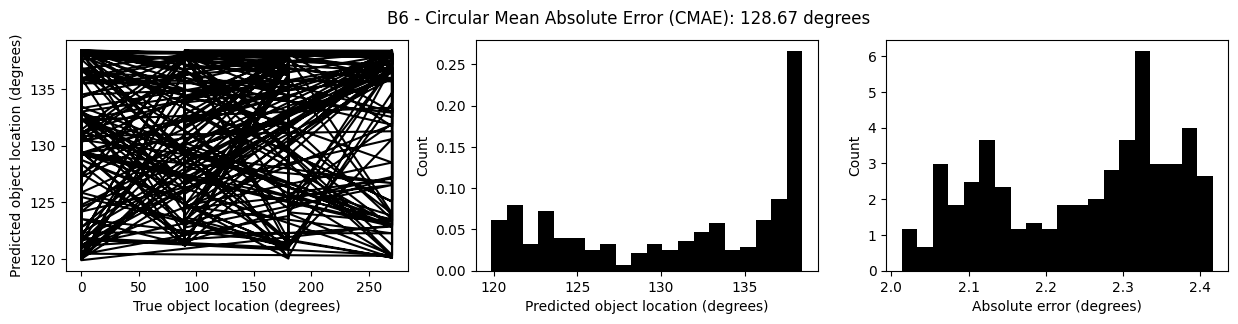

Circular Mean Absolute Error (CMAE): 140.29 degrees


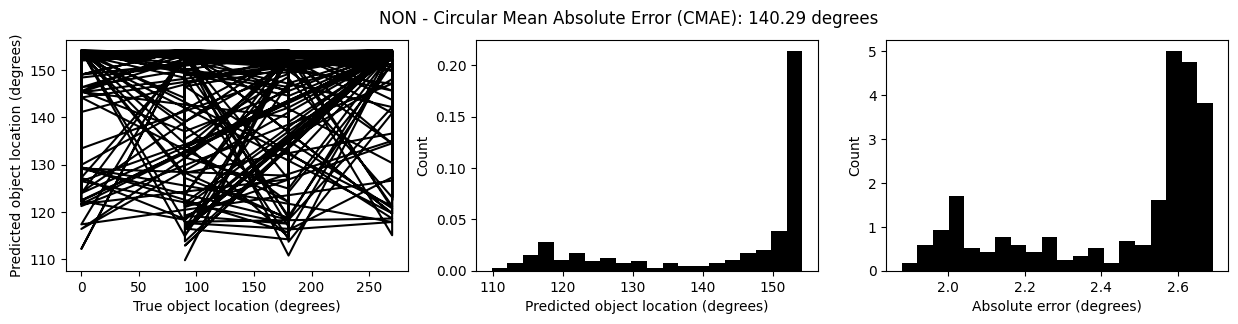

Circular Mean Absolute Error (CMAE): 134.15 degrees


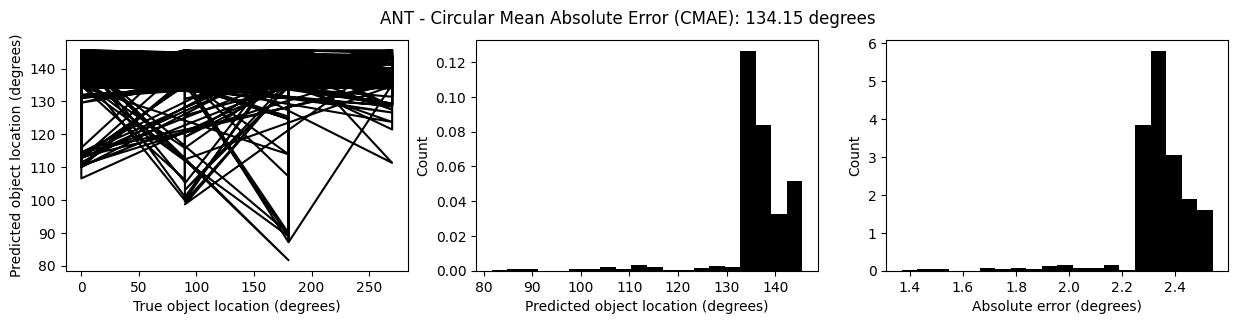

In [67]:
for gp_use in ['B6', 'NON', 'ANT']:
    filtered_df = new_df2[(new_df2['score'] == 'whole') & (new_df2['group'] == gp_use) & (new_df2['prev_obj_loc'] != 'NO')]
    # group by unique cell

    X = filtered_df['obj_q'].to_numpy().reshape(-1, 1)
    y = filtered_df['prev_obj_loc'].to_numpy()

    class_mapping = {'0': 0, '90': 90, '180': 180, '270': 270}
    # 'NO': 0}
    # convert to radians
    y = np.array([class_mapping[label] for label in y])

    # Assuming X represents your beta-distributed quantile inputs and y represents your object locations in degrees (0, 90, 180, 270)
    # Convert circular data to linear format using cosine and sine functions
    X_linear = np.column_stack((np.cos(2 * np.pi * X), np.sin(2 * np.pi * X)))

    # Convert object locations to radians
    y_radians = np.radians(y)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_linear, y_radians, test_size=0.3, random_state=42)
    # Initialize and train the linear regression model


    # # Build the model
    # model = Sequential()
    # model.add(Dense(64, input_shape=(3,), activation='relu'))
    # model.add(Dense(1))  # Output layer for predicting angles

    # # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error')

    # # Train the model
    # model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # loss = model.evaluate(X_test, y_test)
    # print("Mean Squared Error on Test Data:", loss)

    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict object locations in radians
    predicted_radians = model.predict(X_test)
    # Convert predicted radians back to degrees and wrap around the circular range (0 to 360 degrees)
    predicted_degrees = (np.degrees(predicted_radians) + 360) % 360

    # Assuming y_test represents the true object locations in degrees (0, 90, 180, 270)
    # and predicted_degrees represents the predicted object locations in degrees
    # Calculate circular mean absolute error (CMAE) in degrees
    def circular_mean_absolute_error(y_true, y_pred):
        errors = np.abs(np.arctan2(np.sin(np.radians(y_true) - np.radians(y_pred)), np.cos(np.radians(y_true) - np.radians(y_pred))))
        cmae = np.degrees(np.mean(errors))
        return cmae, errors
    # Calculate CMAE for the predictions
    cmae, errors = circular_mean_absolute_error(y_test, predicted_degrees)
    print("Circular Mean Absolute Error (CMAE): {:.2f} degrees".format(cmae))

    


    fig = plt.figure(figsize=(15, 3))
    
    # predicted_degrees = predicted_degrees[np.argsort(errors)]
    # y_test = y_test[np.argsort(errors)]
    # errors = np.sort(errors)

    ax = plt.subplot(1,3,1)
    ax.plot(np.degrees(y_test), predicted_degrees, color='k')
    # errors = errors[np.argsort(y_test)]
    # ax.plot(predicted_degrees, color='k')
    # ax.plot(np.sort(np.degrees(y_test)), color='r')
    # ax.set_ylabel('Object location (degrees)')
    ax.set_xlabel('True object location (degrees)')
    ax.set_ylabel('Predicted object location (degrees)')
    # ax.axvline(x=0, color='r')
    # ax.axvline(x=90, color='r')
    # ax.axvline(x=180, color='r')
    # ax.axvline(x=270, color='r')
    # ax.axhline(y=0, color='r')
    # ax.axhline(y=90, color='r')
    # ax.axhline(y=180, color='r')
    # ax.axhline(y=270, color='r')

    ax = plt.subplot(1,3,2)
    # ax.plot(np.degrees(y_test), errors, color='k')
    ax.hist(predicted_degrees, bins=20, color='k', density=True)
    ax.set_xlabel('Predicted object location (degrees)')
    ax.set_ylabel('Count')
    # ax.axvline(x=0, color='r')
    # ax.axvline(x=90, color='r')
    # ax.axvline(x=180, color='r')
    # ax.axvline(x=270, color='r')

    # ax.set_xlabel('True object location (degrees)')
    # ax.set_ylabel('Absolute error (degrees)')


    ax = plt.subplot(1,3,3)
    ax.hist(errors, bins=20, color='k', density=True)
    ax.set_xlabel('Absolute error (degrees)')
    ax.set_ylabel('Count')

    fig.suptitle(gp_use + ' - Circular Mean Absolute Error (CMAE): {:.2f} degrees'.format(cmae))
    fig.tight_layout
    plt.show()

In [68]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import numpy as np


filtered_df = df[(df['score'] == 'field') & (df['group'] == 'B6') & (df['object_location'] != 'NO')]
X = filtered_df['obj_q'].to_numpy().reshape(-1, 1)
y = filtered_df['object_location'].to_numpy()

class_mapping = {'0': 0, '90': 90, '180': 180, '270': 270}
# convert to radians
y = np.array([class_mapping[label] for label in y])


# Assuming X represents your beta-distributed quantile inputs and y represents your object locations in degrees (0, 90, 180, 270)
# Convert object locations to radians
y_radians = np.radians(y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_radians, test_size=0.3, random_state=42)
# Initialize and train the Kernel Ridge regression model
model = KernelRidge(kernel='rbf', gamma=0.1)  # Radial basis function (RBF) kernel
model.fit(X_train, y_train)
# Predict object locations in radians
predicted_radians = model.predict(X_test)
# Convert predicted radians back to degrees and wrap around the circular range (0 to 360 degrees)
predicted_degrees = (np.degrees(predicted_radians) + 360) % 360


def circular_mean_absolute_error(y_true, y_pred):
    errors = np.abs(np.arctan2(np.sin(np.radians(y_true) - np.radians(y_pred)), np.cos(np.radians(y_true) - np.radians(y_pred))))
    cmae = np.degrees(np.mean(errors))
    return cmae
# Calculate CMAE for the predictions
cmae = circular_mean_absolute_error(y_test, predicted_degrees)
print("Circular Mean Absolute Error (CMAE): {:.2f} degrees".format(cmae))

Circular Mean Absolute Error (CMAE): 126.74 degrees


B6
Circular Mean Absolute Error (CMAE): 99.04 degrees


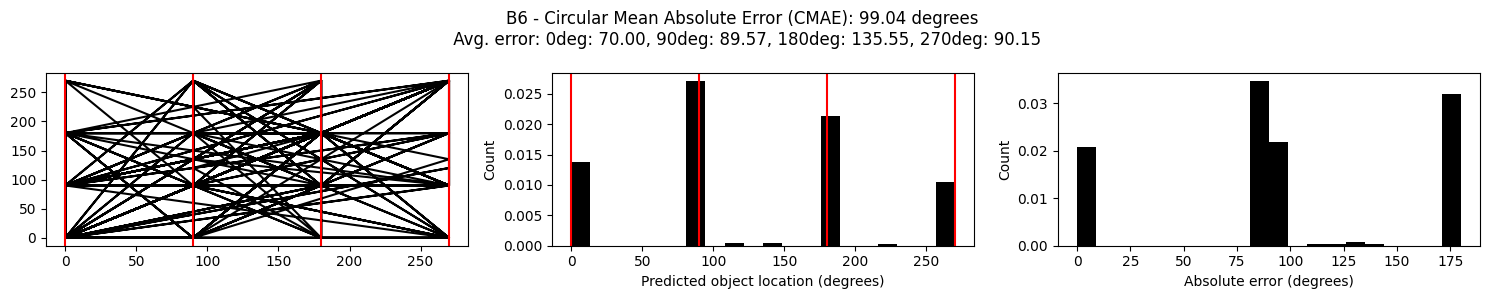

NON
Circular Mean Absolute Error (CMAE): 91.38 degrees


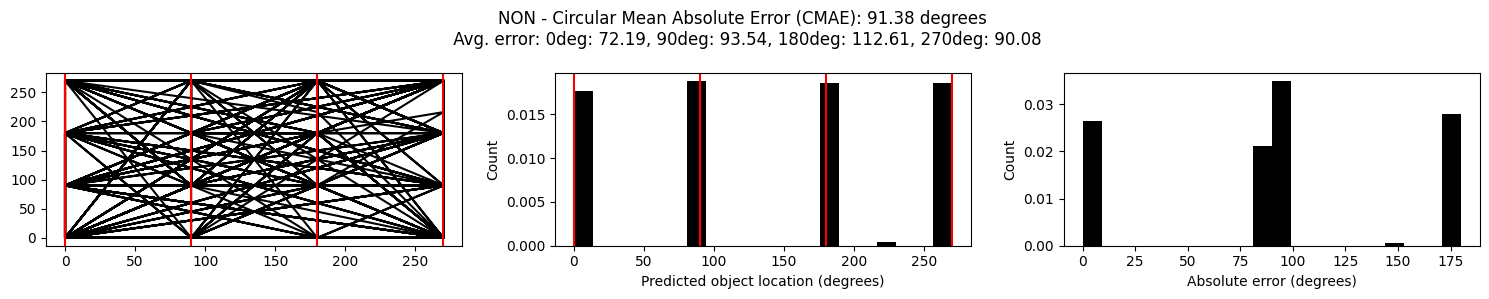

ANT
Circular Mean Absolute Error (CMAE): 104.46 degrees


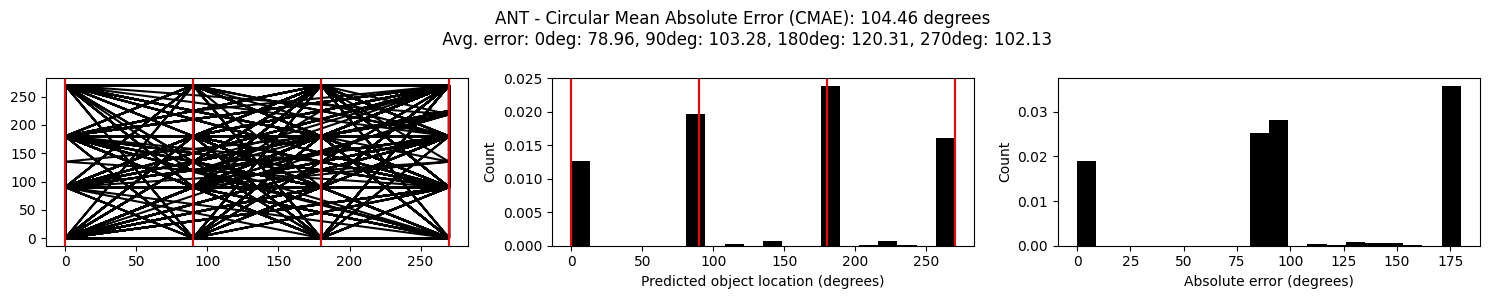

In [69]:
from sklearn.tree import DecisionTreeRegressor

for gp_use in ['B6', 'NON', 'ANT']:
    print(gp_use)
        
    filtered_df = new_df2[(new_df2['score'] == 'field') & (new_df2['group'] == gp_use) & (new_df2['object_location'] != 'NO')]
    X = filtered_df['obj_q'].to_numpy().reshape(-1, 1)
    y = filtered_df['object_location'].to_numpy()

    class_mapping = {'0': 0, '90': 90, '180': 180, '270': 270}
    # convert to radians
    y = np.array([class_mapping[label] for label in y])
    y_radians = np.radians(y)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_radians, test_size=0.2, random_state=42)
    # Initialize and train the Decision Tree regressor model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    # Predict object locations in radians
    predicted_radians = model.predict(X_test)
    # Convert predicted radians back to degrees and wrap around the circular range (0 to 360 degrees)
    predicted_degrees = (np.degrees(predicted_radians) + 360) % 360

    def circular_mean_absolute_error(y_true, y_pred):
        errors = np.abs(np.arctan2(np.sin(np.radians(y_true) - np.radians(y_pred)), np.cos(np.radians(y_true) - np.radians(y_pred))))
        cmae = np.degrees(np.mean(errors))
        return cmae, errors
    # Calculate CMAE for the predictions
    cmae, errors = circular_mean_absolute_error(y_test, predicted_degrees)
    # convert to degrees
    errors = np.degrees(errors)
    print("Circular Mean Absolute Error (CMAE): {:.2f} degrees".format(cmae))
    # calculate error as a function of quantile
    # quantiles = np.linspace(0, 1, 100)
 
    # Plot error as a function of quantile
    fig = plt.figure(figsize=(15, 3))
    
    # predicted_degrees = predicted_degrees[np.argsort(errors)]
    # errors = errors[np.argsort(y_test)]
    # y_test = np.sort(y_test)

    # avg error for true object location
    obj_0 = np.mean(errors[np.where(np.degrees(y_test) == 0)])
    obj_90 = np.mean(errors[np.where(np.degrees(y_test) == 90)])
    obj_180 = np.mean(errors[np.where(np.degrees(y_test) == 180)])
    obj_270 = np.mean(errors[np.where(np.degrees(y_test) == 270)])

    ax = plt.subplot(1,3,1)
    ax.plot(np.degrees(y_test), predicted_degrees, color='k')
    # ax.scatter(predicted_degrees, errors, color='k')
    # ax.set_xlabel('Predicted object location (degrees)')
    # ax.set_ylabel('Absolute error (degrees)')
    ax.axvline(x=0, color='r')
    ax.axvline(x=90, color='r')
    ax.axvline(x=180, color='r')
    ax.axvline(x=270, color='r')
    # ax.axhline(y=0, color='r')
    # ax.axhline(y=90, color='r')
    # ax.axhline(y=180, color='r')
    # ax.axhline(y=270, color='r')

    ax = plt.subplot(1,3,2)
    # ax.plot(np.degrees(y_test), errors, color='k')
    ax.hist(predicted_degrees, bins=20, color='k', density=True)
    ax.set_xlabel('Predicted object location (degrees)')
    ax.set_ylabel('Count')
    ax.axvline(x=0, color='r')
    ax.axvline(x=90, color='r')
    ax.axvline(x=180, color='r')
    ax.axvline(x=270, color='r')

    # ax.set_xlabel('True object location (degrees)')
    # ax.set_ylabel('Absolute error (degrees)')


    ax = plt.subplot(1,3,3)
    ax.hist(errors, bins=20, color='k', density=True)
    ax.set_xlabel('Absolute error (degrees)')
    ax.set_ylabel('Count')


    fig.suptitle(gp_use + ' - Circular Mean Absolute Error (CMAE): {:.2f} degrees \n Avg. error: 0deg: {:.2f}, 90deg: {:.2f}, 180deg: {:.2f}, 270deg: {:.2f}'.format(cmae, obj_0, obj_90, obj_180, obj_270))
    fig.tight_layout()
    plt.show()

In [ ]:
plt.plot(np.sort(predicted_degrees))

In [ ]:
y_test

In [70]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
# Assuming df is your DataFrame containing the data
for gp_use in ['B6', 'NON', 'ANT']:
    print(gp_use)
    filtered_df = new_df2[(new_df2['score'] == 'whole') & (new_df2['group'] == gp_use) & (new_df2['prev_obj_loc'] != 'NO')]
    # only sessions 1 through 3
    # filtered_df = filtered_df[filtered_df['session_id'].isin(['session_1', 'session_2', 'session_3'])]
    X = filtered_df['obj_q'].to_numpy().reshape(-1, 1)
    y = filtered_df['prev_obj_loc'].to_numpy()
    # Convert class labels to numerical values (0, 1, 2, 3 for '0', '90', '180', '270') for Logistic Regression
    class_mapping = {'0': 0, '90': 1, '180': 2, '270': 3}
    y_lr = np.array([class_mapping[label] for label in y])
    # Decision Tree Regressor
    print("Decision Tree Regressor:")
    model_dt = DecisionTreeRegressor()
    k = 10
    cross_val_scores_dt = cross_val_score(model_dt, X, y, cv=k, scoring='neg_mean_absolute_error')
    print("Cross-Validation Scores (DT):", cross_val_scores_dt)
    print("Mean CV Error (DT):", -cross_val_scores_dt.mean())  # Convert negative MAE to positive for interpretation
    # Logistic Regression
    print("Logistic Regression:")
    X_train, X_temp, y_train_lr, y_temp_lr = train_test_split(X, y_lr, test_size=0.3, random_state=42)
    X_val, X_test, y_val_lr, y_test_lr = train_test_split(X_temp, y_temp_lr, test_size=0.5, random_state=42)
    model_lr = LogisticRegression(max_iter=10000, multi_class='multinomial', solver='lbfgs')
    cross_val_scores_lr = cross_val_score(model_lr, X_train, y_train_lr, cv=k, scoring='accuracy')
    print("Cross-Validation Scores (LR):", cross_val_scores_lr)
    print("Mean CV Accuracy (LR):", cross_val_scores_lr.mean())
    model_lr.fit(X_train, y_train_lr)
    val_predictions_lr = model_lr.predict(X_val)
    val_accuracy_lr = accuracy_score(y_val_lr, val_predictions_lr)
    print("Validation Accuracy (LR):", val_accuracy_lr)
    test_predictions_lr = model_lr.predict(X_test)
    test_accuracy_lr = accuracy_score(y_test_lr, test_predictions_lr)
    print("Test Accuracy (LR):", test_accuracy_lr)
    # Circular-to-Linear Regression
    print("Circular-to-Linear Regression:")
    # Assuming X_linear represents circular data transformed to linear format as earlier in the conversation
    X_linear = np.column_stack((np.cos(2 * np.pi * X), np.sin(2 * np.pi * X)))
    
    class_mapping = {'0': 0, '90': 90, '180': 180, '270': 270}
    y_radians = np.array([class_mapping[label] for label in y])
    X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_linear, y_radians, test_size=0.3, random_state=42)
    model_cl = LinearRegression()
    model_cl.fit(X_train_cl, y_train_cl)
    predicted_radians_cl = model_cl.predict(X_test_cl)
    predicted_degrees_cl = (np.degrees(predicted_radians_cl) + 360) % 360
    accuracy_cl = circular_mean_absolute_error(y_test_cl, predicted_degrees_cl)
    print("Accuracy (CL): {:.2f} degrees".format(accuracy_cl[0])) 

B6
Decision Tree Regressor:
Cross-Validation Scores (DT): [ -98.26363636 -115.2        -103.05       -122.4        -105.75
 -131.81818182 -125.45454545 -123.63636364 -111.81818182  -88.18181818]
Mean CV Error (DT): 112.55727272727272
Logistic Regression:
Cross-Validation Scores (LR): [0.31428571 0.32857143 0.34285714 0.35714286 0.31428571 0.31428571
 0.34782609 0.28985507 0.37681159 0.34782609]
Mean CV Accuracy (LR): 0.33337474120082816
Validation Accuracy (LR): 0.3422818791946309
Test Accuracy (LR): 0.32
Circular-to-Linear Regression:
Accuracy (CL): 89.68 degrees
NON
Decision Tree Regressor:
Cross-Validation Scores (DT): [ -93.09278351 -104.31516937 -111.10824742 -100.10851872  -86.75257732
  -99.27835052 -125.46875    -110.5078125  -114.7125     -109.58333333]
Mean CV Error (DT): 105.49280426824149
Logistic Regression:
Cross-Validation Scores (LR): [0.29411765 0.33823529 0.38235294 0.32352941 0.29411765 0.27941176
 0.29850746 0.35820896 0.40298507 0.29850746]
Mean CV Accuracy (LR): 0

In [71]:
from sklearn.metrics import mean_absolute_error
# Assuming df is your DataFrame containing the data
for gp_use in ['B6', 'NON', 'ANT']:
    print(gp_use)
    filtered_df = new_df2[(new_df2['score'] == 'whole') & (new_df2['group'] == gp_use) & (new_df2['object_location'] != 'NO')]
    # only sessions 1 through 3
    # filtered_df = filtered_df[filtered_df['session_id'].isin(['session_1', 'session_2', 'session_3'])]
    X = filtered_df['obj_q'].to_numpy().reshape(-1, 1)
    y = filtered_df['object_location'].to_numpy()
    # Convert class labels to numerical values (0, 1, 2, 3 for '0', '90', '180', '270')
    class_mapping = {'0': 0, '90': 90, '180': 180, '270': 270}
    y_lr = np.array([class_mapping[label] for label in y])
    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_lr, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Decision Tree Regressor
    print("Decision Tree Regressor:")
    model_dt = DecisionTreeRegressor()
    # Train the model
    model_dt.fit(X_train, y_train)
    # Validate the model
    val_predictions_dt = model_dt.predict(X_val)
    val_mae_dt = mean_absolute_error(y_val, val_predictions_dt)
    print("Validation MAE (DT):", val_mae_dt)
    # Test the model
    test_predictions_dt = model_dt.predict(X_test)
    test_mae_dt = mean_absolute_error(y_test, test_predictions_dt)
    print("Test MAE (DT):", test_mae_dt)

B6
Decision Tree Regressor:
Validation MAE (DT): 79.995
Test MAE (DT): 80.565
NON
Decision Tree Regressor:
Validation MAE (DT): 92.99043062200957
Test MAE (DT): 85.4095238095238
ANT
Decision Tree Regressor:
Validation MAE (DT): 59.64198159994718
Test MAE (DT): 60.10319608819572


In [ ]:
filtered_df.columns

In [339]:
df = df[df['session_id'] != 'session_7']
df = df[df['session_id'] != 'session_8']

(3, 1000, 2)
Metric: whole
Group: B6
Empirical: 0.04872399583745487
Shuffled: -0.006488011183527027 ± 0.01894518383601902
Group: NON
Empirical: 0.10125554581155326
Shuffled: -0.007153459901504734 ± 0.019821078722510658
Group: ANT
Empirical: -0.005710605586508541
Shuffled: -0.006938561364705831 ± 0.019574613129576767
[0.004, 0.0, 0.966]
(array([ True,  True, False]), array([0.006, 0.   , 0.966]), 0.016952427508441503, 0.016666666666666666)
Text(0, 0, 'slope: -0.0094')
slope: -0.0094
Text(0, 0, 'slope: 0.0029')
slope: 0.0029
Text(0, 0, 'slope: 0.001')
slope: 0.001
(3, 1000, 2)
Metric: field
Group: B6
Empirical: 0.0136174144232629
Shuffled: 0.014084896057637554 ± 0.012905763980407698
Group: NON
Empirical: 0.09766522508409801
Shuffled: 0.014546089906019941 ± 0.012959044236380194
Group: ANT
Empirical: 0.02079174504179767
Shuffled: 0.01400865478759091 ± 0.012812911117630128
[0.932, 0.0, 0.614]
(array([False,  True, False]), array([0.932, 0.   , 0.921]), 0.016952427508441503, 0.01666666666666

C:\Users\aaoun\AppData\Local\Temp\ipykernel_10912\3217532431.py:441: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


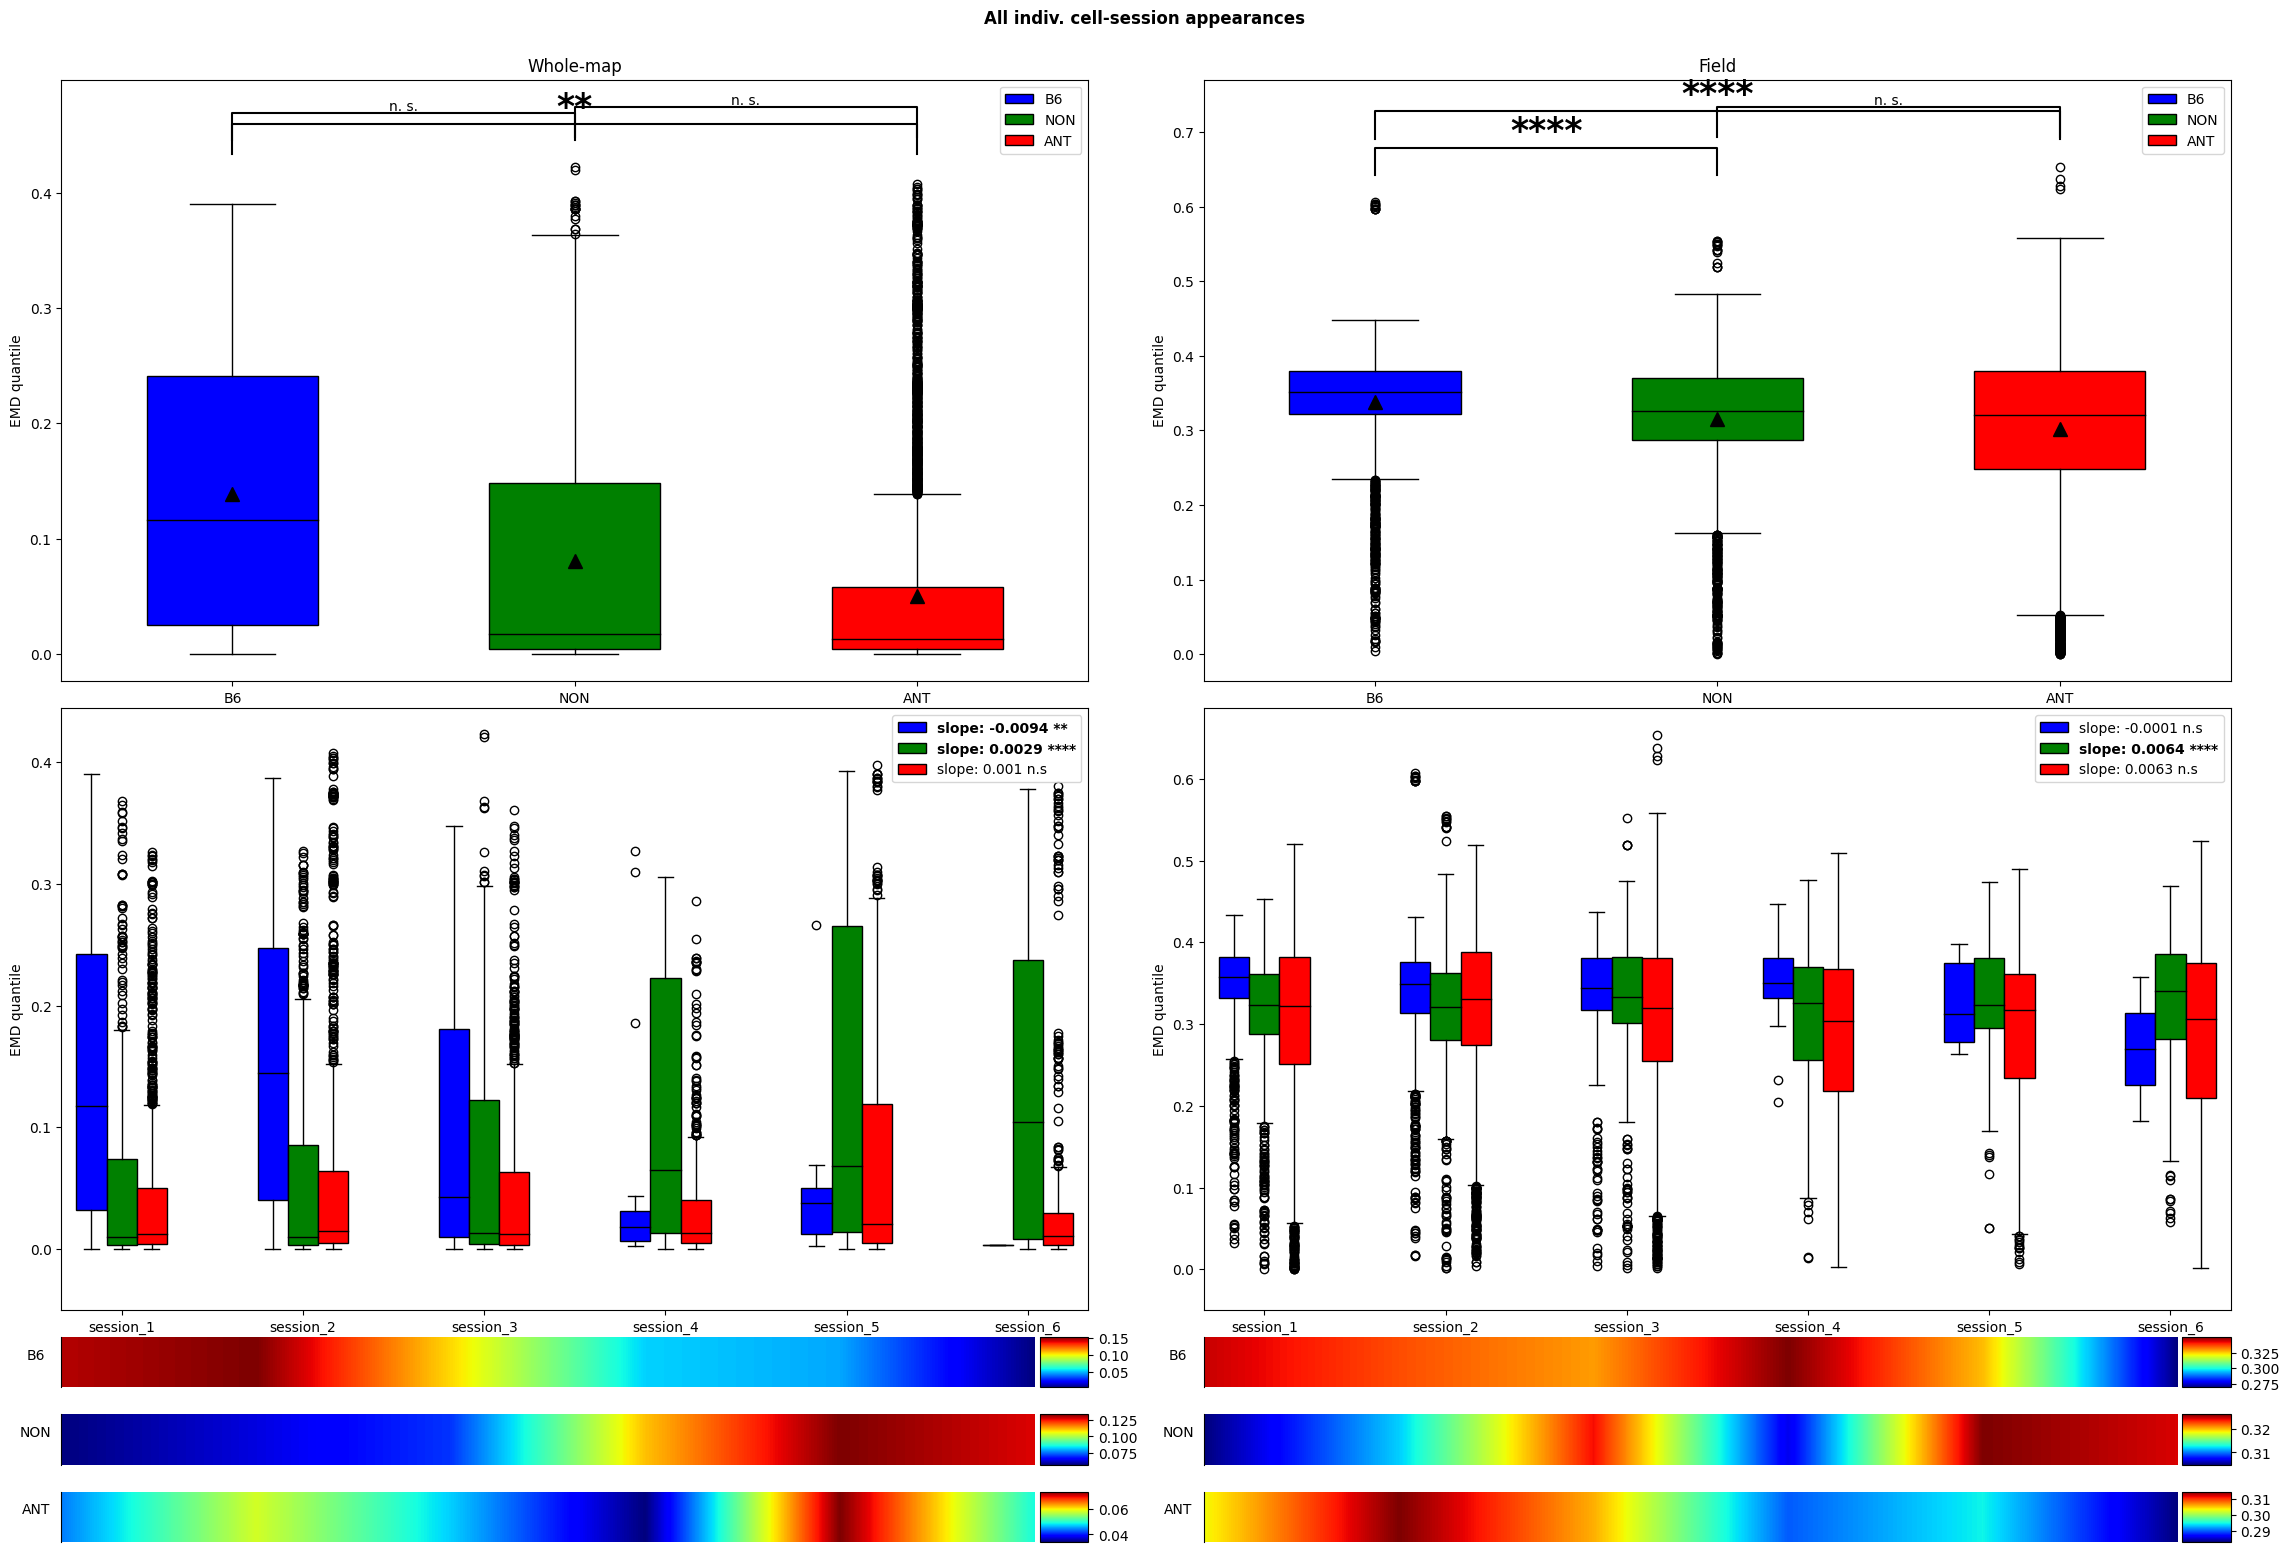

In [340]:
""" Amount of remapping per group """
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats import multitest
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate
from scipy.interpolate import griddata


scores_to_use = ['whole', 'field']
# 'spike_density', 'binary']
# 'field', 'binary', 'centroid', 'firing_rate']
quad_arrange = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1]]
titles_to_use = ['Whole-map', 'Field']
# 'Spike Density', 'Field', 'Binary', 'Centroid', 'Firing Rate']
gps = np.unique(df['session_id'])
gp_labels = ['B6', 'NON', 'ANT']
gp_colors = ['b', 'g', 'r']

np.random.seed(0)

def _single_shuffle(to_plot_shuffle, sesgp, metric, gplbl):
    vals = to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, 'group'].to_numpy()
    np.random.shuffle(vals)
    to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, 'group'] = vals

    use = to_plot_shuffle[to_plot_shuffle['session_id'] == sesgp]
    # use = use[use['group'] == gplbl][metric]
    # mn = np.mean(use)
    return use

fig = plt.figure(figsize=(23, 46))
gs_main = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1, 1])  # Adjust width_ratios and height_ratios as needed


# metric = 'obj_w'
metric = 'obj_q'

for i, score in enumerate(scores_to_use):
    # scores averaged for each session
    if score != 'firing_rate':
        to_plot = df[df['score'] == score]
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()
    else:
        to_plot = df[df['score'] == 'whole']
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()


    row, col = quad_arrange[i]
    gs_sub = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[row, col], height_ratios=[12,12,1,1,1], hspace=0.1)

    ax = plt.subplot(gs_sub[0])
    axf = ax
    bps = []
    lbls = []
    means = []
    sems = []
    n = []
    comps = score_beta_ps[score]
    comp_maxs = []
    for k in range(3):
        c = gp_colors[k]
        if score != 'firing_rate':
            mtouse = metric 
        else:
            mtouse = 'firing_rate'
        bp = ax.boxplot(to_plot[to_plot['group'] == gp_labels[k]][mtouse], positions=[k], widths=0.5, 
                    notch=False, patch_artist=True,
                    boxprops=dict(facecolor=c, color='k'),
                    capprops=dict(color='k'),
                    whiskerprops=dict(color='k'),
                    flierprops=dict(color='k', markeredgecolor='k'),
                    medianprops=dict(color='k'),
                    showmeans=True, 
                    meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
        comp_maxs.append(np.max(to_plot[to_plot['group'] == gp_labels[k]][mtouse]))
        for k2 in range(3):
            if k2 != k:
                lbl_pair = np.sort([gp_labels[k], gp_labels[k2]])
                comp_group = lbl_pair[0] + '_' + lbl_pair[1]
                if comp_group not in comps.keys():
                    comps[comp_group] = np.nan

                    if 'B6' in comp_group and 'ANT' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'ANT'])]
                        group_order = ['B6', 'ANT']  # 'B6' becomes the reference group
                    elif 'B6' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'NON'])]
                        group_order = ['B6', 'NON']
                    elif 'ANT' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['NON', 'ANT'])]
                        group_order = ['NON', 'ANT']
                    # model_data['group'] = pd.Categorical(model_data['group'], categories=group_order, ordered=True)
                    model_data.loc[:, 'group'] = pd.Categorical(model_data.loc[:, 'group'], categories=group_order, ordered=True)

        means.append(np.mean(to_plot[to_plot['group'] == gp_labels[k]][metric]))
        sems.append(np.std(to_plot[to_plot['group'] == gp_labels[k]][metric]) / np.sqrt(len(to_plot[to_plot['group'] == gp_labels[k]][metric])))
        n.append(len(to_plot[to_plot['group'] == gp_labels[k]][metric]))
                                    
        bps.append(bp['boxes'][0])
        # lbls.append(str(means[k]) + ' ± ' + str(sems[k]) + ' cm, N = ' + str(n[k]))
        lbls.append(gp_labels[k])
        #  + ': N = ' + str(n[k]))
    
    ax.set_xticklabels(gp_labels)
    ax.legend(bps, lbls, loc='upper right')
    ax.set_xlabel('Group')
    ax.set_ylabel('EMD quantile')

    # benjamini hochberg correction
    kys, vals = zip(*comps.items())
    # accepted, pvals_corrected, _, _ = multipletests(vals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    pvals_corrected = vals
    accepted = np.array([True for x in range(len(vals))])

    p_count = 0
    for comp_key, val in comps.items():
        comparison = comps[comp_key]
        if 'ANT' in comp_key and 'B6' in comp_key:
            nme = [0,2]
        elif 'ANT' in comp_key and 'NON' in comp_key:
            nme = [1,2]
        elif 'B6' in comp_key and 'NON' in comp_key:
            nme = [0,1]

        # if accepted[k]:
        barplot_annotate_brackets(nme[0],nme[1],pvals_corrected[p_count],[0,1,2], comp_maxs, maxasterix=5)
        
        p_count += 1

    # ax = fig.add_subplot(2, 2, i+1)
    ax = plt.subplot(gs_sub[1])
    ax1 = ax

    # # every row for that score
    if score != 'firing_rate':
        to_plot = df[df['score'] == score]
        # to_plot = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
    else:
        to_plot = df[df['score'] == 'whole']
        # to_plot = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        metric = 'firing_rate'
        # to_plot = to_plot[to_plot['depth']]
    to_plot_shuffle = to_plot.copy()



    bps = []
    lbls = []
    shuffle_count = 1000
    mns = [[] for j in range(3)]
    mns_shuffle = [[[] for sc in range(shuffle_count)] for j in range(3)]
    
    for j in range(3):
        to_plot_now = to_plot[to_plot['group'] == gp_labels[j]]
        group_by_unique_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']
        to_plot_now = to_plot_now.groupby(group_by_unique_cell)
        slps = []
        for grp in to_plot_now.groups:
            grp_now = to_plot_now.get_group(grp)
            vals = grp_now[metric].to_numpy()
            # print(vals, grp_now)
            # stop
            if len(vals) > 2:
                slp = mk.original_test(vals)
                if slp == slp:
                    slps.append([slp.z,slp.slope])
        mns[j] = np.mean(slps,axis=0)

        for sc in range(shuffle_count):
            agg_use = []
            for k in range(len(gps)):
                use = _single_shuffle(to_plot_shuffle, gps[k], metric, gp_labels[j])
                # use = to_plot_shuffle[to_plot_shuffle['session_id'] == sesgp]
                agg_use.append(use)
            agg_use = pd.concat(agg_use)
            agg_use = agg_use.groupby(group_by_unique_cell)
            slps = []
            for grp in agg_use.groups:
                grp_now = agg_use.get_group(grp)
                vals = grp_now[metric].to_numpy()
                if len(vals) > 2:
                    slp = mk.original_test(vals)
                    if slp == slp:
                        slps.append([slp.z,slp.slope])
            mns_shuffle[j][sc] = np.mean(slps,axis=0)

            # if out == out:
            #     mns_shuffle[j][sc].append(out)

    group_ses_frs = {'ANT': [], 'B6': [], 'NON': []}
    for k in range(len(gps)):
        # c = gp_colors[k]
        ses_visited = []
        # ses_frs = []
        for j in range(3):
            # get group means + CI
            to_plot_now = to_plot[to_plot['group'] == gp_labels[j]]
            ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]][metric]
            # ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]]['information']
            bp = ax.boxplot(to_plot_now[to_plot_now['session_id'] == gps[k]][metric], positions=[k*3+j*.5], widths=0.5, 
                        notch=False, patch_artist=True,
                        boxprops=dict(facecolor=gp_colors[j],color='k'),
                        capprops=dict(color='k'),
                        whiskerprops=dict(color='k'),
                        flierprops=dict(color='k', markeredgecolor='k'),
                        medianprops=dict(color='k'),
                        showmeans=False, 
                        meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
            if k == 0:
                bps.append(bp['boxes'][0])   

            if len(ses_fr) > 0 and np.mean(ses_fr) == np.mean(ses_fr):       
                group_ses_frs[gp_labels[j]].append(np.mean(ses_fr))

        #     mn = np.mean(to_plot_now[to_plot_now['session_id'] == gps[k]][metric])
        #     if mn == mn:
        #         mns[j].append(mn)

        # for j in range(3):
        #     for sc in range(shuffle_count):
        #         out = _single_shuffle(to_plot_shuffle, gps[k], metric, gp_labels[j])
        #         if out == out:
        #             mns_shuffle[j][sc].append(out)

    # plt.setp(ax1.get_xticklabels(), visible=False)

    ax = plt.subplot(gs_sub[4])
    # bh_ant_b6 = np.hstack((bh_ant_b6, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_b6, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    ant_fr = group_ses_frs['ANT']
    ant_interp = np.linspace(0, len(ant_fr)-1, shuffle_count)
    ant_fr_smooth = np.interp(ant_interp, np.arange(len(ant_fr)), ant_fr)
    im = ax.imshow(np.expand_dims(ant_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('ANT', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] -.5))
    ax.set_yticks([])
    # ax.set_ylabel('ANT-B6', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[2])
    # bh_b6_non = np.hstack((bh_b6_non, [.5]))
    # ax.imshow(np.expand_dims(bh_b6_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    b6_fr = group_ses_frs['B6']
    b6_interp = np.linspace(0, len(b6_fr)-1, shuffle_count)
    b6_fr_smooth = np.interp(b6_interp, np.arange(len(b6_fr)), b6_fr)
    im = ax.imshow(np.expand_dims(b6_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('B6', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1]-.5))
    ax.set_yticks([])
    # ax.set_ylabel('B6-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[3])
    # # bh_ant_non = np.hstack((bh_ant_non, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    non_fr = group_ses_frs['NON']
    non_interp = np.linspace(0, len(non_fr)-1, shuffle_count)
    non_fr_smooth = np.interp(non_interp, np.arange(len(non_fr)), non_fr)
    im = ax.imshow(np.expand_dims(non_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('NON', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] - .5))
    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_yticks([])
    # ylbl = ax.set_ylabel('ANT-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    # mann kendall
    import pymannkendall as mk
    from statsmodels.stats import multitest
    lbls = []
    lbl_colors = []
    empirical = []
    slopes = []
    ps = []
    mns_shuffle = np.array(mns_shuffle)
    print(mns_shuffle.shape)
    print('Metric: ' + score)
    for j in range(3):
        # polyfit 

        # slp, c = np.polyfit(np.arange(len(mns[j])), mns[j], 1)
        # slopes.append(slp)

        # memp = mk.original_test(mns[j])
        z, slope = mns[j]
        empirical.append(z)
        slopes.append(slope)


        shuffled = []
        for sc in range(shuffle_count):
            # if len(mns_shuffle[j,sc]) > 0:
            ses_dist = mns_shuffle[j,sc]
            # mshuffled, c = np.polyfit(np.arange(len(ses_dist)), ses_dist, 1)
            # mshuffled = mk.original_test(ses_dist)
            shuffled.append(ses_dist[0])
                # result = mk.original_test(ses_dist)
                # ps.append(result.p)


        # # two sided p-value 
        pgreater = np.sum(np.array(shuffled) < empirical[j]) / len(shuffled) 
        plower = np.sum(np.array(shuffled) > empirical[j]) / len(shuffled)
        pvalue = np.min([pgreater, plower]) * 2
        ps.append(pvalue)
        print('Group: ' + gp_labels[j])
        print('Empirical: ' + str(empirical[j]))
        print('Shuffled: ' + str(np.mean(shuffled)) + ' ± ' + str(np.std(shuffled)))
        # print('p-value: ' + str(np.min([pgreater, plower]) * 2))


        # if empirical[j] > np.mean(shuffled):
        #     tag = 'greater'
        # elif empirical[j] < np.mean(shuffled):
        #     tag = 'lower'
        # lbl = 'Slope is ' + str(tag) + ' than shuffled: ' + str(np.round(memp, 2)) + ' , p = ' + str(np.round(pvalue, 3)) 
        # lbls.append(lbl)

        # lbl = gp_labels[j] + ' 
        lbl = 'slope: ' + str(np.round(slope, 4)) 
        lbl_colors.append('k')
        lbls.append(lbl)

    # result = mk.original_test(ses_dist)
    print(ps)
    out = multitest.multipletests(ps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    cc = 0
    for case in out[0]:
        if case:
            lbl_colors[cc] = 'r'
            # lbls[cc] = lbls[cc] + ' & is sig after BH correction'
        # else:
            # lbls[cc] = lbls[cc] + ' & is NOT sig after BH correction'
        cc += 1
    print(out)

    ax1.legend(bps, lbls, loc='upper right')
    # color label text in legend
    idx = 0
    for text, color in zip(ax1.legend_.get_texts(), lbl_colors):
        # text.set_color(color)
        # set font weight to bold
        if color == 'r':
            text.set_weight('bold')
        pval = out[1][idx]
        if pval <= 0.05:
            astk = '*'
        if pval <= 0.01:
            astk = '**'
        if pval <= 0.001:
            astk = '***'
        if pval <= 0.0001:
            astk = '****'
        if pval > 0.05:
            astk = 'n.s'
        print(text)
        print(text.get_text())
        new_text = str(text.get_text()) + ' ' + str(astk)
        text.set_text(new_text)
        idx += 1

    # ax1.set_title(score)
    # ax.set_xlabel('Session')
    axf.set_title(titles_to_use[i])
    ax1.set_ylabel('EMD quantile')
              
    # ax1.set_xticks(np.arange(len(gps)) * 3 + 1.25/2)
    # ax1.set_xticklabels(gps)
    # ax1.set_xlim([-1.25/2, len(gps) * 3 - 1.25/2])

    ax1.set_xticks(np.arange(len(gps)) * 3 + .5)
    ax1.set_xticklabels(gps)
    ax1.set_ylim(-0.05,)
    # ax1.set_xlim([-.5/2, len(gps) * 3 - .5/2])


fig.suptitle('All indiv. cell-session appearances', fontweight='bold')
# fig.suptitle('Averaged by session', fontweight='bold')
gs_main.tight_layout(fig, rect=[0, 0, 1, 0.98])
# fig.suptitle('Averaged by session')
fig.tight_layout()
plt.show()

In [ ]:
len(df[(df['group'] == 'NON') & (df['score'] == 'whole')])

C:\Users\aaoun\AppData\Local\Temp\ipykernel_10912\3261947660.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mns_shuffle = np.array(mns_shuffle)


(3, 1000)
Metric: whole
(1000, 314, 2)
(314,)
Sig idx: 99
Group: B6
Empirical: 0.07958116533671086
Shuffled: -0.03812361184006664 ± 0.6215609036904929
(1000, 349, 2)
(349,)
Sig idx: 97
Group: NON
Empirical: -0.05215764458491956
Shuffled: -0.07555884565439387 ± 0.7245525386801945
(1000, 894, 2)
(894,)
Sig idx: 244
Group: ANT
Empirical: -0.14415965145612133
Shuffled: -0.0700373440699785 ± 0.738840318701476
[0.0011717171717171718, 0.007958762886597939, 0.006868852459016394]
(array([ True,  True,  True]), array([0.00351515, 0.00795876, 0.00795876]), 0.016952427508441503, 0.016666666666666666)
Text(0, 0, 'slope: -0.0084')
slope: -0.0084
Text(0, 0, 'slope: -0.0021')
slope: -0.0021
Text(0, 0, 'slope: 0.012')
slope: 0.012


C:\Users\aaoun\AppData\Local\Temp\ipykernel_10912\3261947660.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mns_shuffle = np.array(mns_shuffle)


(3, 1000)
Metric: field
(1000, 566, 2)
(566,)
Sig idx: 102
Group: B6
Empirical: 0.1127545144253877
Shuffled: -0.01627426740323695 ± 0.6369369570755206
(1000, 402, 2)
(402,)
Sig idx: 41
Group: NON
Empirical: 0.2509936051307131
Shuffled: -0.07732142959147571 ± 0.7234522409706692
(1000, 1046, 2)
(1046,)
Sig idx: 112
Group: ANT
Empirical: 0.39794516905012217
Shuffled: -0.052132230097561946 ± 0.6873926524503327
[0.0014313725490196078, 0.006000000000000001, 0.005214285714285714]
(array([ True,  True,  True]), array([0.00429412, 0.006     , 0.006     ]), 0.016952427508441503, 0.016666666666666666)
Text(0, 0, 'slope: 0.0087')
slope: 0.0087
Text(0, 0, 'slope: 0.0169')
slope: 0.0169
Text(0, 0, 'slope: 0.0225')
slope: 0.0225


C:\Users\aaoun\AppData\Local\Temp\ipykernel_10912\3261947660.py:463: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


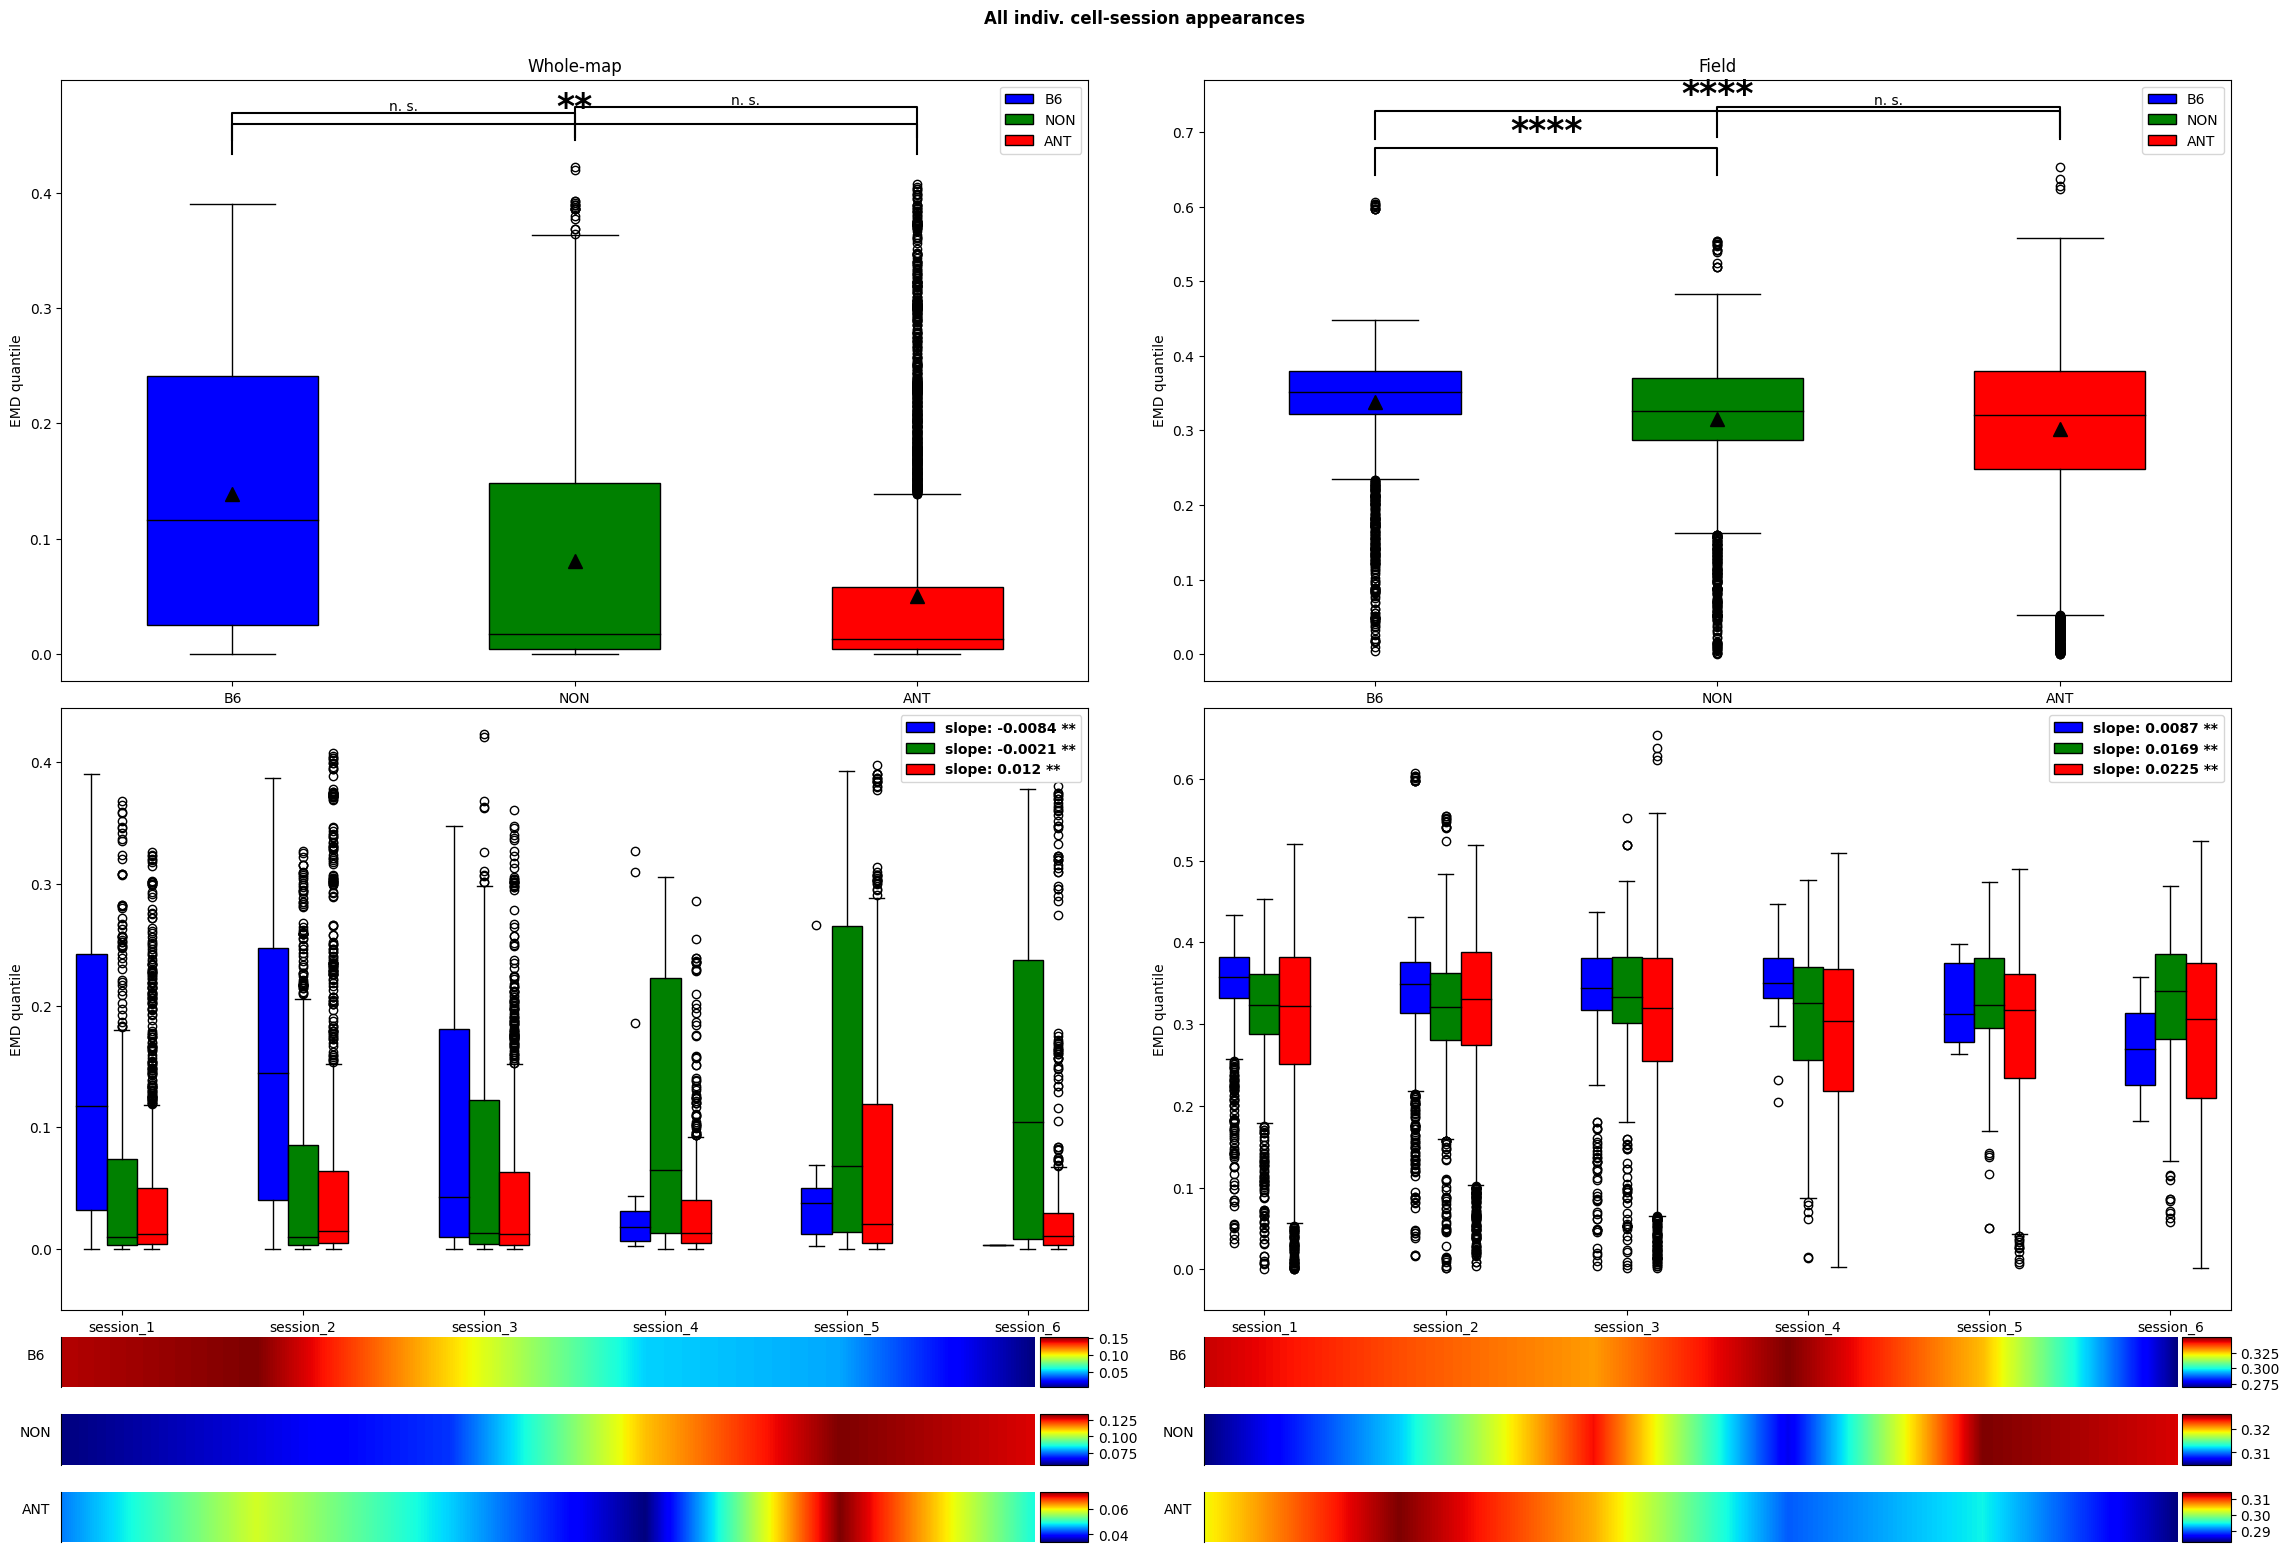

In [341]:
""" Amount of remapping per group """
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats import multitest
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate
from scipy.interpolate import griddata


scores_to_use = ['whole', 'field']
# , 'spike_density', 'binary']
# 'field', 'binary', 'centroid', 'firing_rate']
quad_arrange = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1]]
titles_to_use = ['Whole-map', 'Field']
# , 'Spike Density', 'Binary', 'Centroid', 'Firing Rate']
gps = np.unique(df['session_id'])
gp_labels = ['B6', 'NON', 'ANT']
gp_colors = ['b', 'g', 'r']

np.random.seed(0)

def _single_shuffle(to_plot_shuffle, gps, metric, gplbl):
    ses_gps = []
    for sesgp in gps:
        vals = to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, metric].to_numpy()
        np.random.shuffle(vals)
        to_plot_shuffle.loc[to_plot_shuffle['session_id'] == sesgp, metric] = vals
        ses_use = to_plot_shuffle[to_plot_shuffle['session_id'] == sesgp]
        ses_use = ses_use[ses_use['group'] == gplbl]
        ses_gps.append(ses_use)
        # mn = np.mean(use)
    use = pd.concat(ses_gps)
    return use

fig = plt.figure(figsize=(23, 46))
gs_main = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1, 1])  # Adjust width_ratios and height_ratios as needed


# metric = 'obj_w'
metric = 'obj_q'

for i, score in enumerate(scores_to_use):
    # scores averaged for each session
    if score != 'firing_rate':
        to_plot = df[df['score'] == score]
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()
    else:
        to_plot = df[df['score'] == 'whole']
        # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        # to_plot_count = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).count().reset_index()
        # to_plot_shuffle = to_plot.copy()


    row, col = quad_arrange[i]
    gs_sub = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[row, col], height_ratios=[12,12,1,1,1], hspace=0.1)

    ax = plt.subplot(gs_sub[0])
    axf = ax
    bps = []
    lbls = []
    means = []
    sems = []
    n = []
    comps = score_beta_ps[score]
    comp_maxs = []
    for k in range(3):
        c = gp_colors[k]
        if score != 'firing_rate':
            mtouse = metric 
        else:
            mtouse = 'firing_rate'
        bp = ax.boxplot(to_plot[to_plot['group'] == gp_labels[k]][mtouse], positions=[k], widths=0.5, 
                    notch=False, patch_artist=True,
                    boxprops=dict(facecolor=c, color='k'),
                    capprops=dict(color='k'),
                    whiskerprops=dict(color='k'),
                    flierprops=dict(color='k', markeredgecolor='k'),
                    medianprops=dict(color='k'),
                    showmeans=True, 
                    meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
        comp_maxs.append(np.max(to_plot[to_plot['group'] == gp_labels[k]][mtouse]))
        for k2 in range(3):
            if k2 != k:
                lbl_pair = np.sort([gp_labels[k], gp_labels[k2]])
                comp_group = lbl_pair[0] + '_' + lbl_pair[1]
                if comp_group not in comps.keys():
                    comps[comp_group] = np.nan

                    if 'B6' in comp_group and 'ANT' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'ANT'])]
                        group_order = ['B6', 'ANT']  # 'B6' becomes the reference group
                    elif 'B6' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['B6', 'NON'])]
                        group_order = ['B6', 'NON']
                    elif 'ANT' in comp_group and 'NON' in comp_group:
                        if score != 'firing_rate':
                            to_plot_model = df[df['score'] == score]
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        else:
                            to_plot_model = df[df['score'] == 'whole']
                            # .groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
                        model_data = to_plot_model[to_plot_model['group'].isin(['NON', 'ANT'])]
                        group_order = ['NON', 'ANT']
                    # model_data['group'] = pd.Categorical(model_data['group'], categories=group_order, ordered=True)
                    model_data.loc[:, 'group'] = pd.Categorical(model_data.loc[:, 'group'], categories=group_order, ordered=True)

        means.append(np.mean(to_plot[to_plot['group'] == gp_labels[k]][metric]))
        sems.append(np.std(to_plot[to_plot['group'] == gp_labels[k]][metric]) / np.sqrt(len(to_plot[to_plot['group'] == gp_labels[k]][metric])))
        n.append(len(to_plot[to_plot['group'] == gp_labels[k]][metric]))
                                    
        bps.append(bp['boxes'][0])
        # lbls.append(str(means[k]) + ' ± ' + str(sems[k]) + ' cm, N = ' + str(n[k]))
        lbls.append(gp_labels[k])
        #  + ': N = ' + str(n[k]))
    
    ax.set_xticklabels(gp_labels)
    ax.legend(bps, lbls, loc='upper right')
    ax.set_xlabel('Group')
    ax.set_ylabel('EMD quantile')

    # benjamini hochberg correction
    kys, vals = zip(*comps.items())
    # accepted, pvals_corrected, _, _ = multipletests(vals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    pvals_corrected = vals
    accepted = np.array([True for x in range(len(vals))])

    p_count = 0
    for comp_key, val in comps.items():
        comparison = comps[comp_key]
        if 'ANT' in comp_key and 'B6' in comp_key:
            nme = [0,2]
        elif 'ANT' in comp_key and 'NON' in comp_key:
            nme = [1,2]
        elif 'B6' in comp_key and 'NON' in comp_key:
            nme = [0,1]

        # if accepted[k]:
        barplot_annotate_brackets(nme[0],nme[1],pvals_corrected[p_count],[0,1,2], comp_maxs, maxasterix=5)
        
        p_count += 1

    # ax = fig.add_subplot(2, 2, i+1)
    ax = plt.subplot(gs_sub[1])
    ax1 = ax

    # # every row for that score
    if score != 'firing_rate':
        to_plot = df[df['score'] == score]
        # to_plot = df[df['score'] == score].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
    else:
        to_plot = df[df['score'] == 'whole']
        # to_plot = df[df['score'] == 'whole'].groupby(['group', 'name', 'depth', 'date','stim','session_id']).mean().reset_index()
        metric = 'firing_rate'
        # to_plot = to_plot[to_plot['depth']]
    to_plot_shuffle = to_plot.copy()



    bps = []
    lbls = []
    shuffle_count = 1000
    mns = [[] for j in range(3)]
    mns_shuffle = [[[] for sc in range(shuffle_count)] for j in range(3)]
    
    for j in range(3): 
        to_plot_now = to_plot[to_plot['group'] == gp_labels[j]]
        group_by_unique_cell = ['group','date','tetrode', 'unit_id']
        to_plot_now = to_plot_now.groupby(group_by_unique_cell)
        slps = []
        for grp in to_plot_now.groups:
            grp_now = to_plot_now.get_group(grp)
            vals = grp_now[metric].to_numpy()
            # print(vals, grp_now)
            # stop
            if len(vals) > 2:
                slp = mk.original_test(vals)
                if slp == slp:
                    slps.append([slp.z,slp.slope])
        mns[j] = slps
        # print(len(to_plot_now.groups))

        for sc in range(shuffle_count):
            # agg_use = []
            # for k in range(len(gps)):
            agg_use = _single_shuffle(to_plot_shuffle, gps, metric, gp_labels[j])
                # use = to_plot_shuffle[to_plot_shuffle['session_id'] == sesgp]
                # agg_use.append(use)
            # agg_use = pd.concat(agg_use)
            agg_use = agg_use.groupby(group_by_unique_cell)
            # print(len(agg_use))
            slps = []
            for grp in agg_use.groups:
                grp_now = agg_use.get_group(grp)
                vals = grp_now[metric].to_numpy()
                if len(vals) > 2:
                    slp = mk.original_test(vals)
                    if slp == slp:
                        slps.append([slp.z,slp.slope])
            mns_shuffle[j][sc] = slps

            # if out == out:
            #     mns_shuffle[j][sc].append(out)
        # stopp()
    group_ses_frs = {'ANT': [], 'B6': [], 'NON': []}
    for k in range(len(gps)):
        # c = gp_colors[k]
        ses_visited = []
        # ses_frs = []
        for j in range(3):
            # get group means + CI
            to_plot_now = to_plot[to_plot['group'] == gp_labels[j]]
            ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]][metric]
            # ses_fr = to_plot_now[to_plot_now['session_id'] == gps[k]]['information']
            bp = ax.boxplot(to_plot_now[to_plot_now['session_id'] == gps[k]][metric], positions=[k*3+j*.5], widths=0.5, 
                        notch=False, patch_artist=True,
                        boxprops=dict(facecolor=gp_colors[j],color='k'),
                        capprops=dict(color='k'),
                        whiskerprops=dict(color='k'),
                        flierprops=dict(color='k', markeredgecolor='k'),
                        medianprops=dict(color='k'),
                        showmeans=False, 
                        meanprops=dict(markeredgecolor='k', markerfacecolor='k', markersize=10))
            if k == 0:
                bps.append(bp['boxes'][0])   

            if len(ses_fr) > 0 and np.mean(ses_fr) == np.mean(ses_fr):       
                group_ses_frs[gp_labels[j]].append(np.mean(ses_fr))

        #     mn = np.mean(to_plot_now[to_plot_now['session_id'] == gps[k]][metric])
        #     if mn == mn:
        #         mns[j].append(mn)

        # for j in range(3):
        #     for sc in range(shuffle_count):
        #         out = _single_shuffle(to_plot_shuffle, gps[k], metric, gp_labels[j])
        #         if out == out:
        #             mns_shuffle[j][sc].append(out)

    # plt.setp(ax1.get_xticklabels(), visible=False)

    ax = plt.subplot(gs_sub[4])
    # bh_ant_b6 = np.hstack((bh_ant_b6, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_b6, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    ant_fr = group_ses_frs['ANT']
    ant_interp = np.linspace(0, len(ant_fr)-1, shuffle_count)
    ant_fr_smooth = np.interp(ant_interp, np.arange(len(ant_fr)), ant_fr)
    im = ax.imshow(np.expand_dims(ant_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('ANT', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] -.5))
    ax.set_yticks([])
    # ax.set_ylabel('ANT-B6', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[2])
    # bh_b6_non = np.hstack((bh_b6_non, [.5]))
    # ax.imshow(np.expand_dims(bh_b6_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    b6_fr = group_ses_frs['B6']
    b6_interp = np.linspace(0, len(b6_fr)-1, shuffle_count)
    b6_fr_smooth = np.interp(b6_interp, np.arange(len(b6_fr)), b6_fr)
    im = ax.imshow(np.expand_dims(b6_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('B6', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1]-.5))
    ax.set_yticks([])
    # ax.set_ylabel('B6-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    ax = plt.subplot(gs_sub[3])
    # # bh_ant_non = np.hstack((bh_ant_non, [.5]))
    # ax.imshow(np.expand_dims(bh_ant_non, 0), cmap='Greys_r', aspect='auto', extent=[0, len(gps), 0, 1], vmin=0, vmax=1)
    non_fr = group_ses_frs['NON']
    non_interp = np.linspace(0, len(non_fr)-1, shuffle_count)
    non_fr_smooth = np.interp(non_interp, np.arange(len(non_fr)), non_fr)
    im = ax.imshow(np.expand_dims(non_fr_smooth, 0), cmap='jet', aspect='auto', extent=[0, len(gps), 0, 1])
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ylbl = ax.set_ylabel('NON', labelpad=15, rotation=0)
    # pos = ylbl.get_position()
    # ylbl.set_position((pos[0], pos[1] - .5))
    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_yticks([])
    # ylbl = ax.set_ylabel('ANT-NON', labelpad=15, rotation=45)
    ax.set_xticks(np.arange(len(gps)) + 0.5)
    ax.set_xticklabels(gps)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)


    # mann kendall
    import pymannkendall as mk
    from statsmodels.stats import multitest
    lbls = []
    lbl_colors = []
    empirical = []
    slopes = []
    ps = []
    mns_shuffle = np.array(mns_shuffle)
    print(mns_shuffle.shape)
    print('Metric: ' + score)
    for j in range(3):
        # polyfit 

        # slp, c = np.polyfit(np.arange(len(mns[j])), mns[j], 1)
        # slopes.append(slp)

        # memp = mk.original_test(mns[j])
        mns_use = np.array(mns[j])
        z = mns_use[:,0]
        slope = mns_use[:,1]
        # z, slope = mns[j]
        empirical.append(z)
        slopes.append(slope)


        shuffled = []
        for sc in range(shuffle_count):
            # if len(mns_shuffle[j,sc]) > 0:
            ses_dist = mns_shuffle[j,sc]
            # mshuffled, c = np.polyfit(np.arange(len(ses_dist)), ses_dist, 1)
            # mshuffled = mk.original_test(ses_dist)
            shuffled.append(ses_dist)
                # result = mk.original_test(ses_dist)
                # ps.append(result.p)

        shuffled = np.array(shuffled)
        empirical_use = np.array(empirical[j])
        print(shuffled.shape)
        print(empirical_use.shape)

        shuffled_z = shuffled[:,:,0]
        shuffled_slope = shuffled[:,:,1]

        pgreaters = np.sum(np.array(shuffled_z) < empirical_use, axis=0) / len(shuffled_z)
        plowers = np.sum(np.array(shuffled_z) > empirical_use, axis=0) / len(shuffled_z)
        pvalues = np.min([pgreaters, plowers], axis=0) * 2

        assert len(pvalues) == len(empirical_use)

        idx_where_sig = np.where(pvalues <= 0.05)[0]
        slope = np.mean(slope[idx_where_sig])
        z = np.mean(z[idx_where_sig])

        ps.append(np.mean(pvalues[idx_where_sig]))
        print('Sig idx: ' + str(len(idx_where_sig)))
        print('Group: ' + gp_labels[j])
        print('Empirical: ' + str(z))
        print('Shuffled: ' + str(np.mean(shuffled_z[:,idx_where_sig])) + ' ± ' + str(np.std(shuffled_z[:,idx_where_sig])))
        # print('p-value: ' + str(np.min([pgreater, plower]) * 2))


        # if empirical[j] > np.mean(shuffled):
        #     tag = 'greater'
        # elif empirical[j] < np.mean(shuffled):
        #     tag = 'lower'
        # lbl = 'Slope is ' + str(tag) + ' than shuffled: ' + str(np.round(memp, 2)) + ' , p = ' + str(np.round(pvalue, 3)) 
        # lbls.append(lbl)

        # lbl = gp_labels[j] + ' 
        lbl = 'slope: ' + str(np.round(slope, 4)) 
        lbl_colors.append('k')
        lbls.append(lbl)

    # result = mk.original_test(ses_dist)
    print(ps)
    out = multitest.multipletests(ps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    cc = 0
    for case in out[0]:
        if case:
            lbl_colors[cc] = 'r'
            # lbls[cc] = lbls[cc] + ' & is sig after BH correction'
        # else:
            # lbls[cc] = lbls[cc] + ' & is NOT sig after BH correction'
        cc += 1
    print(out)

    ax1.legend(bps, lbls, loc='upper right')
    # color label text in legend
    idx = 0
    for text, color in zip(ax1.legend_.get_texts(), lbl_colors):
        # text.set_color(color)
        # set font weight to bold
        if color == 'r':
            text.set_weight('bold')
        pval = out[1][idx]
        if pval <= 0.05:
            astk = '*'
        if pval <= 0.01:
            astk = '**'
        if pval <= 0.001:
            astk = '***'
        if pval <= 0.0001:
            astk = '****'
        if pval > 0.05:
            astk = 'n.s'
        print(text)
        print(text.get_text())
        new_text = str(text.get_text()) + ' ' + str(astk)
        text.set_text(new_text)
        idx += 1

    # ax1.set_title(score)
    # ax.set_xlabel('Session')
    axf.set_title(titles_to_use[i])
    ax1.set_ylabel('EMD quantile')
              
    # ax1.set_xticks(np.arange(len(gps)) * 3 + 1.25/2)
    # ax1.set_xticklabels(gps)
    # ax1.set_xlim([-1.25/2, len(gps) * 3 - 1.25/2])

    ax1.set_xticks(np.arange(len(gps)) * 3 + .5)
    ax1.set_xticklabels(gps)
    ax1.set_ylim(-0.05,)
    # ax1.set_xlim([-.5/2, len(gps) * 3 - .5/2])


fig.suptitle('All indiv. cell-session appearances', fontweight='bold')
# fig.suptitle('Averaged by session', fontweight='bold')
gs_main.tight_layout(fig, rect=[0, 0, 1, 0.98])
# fig.suptitle('Averaged by session')
fig.tight_layout()
plt.show()

In [ ]:
len(mns[0][0])

In [ ]:
len(mns_shuffle[0][0][0])

In [ ]:
vals

In [8]:
# stop()

In [9]:
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_full_merged_scores.xlsx')
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped2.xlsx')
df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_keep_swapped_fixed.xlsx')
# df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_keep.xlsx')


""" QUALITY CHECK DATA """ 
nan_idx = np.where(df['obj_q_0'].isna())[0]
not_nan_idx = np.where(~df['obj_q_0'].isna())[0]
nan_dates = (df['date'][nan_idx].unique())
nan_names = (df['name'][nan_idx].unique())

print('Number of NaN rows: ' + str(len(nan_idx)))
print('Animals with NaN rows: ' + str(nan_names))
print('Dates with NaN rows: ' + str(nan_dates))

# remove rows with NaN values
print('Removing nan rows')
df = df.iloc[not_nan_idx]

# df['obj_q'] = df['obj_q_NO']
df['obj_q'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].min(axis=1)
df['obj_a'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].idxmin(axis=1)
# convert obj_a to degrees
df['obj_a'] = df['obj_a'].apply(lambda x: int(x.split('_')[2]))
# use obj_wass with angle of min quantile
df['obj_w'] = df.apply(lambda x: x['obj_wass_' + str(x['obj_a'])], axis=1)
# drop spike count column 
df = df.drop(columns=['spike_count'])
# rename spike_count.1 to spike_count
df = df.rename(columns={'spike_count.1': 'spike_count'})

consecutive_sessions_threshold = 2
quantile_threshold = 0.2
consecutive = False
score = 'field'
main_field_only = False


Number of NaN rows: 0
Animals with NaN rows: []
Dates with NaN rows: []
Removing nan rows


In [10]:
# iterate through each row in df and add a column for 'group' based on the 'signature' split at the firsst '_'
df['signature'] = df['signature'].astype(str)
df['group'] = df['signature'].apply(lambda x: str(x.split('_')[0]))
# if the word 'ANT' is in the signature, then the group is 'ANT', if its 'B6' then the group is 'B6' if its 'NON' then the group is 'NON'
df['group'] = df['group'].apply(lambda x: 'B6' if 'B6' in x else x)
df['group'] = df['group'].apply(lambda x: 'NON' if 'NON' in x else x)
df['group'] = df['group'].apply(lambda x: 'ANT' if 'ANT' in x else x)

# group_by_unique_cell_session = ['group', 'name', 'depth','session_id'] # (joins field rowsfrom that ses)
# # cast all in group_by_unique_cell_session to string
# df[group_by_unique_cell_session] = df[group_by_unique_cell_session].astype(str)

In [11]:
dlist = []
ses_cut_dict = {}

for ses_limit in ['session_3', 'session_4', 'session_5', 'session_6']:
# for ses_limit in ['session_7']:

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    scores_to_compare = ['centroid', 'field']
    lim = ses_limit.split('_')[1]
    ses_to_use = ['session_1', 'session_2']
    for l in range(int(lim)):
        ses_to_use.append('session_' + str(l+1))
    df_use = df[df['session_id'].isin(ses_to_use)]
    # 'session_4','session_5','session_6'])]   
    main_centroid_df = df_use[(df_use['score'] == 'centroid') & (df_use['field_id'] == 1)]
    main_field_df = df_use[(df_use['score'] == 'field') & (df_use['field_id'] == 1)]
    all_field_df = df_use[df_use['score'] == 'field']
    all_centroid_df = df_use[df_use['score'] == 'centroid']


    assert len(main_centroid_df) == len(main_field_df)
    assert len(all_field_df) == len(all_centroid_df)

    matched = []
    unmatched = []
    all_matched = []
    all_unmatched = []
    all_ambig = []
    all_unambig = []
    all_diffs = []
    for i in range(len(all_field_df)):
        all_field_obj_a = all_field_df.iloc[i]['obj_a']
        all_centroid_obj_a = all_centroid_df.iloc[i]['obj_a']

        obj_qs = [all_field_df.iloc[i]['obj_q_0'], all_field_df.iloc[i]['obj_q_90'], all_field_df.iloc[i]['obj_q_180'], all_field_df.iloc[i]['obj_q_270']]
        sorted_obj_qs = np.sort(obj_qs)
        min1 = sorted_obj_qs[0]
        min2 = sorted_obj_qs[1]
        all_diffs.append(abs(min1 - min2))

        if abs(min1 - min2) < 0.2:
            all_ambig.append(i)
        else:
            all_unambig.append(i)

        if all_field_obj_a == all_centroid_obj_a:
            all_matched.append(i)
        else:
            all_unmatched.append(i)
    for i in range(len(main_field_df)):
        field_obj_a = main_field_df.iloc[i]['obj_a']
        centroid_obj_a = main_centroid_df.iloc[i]['obj_a']
        if field_obj_a == centroid_obj_a:
            matched.append(i)
        else:
            unmatched.append(i)
    df_matched_field = main_field_df.iloc[matched]
    df_all_matched_field = all_field_df.iloc[all_matched]
    df_all_ambiguous_field = all_field_df.iloc[all_ambig]
    df_unmatched_field = main_field_df.iloc[unmatched]
    df_all_unmatched_field = all_field_df.iloc[all_unmatched]
    df_all_unambiguous_field = all_field_df.iloc[all_unambig]
    df_matched_centroid = main_centroid_df.iloc[matched]
    df_all_matched_centroid = all_centroid_df.iloc[all_matched]
    df_unmatched_centroid = main_centroid_df.iloc[unmatched]
    df_all_unmatched_centroid = all_centroid_df.iloc[all_unmatched]
    assert len(df_matched_field) == len(df_matched_centroid)
    assert len(df_all_matched_field) == len(df_all_matched_centroid)
    assert len(df_unmatched_field) == len(df_unmatched_centroid)
    assert len(df_all_unmatched_field) == len(df_all_unmatched_centroid)
    print('There are {} rows where main field distance and centroid distance are in the same direction'.format(len(df_matched_field)))
    print('There are {} rows where main field distance and centroid distance are in different directions'.format(len(df_unmatched_field)))
    print('There are {} rows where all field distance and all centroid distance are in the same direction'.format(len(df_all_matched_field)))
    print('There are {} rows where all field distance and all centroid distance are in different directions'.format(len(df_all_unmatched_field)))

    ANT_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'ANT']) / (len(df_matched_field[df_matched_field['group'] == 'ANT']) + len(df_unmatched_field[df_unmatched_field['group'] == 'ANT'])))
    ANT_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'ANT']) / (len(df_matched_field[df_matched_field['group'] == 'ANT']) + len(df_unmatched_field[df_unmatched_field['group'] == 'ANT'])))
    B6_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'B6']) / (len(df_matched_field[df_matched_field['group'] == 'B6']) + len(df_unmatched_field[df_unmatched_field['group'] == 'B6'])))
    B6_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'B6']) / (len(df_matched_field[df_matched_field['group'] == 'B6']) + len(df_unmatched_field[df_unmatched_field['group'] == 'B6'])))
    NON_same_dir= float(len(df_matched_field[df_matched_field['group'] == 'NON']) / (len(df_matched_field[df_matched_field['group'] == 'NON']) + len(df_unmatched_field[df_unmatched_field['group'] == 'NON'])))
    NON_diff_dir= float(len(df_unmatched_field[df_unmatched_field['group'] == 'NON']) / (len(df_matched_field[df_matched_field['group'] == 'NON']) + len(df_unmatched_field[df_unmatched_field['group'] == 'NON'])))

    print('There are {} rows where main field distance and centroid distance are in the same direction for ANT'.format(ANT_same_dir))
    print('There are {} rows where main field distance and centroid distance are in different directions for ANT'.format(ANT_diff_dir))
    print('There are {} rows where main field distance and centroid distance are in the same direction for B6'.format(B6_same_dir))
    print('There are {} rows where main field distance and centroid distance are in different directions for B6'.format(B6_diff_dir))
    print('There are {} rows where main field distance and centroid distance are in the same direction for NON'.format(NON_same_dir))
    print('There are {} rows where main field distance and centroid distance are in different directions for NON'.format(NON_diff_dir))

    ANT_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
    ANT_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'ANT']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'ANT'])))
    B6_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
    B6_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'B6']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'B6'])))
    NON_same_dir_all= float(len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))
    NON_diff_dir_all= float(len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON']) / (len(df_all_matched_field[df_all_matched_field['group'] == 'NON']) + len(df_all_unmatched_field[df_all_unmatched_field['group'] == 'NON'])))

    print('There are {} rows where all field distance and all centroid distance are in the same direction for ANT'.format(ANT_same_dir_all))
    print('There are {} rows where all field distance and all centroid distance are in different directions for ANT'.format(ANT_diff_dir_all))
    print('There are {} rows where all field distance and all centroid distance are in the same direction for B6'.format(B6_same_dir_all))
    print('There are {} rows where all field distance and all centroid distance are in different directions for B6'.format(B6_diff_dir_all))
    print('There are {} rows where all field distance and all centroid distance are in the same direction for NON'.format(NON_same_dir_all))
    print('There are {} rows where all field distance and all centroid distance are in different directions for NON'.format(NON_diff_dir_all))

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    group_by_unique_cell = ['group', 'name', 'depth', 'date','tetrode', 'unit_id']

    object_cell_df = df[df['score'] == score]
    object_cell_df = object_cell_df[object_cell_df['session_id'].isin(ses_to_use)]   
    # 'session_4','session_5','session_6'])]

    group_by_unique_cell_field = ['group', 'name', 'depth', 'date','tetrode', 'unit_id', 'field_id']

    ANT_df = object_cell_df[object_cell_df['group'] == 'ANT'].reset_index(drop=True)
    B6_df = object_cell_df[object_cell_df['group'] == 'B6'].reset_index(drop=True)
    NON_df = object_cell_df[object_cell_df['group'] == 'NON'].reset_index(drop=True)

    ANT_object_cell_df = ANT_df.copy() 
    B6_object_cell_df = B6_df.copy() 
    NON_object_cell_df = NON_df.copy() 
    ANT_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
    B6_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
    NON_object_cell_df.sort_values(by=group_by_unique_cell_field, inplace=True)
    ANT_object_cell_df['cell_type'] = 'unassigned'
    B6_object_cell_df['cell_type'] = 'unassigned'
    NON_object_cell_df['cell_type'] = 'unassigned'
    ANT_object_cell_df['isTrace'] = 0
    B6_object_cell_df['isTrace'] = 0
    NON_object_cell_df['isTrace'] = 0
    ANT_object_cell_df['isObject'] = 0
    B6_object_cell_df['isObject'] = 0
    NON_object_cell_df['isObject'] = 0
    ANT_object_cell_df['trace_a'] = None
    B6_object_cell_df['trace_a'] = None
    NON_object_cell_df['trace_a'] = None


    ANT_object_cell_df.loc[ANT_object_cell_df['obj_a'].astype(str)  == ANT_object_cell_df['object_location'].astype(str),'isObject'] = 1
    B6_object_cell_df.loc[B6_object_cell_df['obj_a'].astype(str)  == B6_object_cell_df['object_location'].astype(str),'isObject'] = 1
    NON_object_cell_df.loc[NON_object_cell_df['obj_a'].astype(str)  == NON_object_cell_df['object_location'].astype(str),'isObject'] = 1

    keep_trace_appearances = []
    for df_touse in [ANT_object_cell_df, B6_object_cell_df, NON_object_cell_df]:
        prev_angles = []
        prev_unit_id = None
        prev_field_id = None
        prev_tetrode = None
        prev_name = None
        prev_date = None
        prev_depth = None
        to_keep_trace_appearance = []
        for i, row in df_touse.iterrows():
            curr_unit_id = row['unit_id']
            curr_tetrode = row['tetrode']
            curr_field_id = row['field_id']
            curr_angle = row['obj_a']
            curr_name = row['name']
            curr_date = row['date']
            curr_depth = row['depth']

            if curr_unit_id == prev_unit_id and curr_field_id == prev_field_id and curr_tetrode == prev_tetrode and curr_name == prev_name and curr_date == prev_date and curr_depth == prev_depth:
                if str(curr_angle) in prev_angles:
                    to_keep_trace_appearance.append(i)
                    
                    # COMMENT UNCOMMENT THIS LINE TO TOGGLE BETWEEN ONLY 1 IN THE PAST VS ALL IN THE PAST
                    prev_angles = []
                    # COMMENT UNCOMMENT THIS LINE TO TOGGLE BETWEEN ONLY 1 IN THE PAST VS ALL IN THE PAST
            else:
                prev_angles = []

            prev_unit_id = curr_unit_id
            prev_angle = curr_angle
            prev_field_id = curr_field_id
            prev_tetrode = curr_tetrode
            prev_name = curr_name
            prev_date = curr_date
            prev_depth = curr_depth
            prev_angles.append(row['object_location'])

        keep_trace_appearances.append(to_keep_trace_appearance)

    ANT_object_cell_df.loc[keep_trace_appearances[0],'isTrace'] = 1
    B6_object_cell_df.loc[keep_trace_appearances[1],'isTrace'] = 1
    NON_object_cell_df.loc[keep_trace_appearances[2],'isTrace'] = 1

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    import copy

    group_by_unique_cell_session = ['group', 'name', 'depth', 'date', 'tetrode', 'unit_id','session_id'] # (joins field rowsfrom that ses)

    for ses_cut in [lim]:
        ses_cut = int(ses_cut)

        center_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}

        center_inv_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}

        quality_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}   

        quality_inv_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}           

        ambiguous_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}       

        ambiguous_inv_type_dict = {'ANT': 0,
                        'B6':0,
                        'NON': 0}

        ses_cut_dict[ses_cut] = {}
        ANT_object_cell_df_to_use = ANT_object_cell_df[ANT_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        B6_object_cell_df_to_use = B6_object_cell_df[B6_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        NON_object_cell_df_to_use = NON_object_cell_df[NON_object_cell_df['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        df_all_unmatched_field_to_use = df_all_unmatched_field[df_all_unmatched_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        df_all_matched_field_to_use = df_all_matched_field[df_all_matched_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        # df_all_unmatched_field_to_use = df_all_ambiguous_field[df_all_ambiguous_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        # df_all_matched_field_to_use = df_all_unambiguous_field[df_all_unambiguous_field['session_id'].isin(['session_'+str(i) for i in range(1,ses_cut+1)])]
        c = 0
        for df_current in [ANT_object_cell_df_to_use, B6_object_cell_df_to_use, NON_object_cell_df_to_use]:
            quality_dropped_identifiers = df_current[df_current['iso_dist'] < 5].groupby(group_by_unique_cell_session).groups.keys()
            quality_non_dropped_identifiers = df_current[df_current['iso_dist'] >= 5].groupby(group_by_unique_cell_session).groups.keys()
            center_dropped_identifiers = df_current[df_current['obj_q_NO'] < df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
            center_non_dropped_identifiers = df_current[df_current['obj_q_NO'] >= df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
            ambiguous_dropped_identifiers = df_all_unmatched_field_to_use[df_all_unmatched_field_to_use['group'] == ['ANT','B6','NON'][c]].groupby(group_by_unique_cell_session).groups.keys()
            ambiguous_non_dropped_identifiers = df_all_matched_field_to_use[df_all_matched_field_to_use['group'] == ['ANT','B6','NON'][c]].groupby(group_by_unique_cell_session).groups.keys()
            # mask_dropped = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in ambiguous_dropped_identifiers], axis=1).any(axis=1)
            # mask_non_dropped = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in ambiguous_non_dropped_identifiers], axis=1).any(axis=1)
            if c == 0:
                quality_type_dict['ANT'] = len(quality_dropped_identifiers)
                quality_inv_type_dict['ANT'] = len(quality_non_dropped_identifiers)
                center_type_dict['ANT'] = len(center_dropped_identifiers)
                center_inv_type_dict['ANT'] = len(center_non_dropped_identifiers)
                ambiguous_type_dict['ANT'] = len(ambiguous_dropped_identifiers)
                ambiguous_inv_type_dict['ANT'] = len(ambiguous_non_dropped_identifiers)
            elif c == 1:
                quality_type_dict['B6'] = len(quality_dropped_identifiers)
                quality_inv_type_dict['B6'] = len(quality_non_dropped_identifiers)
                center_type_dict['B6'] = len(center_dropped_identifiers)
                center_inv_type_dict['B6'] = len(center_non_dropped_identifiers)
                ambiguous_type_dict['B6'] = len(ambiguous_dropped_identifiers)
                ambiguous_inv_type_dict['B6'] = len(ambiguous_non_dropped_identifiers)
            elif c == 2:
                quality_type_dict['NON'] = len(quality_dropped_identifiers)
                quality_inv_type_dict['NON'] = len(quality_non_dropped_identifiers)
                center_type_dict['NON'] = len(center_dropped_identifiers)
                center_inv_type_dict['NON'] = len(center_non_dropped_identifiers)
                ambiguous_type_dict['NON'] = len(ambiguous_dropped_identifiers)
                ambiguous_inv_type_dict['NON'] = len(ambiguous_non_dropped_identifiers)

            c += 1
        ses_cut_dict[ses_cut]['quality_type_dict'] = copy.deepcopy(quality_type_dict)
        ses_cut_dict[ses_cut]['quality_inv_type_dict'] = copy.deepcopy(quality_inv_type_dict)
        ses_cut_dict[ses_cut]['center_type_dict'] = copy.deepcopy(center_type_dict)
        ses_cut_dict[ses_cut]['center_inv_type_dict'] = copy.deepcopy(center_inv_type_dict)
        ses_cut_dict[ses_cut]['ambiguous_type_dict'] = copy.deepcopy(ambiguous_type_dict)
        ses_cut_dict[ses_cut]['ambiguous_inv_type_dict'] = copy.deepcopy(ambiguous_inv_type_dict)

    c = 0
    for df_current in [ANT_object_cell_df, B6_object_cell_df, NON_object_cell_df]:

        param = 5
        # filter out rows where iso_dist is < 5 - Quality control
        quality_dropped_identifiers = df_current[df_current['iso_dist'] < param].groupby(group_by_unique_cell_session).groups.keys()
        quality_non_dropped_identifiers = df_current[df_current['iso_dist'] >= param].groupby(group_by_unique_cell_session).groups.keys()
        df_current = df_current[df_current['iso_dist'] >= param]

        # # # filter out rows where obj_q_NO is < obj_q - CLOSER to middle than a side
        # center_dropped_identifiers = df_current[df_current['obj_q_NO'] < df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
        # center_non_dropped_identifiers = df_current[df_current['obj_q_NO'] >= df_current['obj_q']].groupby(group_by_unique_cell_session).groups.keys()
        # df_current = df_current[df_current['obj_q_NO'] >= df_current['obj_q']] 
        # """ HAVE TO RE RUN ALL U HAD THIS LINE AS /3, need ot check combos of ambiguous classic and mbiuous theshold 0.05 """

        # # # filter out rows where obj_a for centroid is != obj_a for field - Ambiguous
        # ambiguous_dropped_identifiers = df_all_unmatched_field.groupby(group_by_unique_cell_session).groups.keys()
        # # ambiguous_dropped_identifiers = df_all_ambiguous_field.groupby(group_by_unique_cell_session).groups.keys()
        # mask = pd.concat([(df_current['group'] == id1) & (df_current['name'] == id2) & (df_current['depth'] == id3) & (df_current['date'] == id4) & (df_current['tetrode'] == id5) & (df_current['unit_id'] == id6) & (df_current['session_id'] == id7) for id1, id2, id3, id4, id5, id6, id7 in ambiguous_dropped_identifiers], axis=1).any(axis=1)
        # df_current = df_current[~mask]

        # # # filter out > 3 fields
        # # field_dropped_identifiers = df_current[df_current['field_id'] > 3].groupby(group_by_unique_cell).groups.keys()
        # # df_current = df_current[df_current['field_id'] <= 3]

        # filter out less than 2 sessions
        remaining_session_dropped_identifiers = df_current.groupby(group_by_unique_cell).filter(lambda x: len(x) < 2).groupby(group_by_unique_cell).groups.keys()
        df_current = df_current.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2)

        if c == 0:
            ANT_object_cell_df = df_current
        elif c == 1:
            B6_object_cell_df = df_current
        elif c == 2:
            NON_object_cell_df = df_current

        c += 1  
        
    ANT_cell_type_df = ANT_object_cell_df.copy()
    B6_cell_type_df = B6_object_cell_df.copy()
    NON_cell_type_df = NON_object_cell_df.copy()

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    identifier_dict = {}

    identifier_dict['object'] = {}
    identifier_dict['trace'] = {}
    identifier_dict['unassigned'] = {}

    identifier_dict['object']['ANT'] = list(ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
    identifier_dict['object']['B6'] = list(B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
    identifier_dict['object']['NON'] = list(NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell).groups.keys())
    mask = pd.concat([(ANT_cell_type_df['group'] == id1) & (ANT_cell_type_df['name'] == id2) & (ANT_cell_type_df['depth'] == id3) & (ANT_cell_type_df['date'] == id4) & (ANT_cell_type_df['tetrode'] == id5) & (ANT_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['ANT']], axis=1).any(axis=1)
    ANT_cell_type_df.loc[mask,'cell_type'] = 'object'
    mask = pd.concat([(B6_cell_type_df['group'] == id1) & (B6_cell_type_df['name'] == id2) & (B6_cell_type_df['depth'] == id3) & (B6_cell_type_df['date'] == id4) & (B6_cell_type_df['tetrode'] == id5) & (B6_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['B6']], axis=1).any(axis=1)
    B6_cell_type_df.loc[mask,'cell_type'] = 'object'
    mask = pd.concat([(NON_cell_type_df['group'] == id1) & (NON_cell_type_df['name'] == id2) & (NON_cell_type_df['depth'] == id3) & (NON_cell_type_df['date'] == id4) & (NON_cell_type_df['tetrode'] == id5) & (NON_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['object']['NON']], axis=1).any(axis=1)
    NON_cell_type_df.loc[mask,'cell_type'] = 'object'

    if ses_limit == 'session_3':

        only_object_ANT = ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)
        only_object_B6 = B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)
        only_object_NON = NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) >= 2)
        only_object = pd.concat([only_object_ANT, only_object_B6, only_object_NON], axis=0)
        only_object.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_object.xlsx')

    filt = ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
    second_set = ANT_cell_type_df[(ANT_cell_type_df['isObject'] == 0) & (ANT_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['ANT']]
    identifier_dict['trace']['ANT'] = list(unique_set)
    mask = pd.concat([(ANT_cell_type_df['group'] == id1) & (ANT_cell_type_df['name'] == id2) & (ANT_cell_type_df['depth'] == id3) & (ANT_cell_type_df['date'] == id4) & (ANT_cell_type_df['tetrode'] == id5) & (ANT_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['ANT']], axis=1).any(axis=1)
    ANT_cell_type_df.loc[mask,'cell_type'] = 'trace'

    if ses_limit == 'session_3':

        only_trace_ANT_set1 = filt[filt['isTrace'] == 1]
        only_trace_ANT_set2 = ANT_cell_type_df[(ANT_cell_type_df['isObject'] == 0) & (ANT_cell_type_df['isTrace'] == 1)]
        only_trace_ANT = pd.concat([only_trace_ANT_set1, only_trace_ANT_set2], axis=0)

    filt = B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
    second_set = B6_cell_type_df[(B6_cell_type_df['isObject'] == 0) & (B6_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['B6']]
    identifier_dict['trace']['B6'] = list(unique_set)
    mask = pd.concat([(B6_cell_type_df['group'] == id1) & (B6_cell_type_df['name'] == id2) & (B6_cell_type_df['depth'] == id3) & (B6_cell_type_df['date'] == id4) & (B6_cell_type_df['tetrode'] == id5) & (B6_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['B6']], axis=1).any(axis=1)
    B6_cell_type_df.loc[mask,'cell_type'] = 'trace'

    if ses_limit == 'session_3':

        only_trace_B6_set1 = filt[filt['isTrace'] == 1]
        only_trace_B6_set2 = B6_cell_type_df[(B6_cell_type_df['isObject'] == 0) & (B6_cell_type_df['isTrace'] == 1)]
        only_trace_B6 = pd.concat([only_trace_B6_set1, only_trace_B6_set2], axis=0)

    filt = NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = filt[filt['isTrace'] == 1].groupby(group_by_unique_cell).groups.keys()
    second_set = NON_cell_type_df[(NON_cell_type_df['isObject'] == 0) & (NON_cell_type_df['isTrace'] == 1)].groupby(group_by_unique_cell).groups.keys()
    # .groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['NON']]
    identifier_dict['trace']['NON'] = list(unique_set)
    mask = pd.concat([(NON_cell_type_df['group'] == id1) & (NON_cell_type_df['name'] == id2) & (NON_cell_type_df['depth'] == id3) & (NON_cell_type_df['date'] == id4) & (NON_cell_type_df['tetrode'] == id5) & (NON_cell_type_df['unit_id'] == id6) for id1, id2, id3, id4, id5, id6 in identifier_dict['trace']['NON']], axis=1).any(axis=1)
    NON_cell_type_df.loc[mask,'cell_type'] = 'trace'
    
    if ses_limit == 'session_3':
        only_trace_NON_set1 = filt[filt['isTrace'] == 1]
        only_trace_NON_set2 = NON_cell_type_df[(NON_cell_type_df['isObject'] == 0) & (NON_cell_type_df['isTrace'] == 1)]
        only_trace_NON = pd.concat([only_trace_NON_set1, only_trace_NON_set2], axis=0)

        only_trace = pd.concat([only_trace_ANT, only_trace_B6, only_trace_NON], axis=0)
        only_trace.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_trace.xlsx')

    objectfiltout = ANT_cell_type_df[ANT_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
    second_set = ANT_cell_type_df[(ANT_cell_type_df['isTrace'] == 0) & (ANT_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['trace']['ANT']]
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['ANT']]
    identifier_dict['unassigned']['ANT'] = list(unique_set)

    if ses_limit == 'session_3':
            
        only_unassigned_ANT_set1 = objectfiltout[objectfiltout['isTrace'] == 0]
        only_unassigned_ANT_set2 = ANT_cell_type_df[(ANT_cell_type_df['isTrace'] == 0) & (ANT_cell_type_df['isObject'] == 0)]
        only_unassigned_ANT = pd.concat([only_unassigned_ANT_set1, only_unassigned_ANT_set2], axis=0)

    objectfiltout = B6_cell_type_df[B6_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
    second_set = B6_cell_type_df[(B6_cell_type_df['isTrace'] == 0) & (B6_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['trace']['B6']]
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['B6']]
    identifier_dict['unassigned']['B6'] = list(unique_set)

    if ses_limit == 'session_3':
            
        only_unassigned_B6_set1 = objectfiltout[objectfiltout['isTrace'] == 0]
        only_unassigned_B6_set2 = B6_cell_type_df[(B6_cell_type_df['isTrace'] == 0) & (B6_cell_type_df['isObject'] == 0)]
        only_unassigned_B6 = pd.concat([only_unassigned_B6_set1, only_unassigned_B6_set2], axis=0)

    objectfiltout = NON_cell_type_df[NON_cell_type_df['isObject'] == 1].groupby(group_by_unique_cell_field).filter(lambda x: len(x) < 2)
    first_set = objectfiltout[objectfiltout['isTrace'] == 0].groupby(group_by_unique_cell).groups.keys()
    second_set = NON_cell_type_df[(NON_cell_type_df['isTrace'] == 0) & (NON_cell_type_df['isObject'] == 0)].groupby(group_by_unique_cell).groups.keys()
    # unq_set = set(first_set).difference(second_set)
    unique_set = list(set(list(first_set) + list(second_set)))
    unique_set = [x for x in unique_set if x not in identifier_dict['trace']['NON']]
    unique_set = [x for x in unique_set if x not in identifier_dict['object']['NON']]
    identifier_dict['unassigned']['NON'] = list(unique_set)

    if ses_limit == 'session_3':
                
        only_unassigned_NON_set1 = objectfiltout[objectfiltout['isTrace'] == 0]
        only_unassigned_NON_set2 = NON_cell_type_df[(NON_cell_type_df['isTrace'] == 0) & (NON_cell_type_df['isObject'] == 0)]
        only_unassigned_NON = pd.concat([only_unassigned_NON_set1, only_unassigned_NON_set2], axis=0)

        only_unassigned = pd.concat([only_unassigned_ANT, only_unassigned_B6, only_unassigned_NON], axis=0)
        only_unassigned.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_unassigned.xlsx')

    dlist.append(identifier_dict)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




There are 3782 rows where main field distance and centroid distance are in the same direction
There are 4103 rows where main field distance and centroid distance are in different directions
There are 5199 rows where all field distance and all centroid distance are in the same direction
There are 5752 rows where all field distance and all centroid distance are in different directions
There are 0.489560304593466 rows where main field distance and centroid distance are in the same direction for ANT
There are 0.510439695406534 rows where main field distance and centroid distance are in different directions for ANT
There are 0.4600959441779328 rows where main field distance and centroid distance are in the same direction for B6
There are 0.5399040558220671 rows where main field distance and centroid distance are in different directions for B6
There are 0.482577251808021 rows where main field distance and centroid distance are in the same direction for NON
There are 0.517422748191979 rows wh

In [12]:
full_cell_type_df = pd.concat([ANT_cell_type_df, B6_cell_type_df, NON_cell_type_df], axis=0)
# # full_cell_type_df.to_excel('/Users/alexgonzalez/Google Drive/PostDoc/Data/ephys_summary/summary_cell_type_df.xlsx')
# full_cell_type_df.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_assigned_keep_swapped_fixed.xlsx')


In [13]:
full_cell_type_df['cell_type_numeric'] = 0
full_cell_type_df.loc[full_cell_type_df['cell_type'] == 'object','cell_type_numeric'] = 2
full_cell_type_df.loc[full_cell_type_df['cell_type'] == 'trace','cell_type_numeric'] = 3
full_cell_type_df.loc[full_cell_type_df['cell_type'] == 'unassigned','cell_type_numeric'] = 1
# full_cell_type_df.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_assigned_keep_swapped2.xlsx')

In [14]:
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

# Assuming 'full_cell_type' is the DataFrame
groups = ['ANT', 'NON', 'B6']
cell_types = ['object','trace','unassigned']
cell_type_opp = ['non-object', 'non-trace', 'assigned']
identifier_dict = dlist[0]
# [-1]
# [0]

#  'trace', 'trace_2', 'unassigned']


type_dict = {'ANT': {'object': 0, 'trace': 0, 'unassigned': 0},
                'B6': {'object': 0, 'trace': 0, 'unassigned': 0},
                'NON': {'object': 0, 'trace': 0, 'unassigned': 0}}

inv_type_dict = {'ANT': {'object': 0, 'trace': 0, 'unassigned': 0},
                'B6': {'object': 0, 'trace': 0, 'unassigned': 0},
                'NON': {'object': 0, 'trace': 0, 'unassigned': 0}}

for ctype in identifier_dict:
    for group in identifier_dict[ctype]:
        type_dict[group][ctype] += len(identifier_dict[ctype][group])
        for ctype2 in identifier_dict:
            if ctype2 != ctype:
                inv_type_dict[group][ctype] += len(identifier_dict[ctype2][group])



# Initialize empty lists to store results
comparisons = []
odds_ratios = []
p_values = []

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        
        ctype_count = 0
        
        for cell_type in cell_types:
            
            contingency_table_2x2 = pd.DataFrame({str(cell_type): [type_dict[group1][cell_type], type_dict[group2][cell_type]],
                                    str(cell_type_opp[ctype_count]): [inv_type_dict[group1][cell_type], inv_type_dict[group2][cell_type]]},
                                    index=[group1, group2])
            print(contingency_table_2x2)
            # Performing Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table_2x2)

            # Storing results
            comparisons.append(f"{group1} vs. {group2} - {cell_type.upper()}")
            odds_ratios.append(odds_ratio)
            p_values.append(p_value)
            ctype_count += 1

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
rejected, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)

# Display the results
results_df = pd.DataFrame({
    "Accepted": rejected,
    "Comparison": comparisons,
    "Odds Ratio": odds_ratios,
    "P-value": p_values,
    "Adjusted P-value": adjusted_p_values
})

print(results_df)


     object  non-object
ANT      67        1319
NON      43         463
     trace  non-trace
ANT    364       1022
NON    154        352
     unassigned  assigned
ANT         955       431
NON         309       197
     object  non-object
ANT      67        1319
B6       43         860
     trace  non-trace
ANT    364       1022
B6     222        681
     unassigned  assigned
ANT         955       431
B6          638       265
     object  non-object
NON      43         463
B6       43         860
     trace  non-trace
NON    154        352
B6     222        681
     unassigned  assigned
NON         309       197
B6          638       265
   Accepted                Comparison  Odds Ratio   P-value  Adjusted P-value
0      True      ANT vs. NON - OBJECT    0.546944  0.003732          0.011197
1     False       ANT vs. NON - TRACE    0.814090  0.080486          0.120729
2      True  ANT vs. NON - UNASSIGNED    1.412648  0.001652          0.007433
3     False       ANT vs. B6 - OBJECT   

In [15]:
ses_cut_dict.keys()

dict_keys([3, 4, 5, 6])

In [16]:
dlist_to_use = [ses_cut_dict[6]['quality_type_dict'], ses_cut_dict[6]['center_type_dict'], ses_cut_dict[6]['ambiguous_type_dict']]
dlist_inv = [ses_cut_dict[6]['quality_inv_type_dict'], ses_cut_dict[6]['center_inv_type_dict'], ses_cut_dict[6]['ambiguous_inv_type_dict']]
dflist = []

for ct in range(len(dlist_to_use)):
    tp_dict = dlist_to_use[ct]
    tp_inv_dict = dlist_inv[ct]
    # Initialize empty lists to store results
    comparisons = []
    odds_ratios = []
    p_values = []

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
                        
                
            contingency_table_2x2 = pd.DataFrame({'excluded': [tp_dict[group1], tp_dict[group2]],
                                    'included': [tp_inv_dict[group1], tp_inv_dict[group2]]},
                                    index=[group1, group2])
            print(contingency_table_2x2)
            # Performing Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table_2x2)
            # Storing results
            comparisons.append(f"{group1} vs. {group2} - {cell_type.upper()}")
            odds_ratios.append(odds_ratio)
            p_values.append(p_value)

    # Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
    rejected, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)

    # Display the results
    res_df = pd.DataFrame({
        "Accepted": rejected,
        "Comparison": comparisons,
        "Odds Ratio": odds_ratios,
        "P-value": p_values,
        "Adjusted P-value": adjusted_p_values
    })

    dflist.append(res_df)

    print(res_df)


     excluded  included
ANT       883      5054
NON       266      1871
     excluded  included
ANT       883      5054
B6        293      2049
     excluded  included
NON       266      1871
B6        293      2049
   Accepted                Comparison  Odds Ratio   P-value  Adjusted P-value
0      True  ANT vs. NON - UNASSIGNED    1.228903  0.006047          0.009071
1      True   ANT vs. B6 - UNASSIGNED    1.221799  0.005740          0.009071
2     False   NON vs. B6 - UNASSIGNED    0.994219  0.963920          0.963920
     excluded  included
ANT      1769      4679
NON       448      1866
     excluded  included
ANT      1769      4679
B6        288      2140
     excluded  included
NON       448      1866
B6        288      2140
   Accepted                Comparison  Odds Ratio       P-value  \
0      True  ANT vs. NON - UNASSIGNED    1.574738  6.614887e-15   
1      True   ANT vs. B6 - UNASSIGNED    2.809287  1.612421e-59   
2      True   NON vs. B6 - UNASSIGNED    1.783970  1.02

In [17]:
# ANT object count 7 and ANT not object count 110
# B6 object count 7 and B6 not object count 170
# NON object count 2 and NON not object count 67


contingency_table_2x2 = pd.DataFrame({'object': [7, 2],
                        'non-object': [170, 67]},
                        index=['ANT', 'B6'])
print(contingency_table_2x2)
# Performing Fisher's Exact Test
odds_ratio, p_value = fisher_exact(contingency_table_2x2)
# Storing results
print(odds_ratio, p_value)

     object  non-object
ANT       7         170
B6        2          67
1.3794117647058823 1.0


In [18]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        if data <= 0.05:
            text = '*'
        if data <= 0.01:
            text = '**'
        if data <= 0.001:
            text = '***'
        if data <= 0.0001:
            text = '****'

        # while data < p:
        #     text += '*'
        #     p /= 10.

        #     if maxasterix and len(text) == maxasterix:
        #         break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

0.05238467552775606 0.048340548340548344
[53.17630264 53.05284761 52.61887073]
0.07036747458952307 0.06465517241379311
[52.97849841 53.26037392 51.81429251]
0.14386239249413604 0.13105413105413105
[53.00489168 53.2955924  50.90374107]
0.1923377638780297 0.17496443812233287
[53.01919721 53.14787701 50.67867563]


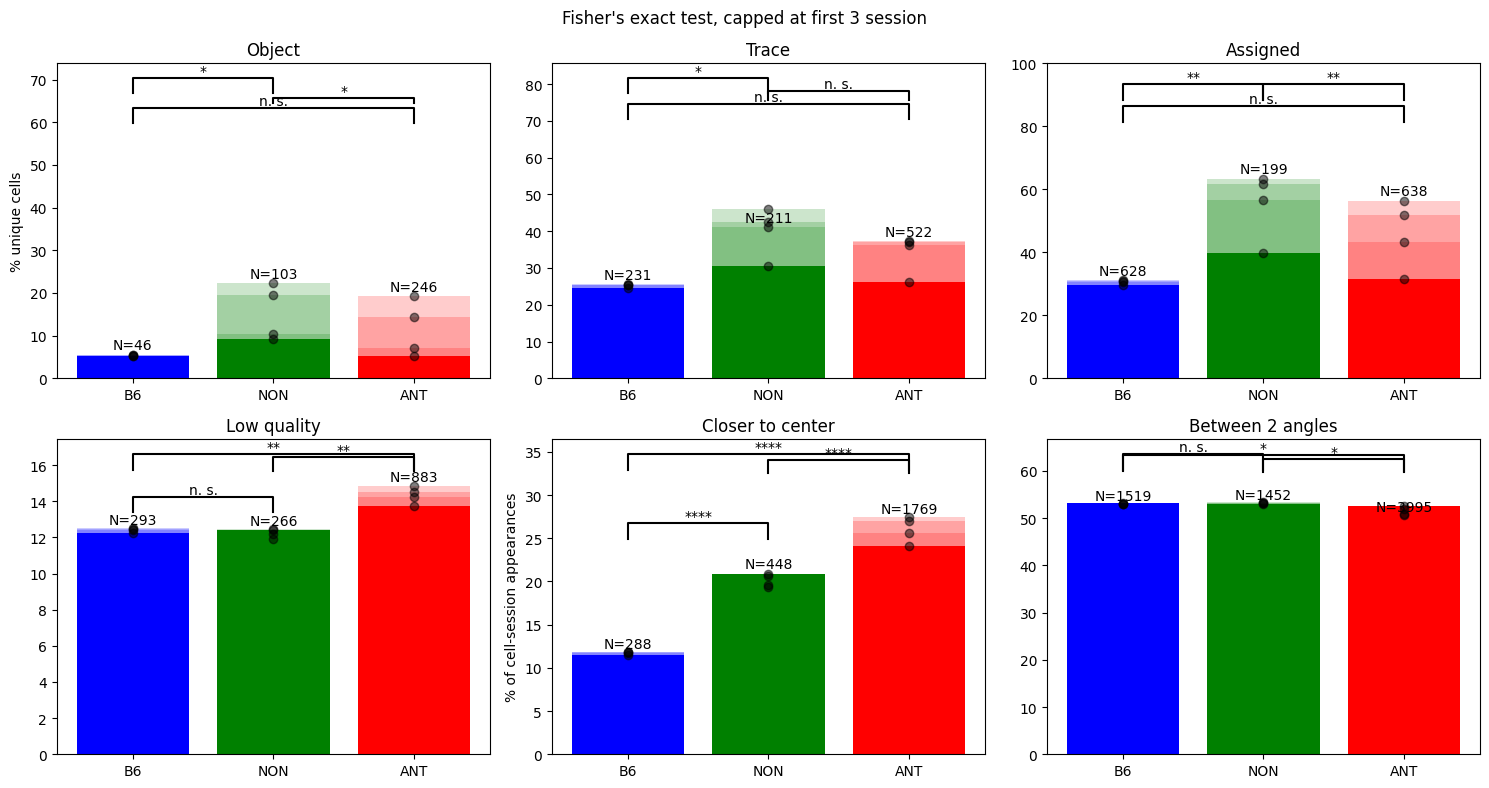

In [19]:
from matplotlib import gridspec


# ses1234_identifier_dict, ses12345_identifier_dict, ses123456_identifier_dict]
dtitles = ['Session 1 to 3', 'Session 1 to 4', 'Session 1 to 5', 'Session 1 to 6']
# dpositions = [0.93, 0.68, 0.33, 0.03]
# axids = [[[0,0],[0,1],[0,2]], [[1,0],[1,1],[1,2]], [[2,0],[2,1],[2,2]], [[3,0],[3,1],[3,2]]]
lbls = ['N=3', 'N=4', 'N=5', 'N=6']
fig = plt.figure(figsize=(15,8))
# gspec 3x3
gspec = gridspec.GridSpec(2,3)

b6notdone_1 = True
b6notdone_2 = True
b6notdone_3 = True
nonnotdone_2 = True

for i in range(len(dlist)):
    dtouse = dlist[i]
    dtitle = dtitles[i]
    # dpos = dpositions[i]
    # axid = axids[i]

    ANT_obj = dtouse['object']['ANT']
    ANT_trace = dtouse['trace']['ANT']
    ANT_unassigned = dtouse['unassigned']['ANT']

    prev_ANT_obj_per = len(ANT_obj) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    sum_ANT = ANT_cell_type_df[ANT_cell_type_df['object_location'].astype(str) != 'NO']
    sum_ANT = sum_ANT.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_ANT = len(sum_ANT)
    ANT_obj_per = len(ANT_obj) / sum_ANT
    print(ANT_obj_per, prev_ANT_obj_per)
    ANT_trace_per = len(ANT_trace) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    ANT_unassigned_per = 1 - ANT_obj_per - ANT_trace_per

    B6_obj = dtouse['object']['B6']
    B6_trace = dtouse['trace']['B6']
    B6_unassigned = dtouse['unassigned']['B6']

    # B6_obj_per = len(B6_obj) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    sum_B6 = B6_cell_type_df[B6_cell_type_df['object_location'].astype(str) != 'NO']
    sum_B6 = sum_B6.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_B6 = len(sum_B6)
    B6_obj_per = len(B6_obj) / sum_B6
    B6_trace_per = len(B6_trace) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    # B6_unassigned_per = len(B6_unassigned) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    B6_unassigned_per = 1 - B6_obj_per - B6_trace_per

    NON_obj = dtouse['object']['NON']
    NON_trace = dtouse['trace']['NON']
    NON_unassigned = dtouse['unassigned']['NON']

    # NON_obj_per = len(NON_obj) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    sum_NON = NON_cell_type_df[NON_cell_type_df['object_location'].astype(str) != 'NO']
    sum_NON = sum_NON.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_NON = len(sum_NON)
    NON_obj_per = len(NON_obj) / sum_NON
    NON_trace_per = len(NON_trace) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    # NON_unassigned_per = len(NON_unassigned) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    NON_unassigned_per = 1 - NON_obj_per - NON_trace_per

    # obj_per = np.array([ANT_obj_per, B6_obj_per, NON_obj_per]) * 100
    obj_per = np.array([B6_obj_per, NON_obj_per, ANT_obj_per]) * 100
    # trace_per = np.array([ANT_trace_per, B6_trace_per, NON_trace_per]) * 100
    trace_per = np.array([B6_trace_per, NON_trace_per, ANT_trace_per]) * 100
    # unassigned_per = np.array([ANT_unassigned_per, B6_unassigned_per, NON_unassigned_per]) * 100
    unassigned_per = np.array([B6_unassigned_per, NON_unassigned_per, ANT_unassigned_per]) * 100

    unassigned_per = 100 - unassigned_per


    # top left
    ax1 = plt.subplot(gspec[0,0])
    ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'OBJECT' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    
    ax1.plot(['B6', 'NON', 'ANT'], obj_per, 'k-', marker='o', alpha=0.5, lw=0)
    # annotate
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and b6notdone_1:
    #         ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6':
    #         ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
    #     if lbl == 'B6':
    #         b6notdone_1 = False


    ax1.set_title('Object')
    ax1.set_ylabel('% unique cells')

    # top middle
    ax2 = plt.subplot(gspec[0,1])
    ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'TRACE' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per+10, maxasterix=5)

                    
    ax2.plot(['B6', 'NON', 'ANT'], trace_per, 'k-', marker='o', alpha=0.5, lw=0)
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and b6notdone_2:
    #         ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     # elif lbl == 'NON' and nonnotdone_2 and i != 0:
    #     #     ax2.annotate('N=4,5,6', xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,15), ha='center')
    #     # elif lbl == 'ANT' or (lbl == 'NON' and i == 0):
    #     elif lbl != 'B6':
    #         ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
    #     if lbl == 'B6':
    #         b6notdone_2 = False
    #     if lbl == 'NON' and i != 0:
    #         nonnotdone_2 = False
    ax2.set_title('Trace')

    # top right
    ax3 = plt.subplot(gspec[0,2])
    ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per+20, maxasterix=5)

                    


    ax3.plot(['B6', 'NON', 'ANT'], unassigned_per, 'k-', marker='o', alpha=0.5, lw=0)
    ax3.set_title('Assigned')
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and b6notdone_3:
    #         ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6':
    #         ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
    #     if lbl == 'B6':
    #         b6notdone_3 = False
    ax3.set_ylim([0,100])

    if i == len(dlist)-1:
        obj_counts = [len(B6_obj), len(NON_obj), len(ANT_obj)]
        trace_counts = [len(B6_trace), len(NON_trace), len(ANT_trace)]
        unassigned_counts = [len(B6_unassigned), len(NON_unassigned), len(ANT_unassigned)]

        for j, lbl in enumerate(['B6', 'NON', 'ANT']):
            ax1.annotate('N='+f'{obj_counts[j]}', xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,4), ha='center')
            ax2.annotate('N='+f'{trace_counts[j]}', xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,4), ha='center')
            ax3.annotate('N='+f'{unassigned_counts[j]}', xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,4), ha='center')




    ax6 = plt.subplot(gspec[1,2])
    per1 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] +  ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['NON'])
    ambiguous_pers = np.array( [per2, per3, per1])*100
    ax6.plot(['B6', 'NON', 'ANT'], ambiguous_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax6.set_title('Between 2 angles')
    ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha=0.2)
    if i == 0:
        ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha = 1)
    print(ambiguous_pers)
    if i == len(dlist)-1:
        comps = dflist[2]['Comparison']
        accepted = dflist[2]['Accepted']
        adjusted = dflist[2]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], ambiguous_pers+3.7, maxasterix=5)
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and i == 0:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6' and i == 0 or lbl == 'B6' and i == 3:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')



    ax5 = plt.subplot(gspec[1,1])
    per1 = ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['center_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['center_type_dict']['B6'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['center_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['center_type_dict']['NON'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['NON'])
    center_pers = np.array( [per2, per3, per1])*100
    ax5.plot(['B6', 'NON', 'ANT'], center_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax5.set_title('Closer to center')
    ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = .2)


    if i == 0:
        ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = 1)
    #     ax5.bar(['B6', 'NON', 'ANT'], [0, center_pers[1], 0], color=['blue', 'green', 'red'], alpha = .2)
    # if i == len(dlist)-1:
    #     ax5.bar(['B6', 'NON', 'ANT'], [0, center_pers[1], 0], color=['blue', 'green', 'red'], alpha = 1)

    if i == len(dlist)-1:
        comps = dflist[1]['Comparison']
        accepted = dflist[1]['Accepted']
        adjusted = dflist[1]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], center_pers+3.7, maxasterix=5)

    ax4 = plt.subplot(gspec[1,0])
    per1 = ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['NON'])
    quality_pers = np.array( [per2, per3, per1])*100
    ax4.plot(['B6', 'NON', 'ANT'], quality_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax4.set_title('Low quality')
    ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = .2)
    
    quality_iso_counts = np.array([ses_cut_dict[int(3+i)]['quality_type_dict']['B6'], ses_cut_dict[int(3+i)]['quality_type_dict']['NON'], ses_cut_dict[int(3+i)]['quality_type_dict']['ANT']])
    center_counts = np.array([ses_cut_dict[int(3+i)]['center_type_dict']['B6'], ses_cut_dict[int(3+i)]['center_type_dict']['NON'], ses_cut_dict[int(3+i)]['center_type_dict']['ANT']])
    ambiguous_counts = np.array([ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'], ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'], ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT']])
    
    if i == len(dlist)-1:
        quality_iso_counts_first = np.array([ses_cut_dict[3]['quality_type_dict']['B6'], ses_cut_dict[3]['quality_type_dict']['NON'], ses_cut_dict[3]['quality_type_dict']['ANT']])
        center_counts_first = np.array([ses_cut_dict[3]['center_type_dict']['B6'], ses_cut_dict[3]['center_type_dict']['NON'], ses_cut_dict[3]['center_type_dict']['ANT']])
        ambiguous_counts_first = np.array([ses_cut_dict[3]['ambiguous_type_dict']['B6'], ses_cut_dict[3]['ambiguous_type_dict']['NON'], ses_cut_dict[3]['ambiguous_type_dict']['ANT']])
        for j, lbl in enumerate(['B6', 'NON', 'ANT']):
            # sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
            # ax4_lbl = 'N1='+str(quality_iso_counts_first[j]) + ', N6='+str(quality_iso_counts[j])
            # ax4.annotate(ax4_lbl, xy=(lbl, quality_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
            # ax5_lbl = 'N1='+str(center_counts_first[j]) + ', N6='+str(center_counts[j])
            # ax5.annotate(ax5_lbl, xy=(lbl, center_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
            # ax6_lbl = 'N1='+str(ambiguous_counts_first[j]) + ', N6='+str(ambiguous_counts[j])
            # ax6.annotate(ax6_lbl, xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
            ax4.annotate('N='+str(quality_iso_counts[j]), xy=(lbl, quality_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
            if j == 1:
                shift_lbl_height = 1.7
            else:
                shift_lbl_height = 0
            ax5.annotate('N='+str(center_counts[j]), xy=(lbl, center_pers[j] + shift_lbl_height),textcoords='offset points', xytext=(0,3), ha='center')
            ax6.annotate('N='+str(ambiguous_counts[j]), xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')

    if i == 0:
        ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:   
        comps = dflist[0]['Comparison']
        accepted = dflist[0]['Accepted']
        adjusted = dflist[0]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], quality_pers, maxasterix=5)

    ax5.set_ylabel('% of cell-session appearances')


    fig.suptitle("Fisher's exact test, capped at first 3 session")

    fig.tight_layout()


In [168]:
len(dlist)

4

ANT object count 67 and ANT not object count 1279
B6 object count 43 and B6 not object count 830
NON object count 43 and NON not object count 463
[27.81746032 31.75635719 42.94670846]
ANT object count 90 and ANT not object count 1279
B6 object count 43 and B6 not object count 830
NON object count 48 and NON not object count 463
[27.64705882 31.99373695 43.51360319]
ANT object count 184 and ANT not object count 1279
B6 object count 46 and B6 not object count 830
NON object count 90 and NON not object count 463
[27.76049767 32.48730964 43.57664234]
ANT object count 246 and ANT not object count 1279
B6 object count 46 and B6 not object count 830
NON object count 103 and NON not object count 463
[27.76699029 32.71889401 43.91046741]


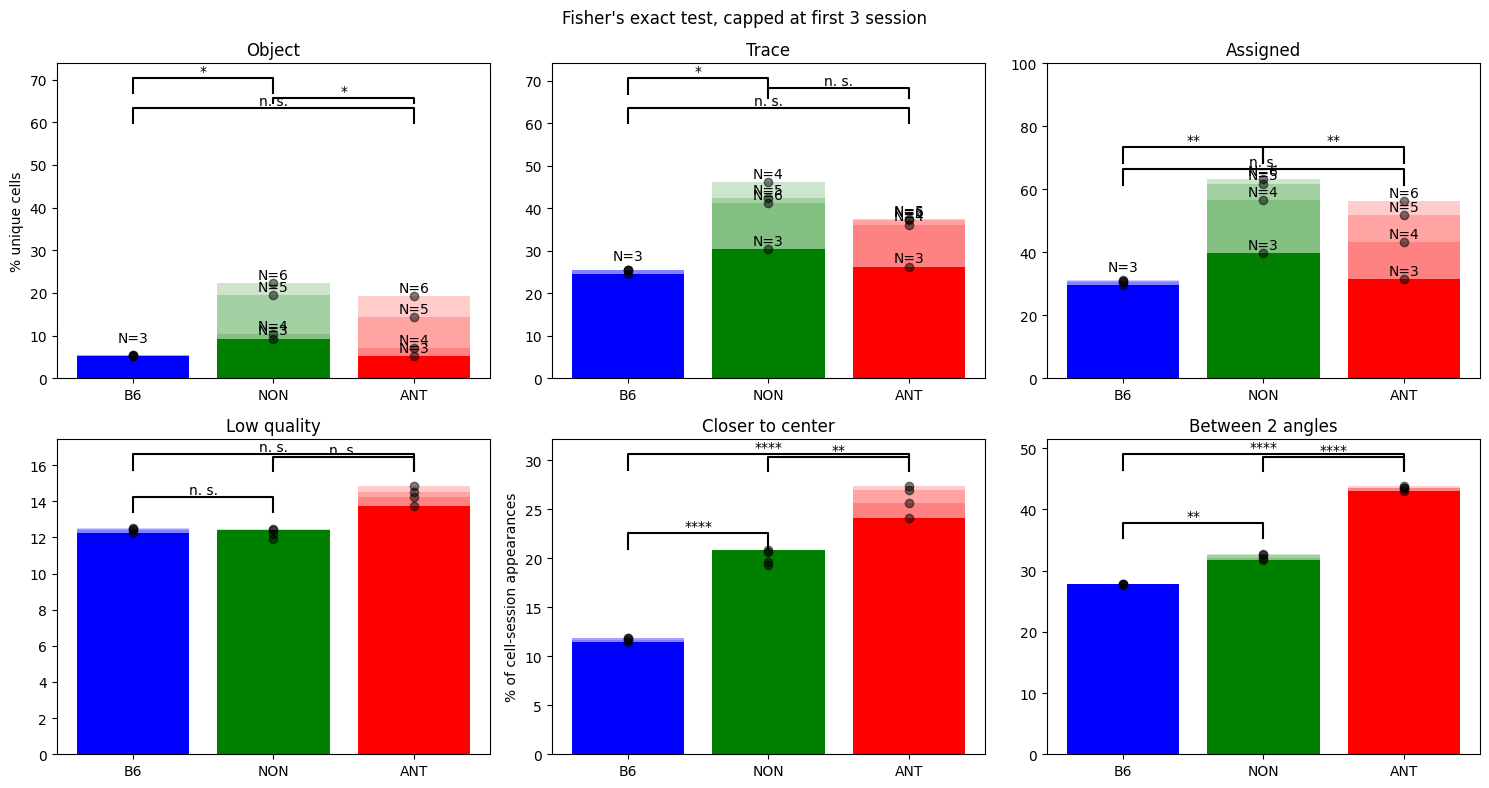

In [286]:
from matplotlib import gridspec


# ses1234_identifier_dict, ses12345_identifier_dict, ses123456_identifier_dict]
dtitles = ['Session 1 to 3', 'Session 1 to 4', 'Session 1 to 5', 'Session 1 to 6']
# dpositions = [0.93, 0.68, 0.33, 0.03]
# axids = [[[0,0],[0,1],[0,2]], [[1,0],[1,1],[1,2]], [[2,0],[2,1],[2,2]], [[3,0],[3,1],[3,2]]]
lbls = ['N=3', 'N=4', 'N=5', 'N=6']
fig = plt.figure(figsize=(15,8))
# gspec 3x3
gspec = gridspec.GridSpec(2,3)

b6notdone_1 = True
b6notdone_2 = True
b6notdone_3 = True
nonnotdone_2 = True

for i in range(len(dlist)):
    dtouse = dlist[i]
    dtitle = dtitles[i]
    # dpos = dpositions[i]
    # axid = axids[i]

    ses_list = ['session_1', 'session_2', 'session_3']
    if i == 1:
        ses_list.append('session_4')
    elif i == 2:
        ses_list.append('session_4')
        ses_list.append('session_5')
    elif i == 3:
        ses_list.append('session_4')
        ses_list.append('session_5')
        ses_list.append('session_6')

    ANT_obj = dtouse['object']['ANT']
    ANT_trace = dtouse['trace']['ANT']
    ANT_unassigned = dtouse['unassigned']['ANT']

    prev_ANT_obj_per = len(ANT_obj) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    sum_ANT = ANT_cell_type_df[ANT_cell_type_df['object_location'].astype(str) != 'NO']
    # sum_ANT = sum_ANT[sum_ANT['session_id'].isin(ses_list)]
    sum_ANT = sum_ANT.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_ANT = len(sum_ANT)
    ANT_obj_per = len(ANT_obj) / sum_ANT
    print('ANT object count {} and ANT not object count {}'.format(len(ANT_obj), sum_ANT))
    # print(ANT_obj_per, prev_ANT_obj_per, sum_ANT)
    ANT_trace_per = len(ANT_trace) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    ANT_unassigned_per = 1 - ANT_obj_per - ANT_trace_per

    B6_obj = dtouse['object']['B6']
    B6_trace = dtouse['trace']['B6']
    B6_unassigned = dtouse['unassigned']['B6']

    prev_B6_obj_per = len(B6_obj) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    sum_B6 = B6_cell_type_df[B6_cell_type_df['object_location'].astype(str) != 'NO']
    # sum_B6 = sum_B6[sum_B6['session_id'].isin(ses_list)]
    sum_B6 = sum_B6.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_B6 = len(sum_B6)
    B6_obj_per = len(B6_obj) / sum_B6
    print('B6 object count {} and B6 not object count {}'.format(len(B6_obj), sum_B6))
    # print(B6_obj_per, prev_B6_obj_per, sum_B6)
    B6_trace_per = len(B6_trace) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    # B6_unassigned_per = len(B6_unassigned) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    B6_unassigned_per = 1 - B6_obj_per - B6_trace_per

    NON_obj = dtouse['object']['NON']
    NON_trace = dtouse['trace']['NON']
    NON_unassigned = dtouse['unassigned']['NON']

    # NON_obj_per = len(NON_obj) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    sum_NON = NON_cell_type_df[NON_cell_type_df['object_location'].astype(str) != 'NO']
    # sum_NON = sum_NON[sum_NON['session_id'].isin(ses_list)]
    sum_NON = sum_NON.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_NON = len(sum_NON)
    NON_obj_per = len(NON_obj) / sum_NON
    print('NON object count {} and NON not object count {}'.format(len(NON_obj), sum_NON))
    NON_trace_per = len(NON_trace) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    # NON_unassigned_per = len(NON_unassigned) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    NON_unassigned_per = 1 - NON_obj_per - NON_trace_per

    # obj_per = np.array([ANT_obj_per, B6_obj_per, NON_obj_per]) * 100
    obj_per = np.array([B6_obj_per, NON_obj_per, ANT_obj_per]) * 100
    # trace_per = np.array([ANT_trace_per, B6_trace_per, NON_trace_per]) * 100
    trace_per = np.array([B6_trace_per, NON_trace_per, ANT_trace_per]) * 100
    # unassigned_per = np.array([ANT_unassigned_per, B6_unassigned_per, NON_unassigned_per]) * 100
    unassigned_per = np.array([B6_unassigned_per, NON_unassigned_per, ANT_unassigned_per]) * 100

    unassigned_per = 100 - unassigned_per


    # top left
    ax1 = plt.subplot(gspec[0,0])
    ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'OBJECT' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    
    ax1.plot(['B6', 'NON', 'ANT'], obj_per, 'k-', marker='o', alpha=0.5, lw=0)
    # annotate
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        if lbl == 'B6' and b6notdone_1:
            ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        elif lbl != 'B6':
            ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_1 = False


    ax1.set_title('Object')
    ax1.set_ylabel('% unique cells')

    # top middle
    ax2 = plt.subplot(gspec[0,1])
    ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'TRACE' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    
    ax2.plot(['B6', 'NON', 'ANT'], trace_per, 'k-', marker='o', alpha=0.5, lw=0)
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        if lbl == 'B6' and b6notdone_2:
            ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        # elif lbl == 'NON' and nonnotdone_2 and i != 0:
        #     ax2.annotate('N=4,5,6', xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,15), ha='center')
        # elif lbl == 'ANT' or (lbl == 'NON' and i == 0):
        elif lbl != 'B6':
            ax2.annotate(lbls[i], xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_2 = False
        if lbl == 'NON' and i != 0:
            nonnotdone_2 = False
    ax2.set_title('Trace')

    # top right
    ax3 = plt.subplot(gspec[0,2])
    ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    


    ax3.plot(['B6', 'NON', 'ANT'], unassigned_per, 'k-', marker='o', alpha=0.5, lw=0)
    ax3.set_title('Assigned')
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        if lbl == 'B6' and b6notdone_3:
            ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        elif lbl != 'B6':
            ax3.annotate(lbls[i], xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_3 = False
    ax3.set_ylim([0,100])


    ax6 = plt.subplot(gspec[1,2])
    per1 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] +  ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['NON'])
    ambiguous_pers = np.array( [per2, per3, per1])*100
    ax6.plot(['B6', 'NON', 'ANT'], ambiguous_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax6.set_title('Between 2 angles')
    ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha=0.2)
    if i == 0:
        ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha = 1)
    print(ambiguous_pers)
    if i == len(dlist)-1:
        comps = dflist[2]['Comparison']
        accepted = dflist[2]['Accepted']
        adjusted = dflist[2]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], ambiguous_pers, maxasterix=5)
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and i == 0:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6' and i == 0 or lbl == 'B6' and i == 3:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')



    ax5 = plt.subplot(gspec[1,1])
    per1 = ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['center_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['center_type_dict']['B6'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['center_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['center_type_dict']['NON'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['NON'])
    center_pers = np.array( [per2, per3, per1])*100
    ax5.plot(['B6', 'NON', 'ANT'], center_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax5.set_title('Closer to center')
    ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = .2)


    if i == 0:
        ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = 1)

    if i == len(dlist)-1:
        comps = dflist[1]['Comparison']
        accepted = dflist[1]['Accepted']
        adjusted = dflist[1]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], center_pers, maxasterix=5)

    ax4 = plt.subplot(gspec[1,0])
    per1 = ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['NON'])
    quality_pers = np.array( [per2, per3, per1])*100
    ax4.plot(['B6', 'NON', 'ANT'], quality_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax4.set_title('Low quality')
    ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = .2)

    if i == 0:
        ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = 1)
    if i == len(dlist)-1:   
        comps = dflist[0]['Comparison']
        accepted = dflist[0]['Accepted']
        adjusted = dflist[0]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], quality_pers, maxasterix=5)

    ax5.set_ylabel('% of cell-session appearances')


    fig.suptitle("Fisher's exact test, capped at first 3 session")

    fig.tight_layout()


0.029069767441860465 0.019342359767891684
object pers
[2.74725275 7.65765766 2.90697674]
trace pers
[19.74317817 23.24159021 21.27659574]
unassigned pers
[77.50956908 69.10075213 75.81642751]
center pers
[11.50442478 20.8057727  24.09858512]
quality pers
[12.25468818 12.4260355  13.75583395]
ambiguous pers
[27.81746032 31.75635719 42.94670846]


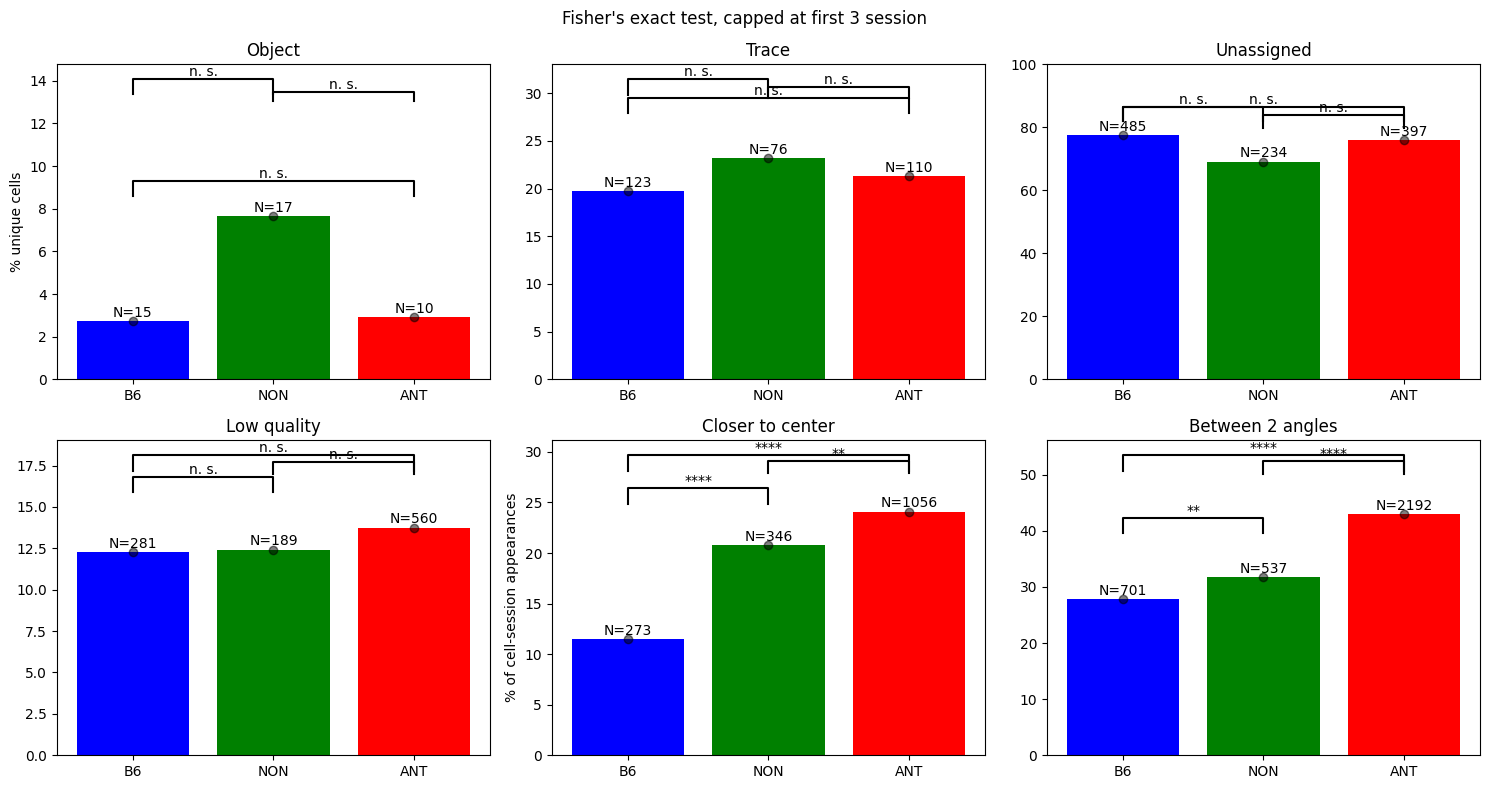

In [328]:
from matplotlib import gridspec


# ses1234_identifier_dict, ses12345_identifier_dict, ses123456_identifier_dict]
dtitles = ['Session 1 to 3']
#  'Session 1 to 4', 'Session 1 to 5', 'Session 1 to 6']
# dpositions = [0.93, 0.68, 0.33, 0.03]
# axids = [[[0,0],[0,1],[0,2]], [[1,0],[1,1],[1,2]], [[2,0],[2,1],[2,2]], [[3,0],[3,1],[3,2]]]
lbls = ['N=3']
#  'N=4', 'N=5', 'N=6']
fig = plt.figure(figsize=(15,8))
# gspec 3x3
gspec = gridspec.GridSpec(2,3)

b6notdone_1 = True
b6notdone_2 = True
b6notdone_3 = True
nonnotdone_2 = True

for i in range(1):
    dtouse = dlist[i]
    dtitle = dtitles[i]
    # dpos = dpositions[i]
    # axid = axids[i]
    ses_list = ['session_1', 'session_2', 'session_3']
    assert i == 0

    ANT_obj = dtouse['object']['ANT']
    ANT_trace = dtouse['trace']['ANT']
    ANT_unassigned = dtouse['unassigned']['ANT']

    prev_ANT_obj_per = len(ANT_obj) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    sum_ANT = ANT_cell_type_df[ANT_cell_type_df['object_location'].astype(str) != 'NO']
    sum_ANT = sum_ANT[sum_ANT['session_id'].isin(ses_list)]
    sum_ANT = sum_ANT.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_ANT = len(sum_ANT)
    ANT_obj_per = len(ANT_obj) / sum_ANT
    print(ANT_obj_per, prev_ANT_obj_per)
    ANT_trace_per = len(ANT_trace) / (len(ANT_obj) + len(ANT_trace) + len(ANT_unassigned))
    ANT_unassigned_per = 1 - ANT_obj_per - ANT_trace_per

    B6_obj = dtouse['object']['B6']
    B6_trace = dtouse['trace']['B6']
    B6_unassigned = dtouse['unassigned']['B6']

    # B6_obj_per = len(B6_obj) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    sum_B6 = B6_cell_type_df[B6_cell_type_df['object_location'].astype(str) != 'NO']
    sum_B6 = sum_B6[sum_B6['session_id'].isin(ses_list)]
    sum_B6 = sum_B6.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_B6 = len(sum_B6)
    B6_obj_per = len(B6_obj) / sum_B6
    B6_trace_per = len(B6_trace) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    # B6_unassigned_per = len(B6_unassigned) / (len(B6_obj) + len(B6_trace) + len(B6_unassigned))
    B6_unassigned_per = 1 - B6_obj_per - B6_trace_per

    NON_obj = dtouse['object']['NON']
    NON_trace = dtouse['trace']['NON']
    NON_unassigned = dtouse['unassigned']['NON']

    # NON_obj_per = len(NON_obj) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    sum_NON = NON_cell_type_df[NON_cell_type_df['object_location'].astype(str) != 'NO']
    sum_NON = sum_NON[sum_NON['session_id'].isin(ses_list)]
    sum_NON = sum_NON.groupby(group_by_unique_cell).filter(lambda x: len(x) >= 2).groupby(group_by_unique_cell)
    sum_NON = len(sum_NON)
    NON_obj_per = len(NON_obj) / sum_NON
    NON_trace_per = len(NON_trace) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    # NON_unassigned_per = len(NON_unassigned) / (len(NON_obj) + len(NON_trace) + len(NON_unassigned))
    NON_unassigned_per = 1 - NON_obj_per - NON_trace_per

    # obj_per = np.array([ANT_obj_per, B6_obj_per, NON_obj_per]) * 100
    obj_per = np.array([B6_obj_per, NON_obj_per, ANT_obj_per]) * 100
    obj_count = np.array([len(B6_obj), len(NON_obj), len(ANT_obj)])
    # trace_per = np.array([ANT_trace_per, B6_trace_per, NON_trace_per]) * 100
    trace_per = np.array([B6_trace_per, NON_trace_per, ANT_trace_per]) * 100
    trace_count = np.array([len(B6_trace), len(NON_trace), len(ANT_trace)])
    # unassigned_per = np.array([ANT_unassigned_per, B6_unassigned_per, NON_unassigned_per]) * 100
    unassigned_per = np.array([B6_unassigned_per, NON_unassigned_per, ANT_unassigned_per]) * 100
    unassigned_count = np.array([len(B6_unassigned), len(NON_unassigned), len(ANT_unassigned)])

    # unassigned_per = 100 - unassigned_per
    unassigned_per = unassigned_per


    # top left
    ax1 = plt.subplot(gspec[0,0])
    ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax1.bar(['B6', 'NON', 'ANT'], obj_per, color=['blue', 'green', 'red'], alpha = 1)
    # if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'OBJECT' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], obj_per+5, maxasterix=5)

                    
    ax1.plot(['B6', 'NON', 'ANT'], obj_per, 'k-', marker='o', alpha=0.5, lw=0)
    # annotate
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        # if lbl == 'B6' and b6notdone_1:
        #     ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,10), ha='center')
        # elif lbl != 'B6':
        #     ax1.annotate(lbls[i], xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6' and b6notdone_1:
            ax1.annotate('N=' + str(obj_count[j]), xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        elif lbl != 'B6':
            ax1.annotate('N=' + str(obj_count[j]), xy=(lbl, obj_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_1 = False


    ax1.set_title('Object')
    ax1.set_ylabel('% unique cells')

    # top middle
    ax2 = plt.subplot(gspec[0,1])
    ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax2.bar(['B6', 'NON', 'ANT'], trace_per, color=['blue', 'green', 'red'], alpha = 1)
    # if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'TRACE' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], trace_per +5, maxasterix=5)

                    
    ax2.plot(['B6', 'NON', 'ANT'], trace_per, 'k-', marker='o', alpha=0.5, lw=0)
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        if lbl == 'B6' and b6notdone_2:
            ax2.annotate('N='+str(trace_count[j]), xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        # elif lbl == 'NON' and nonnotdone_2 and i != 0:
        #     ax2.annotate('N=4,5,6', xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,15), ha='center')
        # elif lbl == 'ANT' or (lbl == 'NON' and i == 0):
        elif lbl != 'B6':
            ax2.annotate('N='+str(trace_count[j]), xy=(lbl, trace_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_2 = False
        if lbl == 'NON' and i != 0:
            nonnotdone_2 = False
    ax2.set_title('Trace')

    # top right
    ax3 = plt.subplot(gspec[0,2])
    ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 0.2)
    if i == 0:
        ax3.bar(['B6', 'NON', 'ANT'], unassigned_per, color=['blue', 'green', 'red'], alpha = 1)
    # if i == len(dlist)-1:
        comps = results_df['Comparison']
        accepted = results_df['Accepted']
        adjusted = results_df['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], unassigned_per, maxasterix=5)

                    

    ax3.plot(['B6', 'NON', 'ANT'], unassigned_per, 'k-', marker='o', alpha=0.5, lw=0)
    ax3.set_title('Unassigned')
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        if lbl == 'B6' and b6notdone_3:
            ax3.annotate('N='+str(unassigned_count[j]), xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        elif lbl != 'B6':
            ax3.annotate('N='+str(unassigned_count[j]), xy=(lbl, unassigned_per[j]),textcoords='offset points', xytext=(0,3), ha='center')
        if lbl == 'B6':
            b6notdone_3 = False
    ax3.set_ylim([0,100])


    ax6 = plt.subplot(gspec[1,2])
    per1 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT'] +  ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'] + ses_cut_dict[int(3+i)]['ambiguous_inv_type_dict']['NON'])
    ambiguous_pers = np.array( [per2, per3, per1])*100
    ambiguous_counts = np.array([ses_cut_dict[int(3+i)]['ambiguous_type_dict']['B6'], ses_cut_dict[int(3+i)]['ambiguous_type_dict']['NON'], ses_cut_dict[int(3+i)]['ambiguous_type_dict']['ANT']])
    ax6.plot(['B6', 'NON', 'ANT'], ambiguous_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax6.set_title('Between 2 angles')
    ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha=0.2)
    if i == 0:
        ax6.bar(['B6', 'NON', 'ANT'], ambiguous_pers, color=['blue', 'green', 'red'], alpha = 1)
    # print(ambiguous_pers)
    # if i == len(dlist)-1:
        comps = dflist[2]['Comparison']
        accepted = dflist[2]['Accepted']
        adjusted = dflist[2]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], ambiguous_pers+5, maxasterix=5)
    # for j, lbl in enumerate(['B6', 'NON', 'ANT']):
    #     if lbl == 'B6' and i == 0:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,10), ha='center')
    #     elif lbl != 'B6' and i == 0 or lbl == 'B6' and i == 3:
    #         ax6.annotate(lbls[i], xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')



    ax5 = plt.subplot(gspec[1,1])
    per1 = ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['center_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['center_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['center_type_dict']['B6'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['center_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['center_type_dict']['NON'] + ses_cut_dict[int(3+i)]['center_inv_type_dict']['NON'])
    center_pers = np.array( [per2, per3, per1])*100
    center_counts = np.array([ses_cut_dict[int(3+i)]['center_type_dict']['B6'], ses_cut_dict[int(3+i)]['center_type_dict']['NON'], ses_cut_dict[int(3+i)]['center_type_dict']['ANT']])
    ax5.plot(['B6', 'NON', 'ANT'], center_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax5.set_title('Closer to center')
    ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = .2)


    if i == 0:
        ax5.bar(['B6', 'NON', 'ANT'], center_pers, color=['blue', 'green', 'red'], alpha = 1)

    # if i == len(dlist)-1:
        comps = dflist[1]['Comparison']
        accepted = dflist[1]['Accepted']
        adjusted = dflist[1]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], center_pers+2.5, maxasterix=5)

    ax4 = plt.subplot(gspec[1,0])
    per1 = ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['ANT'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['ANT'])
    per2 = ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['B6'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['B6'])
    per3 = ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] / (ses_cut_dict[int(3+i)]['quality_type_dict']['NON'] + ses_cut_dict[int(3+i)]['quality_inv_type_dict']['NON'])
    quality_pers = np.array( [per2, per3, per1])*100
    quality_iso_counts = np.array([ses_cut_dict[int(3+i)]['quality_type_dict']['B6'], ses_cut_dict[int(3+i)]['quality_type_dict']['NON'], ses_cut_dict[int(3+i)]['quality_type_dict']['ANT']])
    ax4.plot(['B6', 'NON', 'ANT'], quality_pers, 'k-', marker='o', alpha=0.5, lw=0)
    ax4.set_title('Low quality')
    ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = .2)
    for j, lbl in enumerate(['B6', 'NON', 'ANT']):
        ax4.annotate('N='+str(quality_iso_counts[j]), xy=(lbl, quality_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
        ax5.annotate('N='+str(center_counts[j]), xy=(lbl, center_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')
        ax6.annotate('N='+str(ambiguous_counts[j]), xy=(lbl, ambiguous_pers[j]),textcoords='offset points', xytext=(0,3), ha='center')

    if i == 0:
        ax4.bar(['B6', 'NON', 'ANT'], quality_pers, color=['blue', 'green', 'red'], alpha = 1)
    # if i == len(dlist)-1:   
        comps = dflist[0]['Comparison']
        accepted = dflist[0]['Accepted']
        adjusted = dflist[0]['Adjusted P-value']
        for k in range(len(comps)):
            comparison = comps[k]
            if 'UNASSIGNED' in str(comparison):
                if 'ANT' in comparison and 'B6' in comparison:
                    nme = [0,2]
                elif 'ANT' in comparison and 'NON' in comparison:
                    nme = [1,2]
                elif 'B6' in comparison and 'NON' in comparison:
                    nme = [0,1]
                
                # if accepted[k]:
                barplot_annotate_brackets(nme[0],nme[1],adjusted[k],[0,1,2], quality_pers+2.5, maxasterix=5)

    ax5.set_ylabel('% of cell-session appearances')
    
    # ax1.set_ylim(0,100)
    # ax2.set_ylim(0,100)
    # ax3.set_ylim(0,100)
    # ax4.set_ylim(0,100)
    # ax5.set_ylim(0,100)
    # ax6.set_ylim(0,100)


    fig.suptitle("Fisher's exact test, capped at first 3 session")

    fig.tight_layout()

print('object pers')
print(obj_per)
print('trace pers')
print(trace_per)
print('unassigned pers')
print(unassigned_per)

print('center pers')
print(center_pers)
print('quality pers')
print(quality_pers)
print('ambiguous pers')
print(ambiguous_pers)

# # save percentages to one text file
# folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_final_figures"
# save_path = os.path.join(folder, 'percentages.txt')
# with open(save_path, 'w') as f:
#     f.write('object pers\n')
#     f.write(str(obj_per))
#     f.write('\ntrace pers\n')
#     f.write(str(trace_per))
#     f.write('\nunassigned pers\n')
#     f.write(str(unassigned_per))
#     f.write('\ncenter pers\n')
#     f.write(str(center_pers))
#     f.write('\nquality pers\n')
#     f.write(str(quality_pers))
#     f.write('\nambiguous pers\n')
#     f.write(str(ambiguous_pers))

# saveefig 
# save_path = os.path.join(folder, 'percentages.pdf')
# plt.savefig(save_path, dpi=1080, bbox_inches='tight')

In [96]:
tosave = dlist[0]
import pickle
# save the dictionary
with open('ses123_identifier_dict_keep_swapped.pkl', 'wb') as f:
    pickle.dump(tosave, f)

In [ ]:
prev_df = None
for ky in tosave['trace']:
    for idd in tosave['trace'][ky]:
        id1, id2, id3, id4, id5, id6 = idd
        # print(id1, id2, id3, id4, id5, id6)
        # mask = pd.concat([(df2['group'] == id1) & (df2['name'] == id2)?
        mask = pd.concat([(df2['group'] == id1) & (df2['name'] == id2) & (df2['depth'] == id3) & (df2['date'] == id4) & (df2['tetrode'] == id5) & (df2['unit_id'] == id6)], axis=1).any(axis=1)
        if prev_df is None:
            new_df = df2[mask]
        else:
            new_df = pd.concat([prev_df, df2[mask]])
        prev_df = new_df

prev_df.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_trace_cells.xlsx')

prev_df = None
for ky in tosave['object']:
    for idd in tosave['object'][ky]:
        id1, id2, id3, id4, id5, id6 = idd
        # mask = pd.concat([(df2['group'] == id1) & (df2['name'] == id2)?
        mask = pd.concat([(df2['group'] == id1) & (df2['name'] == id2) & (df2['depth'] == id3) & (df2['date'] == id4) & (df2['tetrode'] == id5) & (df2['unit_id'] == id6)], axis=1).any(axis=1)
        if prev_df is None:
            new_df = df2[mask]
        else:
            new_df = pd.concat([prev_df, df2[mask]])
        prev_df = new_df

prev_df.to_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\df_full_LEC_only_object_cells.xlsx')




In [ ]:
len(tosave['unassigned']['ANT']) + len(tosave['unassigned']['B6']) + len(tosave['unassigned']['NON'])

In [ ]:
126+53+41